In [8]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import h5py
import os
import tqdm
import scipy
from scipy import signal
from tqdm import tnrange
import seaborn as sns
from scipy.stats import norm, entropy, linregress#, erf
from scipy.optimize import minimize, curve_fit
#from scipy.stats import norm
from scipy.io import savemat
import multiprocess as mp
from multiprocess import Pool
from scipy.special import erf
import sys
import warnings
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'

mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

In [9]:
def calc_plam(num_pulses,lam1,lam2):
    pow_lam1 = np.power(lam1,num_pulses)
    pow_lam2 = np.power(lam2,num_pulses)
    exp_lam1 = np.exp(-lam1)
    exp_lam2 = np.exp(-lam2)
    return pow_lam1*exp_lam1/(pow_lam1*exp_lam1+pow_lam2*exp_lam2)

def compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin=1):
    sig_Nps = sig_Np[Nps-Nmin]
    sig = np.sqrt(sig_Nps**2+sig_dN**2) #There's a 2 missing
    phigh = norm.cdf((Nps-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

def compute_pcorrect_new(choices,Nps,Nb,sig_Np,Nmin=1):
    sig_Nps = sig_Np[Nps-Nmin]
    sig = np.sqrt(sig_Nps**2) 
    phigh = norm.cdf((Nps-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

def compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np,Nmin=1):
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin=1)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_new(choices,Nps,Nb,sig_Np,Nmin=1):
    pcorrect = compute_pcorrect_new(choices,Nps,Nb,sig_Np,Nmin=1)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_Np,Nmin=1): #sig_dN,
    sig_Nps = sig_Np[Nps-Nmin]
    sig = np.sqrt(sig_Nps**2)#+sig_dN**2)
    phigh = norm.cdf((weighted_odor-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

def compute_phigh(Np,Nb,sig_dN,sig_Np):
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_sq(Np,Nb,ksig,Nmin=1,Nmax=18):
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    sig = np.sqrt(sig_Np**2) #+sig_dN**2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_lin(Np,Nb,ksig,sig_0,Nmin=1,Nmax=18): #sig_dN
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    sig = np.sqrt(sig_Np**2) #+sig_dN**2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_lin_sub(Np,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18): #ksig,sig_0,sub
    #sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    sub_Np = np.zeros(4) #sig_0*np.ones(4)
    sig_Np = np.concatenate([sub_Np,ksig*(np.arange(5,Nmax+1,1))+sig_0]) # + sig_0
    print(sig_Np)
    sig = np.sqrt(sig_Np**2+sig_dN**2)   #Why this is not multiplied by 2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_pow(Np,Nb,sig_dN,ksig,ind,Nmin=1,Nmax=18):
    sig_Np = ksig*np.power((np.arange(Nmin,Nmax+1)),ind)
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_const(Np,Nb,sig_dN,Nmin=1,Nmax=18):
    sig = sig_dN
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_weighted(choices,weighted_odor,Nps,Nb,sig_Np): #sig_dN
    pcorrect = compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_sq(choices,Nps,Nb,ksig,Nmin=1,Nmax=18): #sig_dN
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    return compute_logp_correct_new(choices,Nps,Nb,sig_Np)

def compute_logp_correct_sq_weighted(choices,weighted_odor,Nps,Nb,ksig,Nmin=1,Nmax=18): #sig_dN,
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    return compute_logp_correct_weighted(choices,weighted_odor,Nps,Nb,sig_Np)
    
def compute_logp_correct_lin(choices,Nps,Nb,ksig,sig_0,Nmin=1,Nmax=18):  #sig_dN
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    pcorrect = compute_pcorrect_new(choices,Nps,Nb,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_lin_weighted(choices,weighted_odor,Nps,Nb,ksig,sig_0,Nmin=1,Nmax=18): #sig_dN,
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    pcorrect = compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_Np) #sig_dN,
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_lin_sub(choices,Nps,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18): #ksig,sig_0,sub
    #sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    sub_NP = np.zeros(4)
    sig_Np = np.concatenate([sub_NP,ksig*(np.arange(5,Nmax+1,1))+sig_0]) # + sig_0
    #sig_Np[0:4] = sub
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_pow(choices,Nps,Nb,sig_dN,ksig,ind,Nmin=1,Nmax=18):
    sig_Np = ksig*np.power((np.arange(Nmin,Nmax+1)),ind)
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_const(choices,Nps,Nb,sig_dN,Nmin=1,Nmax=18):
    sig_Np = np.zeros((Nmax-Nmin+1,))
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def get_pulses(choices,cum_odor,min_pulse,max_pulse):
    all_Nps = np.ceil(cum_odor).astype(np.int)
    ind_selected = np.logical_and(all_Nps>=min_pulse,all_Nps<=max_pulse)
    #print(ind_selected.shape)
    return choices[ind_selected], all_Nps[ind_selected]

def get_odor_profile_actual(odor_profile):
    kernel = np.load('odor_kernel_50ms.npy')
    pulse_onsets = (np.diff(odor_profile)>0).astype(np.float)
    pulse_onsets_shifted = np.concatenate((np.zeros((70,)),pulse_onsets,np.zeros(131)))
    odor_profile_actual = np.convolve(pulse_onsets_shifted,kernel,mode='same')
    return odor_profile_actual

def get_conv_odor(session):
    num_trials = session['num_trials']
    conv_odor = np.zeros((num_trials,5000))
    conv_weights_all = np.zeros((num_trials,5000))
    sniff_kernel = np.load('inhalation_kernel_fine_weights_active.npy')
    sniff_kernel = sniff_kernel/sniff_kernel.mean()
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,10,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=120)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        conv_weights = np.zeros((10000,))
        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            conv_weights[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(sniff_kernel,nsample)*250/nsample
        sniff_markers[sniff_onset] = 1
        sniff_sampling_epoch = sniff[2500:7500]
        conv_weights_sampling_epoch = conv_weights[2500:7500]
        odor_command = session['trial_odor'][i_trial]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        odor_effective = odor*conv_weights_sampling_epoch
        conv_odor[i_trial,:] = odor_effective
        conv_weights_all[i_trial,:] = conv_weights_sampling_epoch
    return conv_odor, conv_weights_all

def get_sniff_histogram(session,shuffled=False):
    bins = np.linspace(0,250,16) #16
    num_trials = session['num_trials']
    sniff_hist = np.zeros((num_trials,15)) #15
    sniff_kernel = np.load('inhalation_kernel_fine_weights_active.npy')
    sniff_kernel = sniff_kernel/sniff_kernel.mean()
    
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        #print(sniff_raw.shape)
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        #print(sniff.shape)
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100, width=99)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        sniff_phase = np.zeros((10000,))

        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)
        sniff_markers[sniff_onset] = 1
        sniff_sampling_epoch = sniff[2500:7500]
        sniff_phase_sampling_epoch = sniff_phase[2500:]
        odor_command = session['trial_odor'][i_trial]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        if shuffled:
            n_pulses = (np.diff(odor_command)==100).sum()
            valve_onset = np.random.randint(0,5000,(n_pulses,))
        else:
            valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
            #valve_onset = np.argwhere(odor==1)[0:5000]
        odor_onset = valve_onset + 25
        odor_phase = sniff_phase_sampling_epoch[odor_onset].squeeze()
        hist,_ = np.histogram(odor_phase,bins)
        sniff_hist[i_trial,:] = hist
    return sniff_hist

def get_sniff_durations(session):
    num_trials = session['num_trials']
    sniff_durations = np.zeros((num_trials,50))
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(-sniff,distance=100)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        sniff_duration = np.diff(sniff_onset)
        sniff_durations[i_trial,:len(sniff_duration)] = sniff_duration
    return sniff_durations

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

def get_autocorr(session,n):
    high_trials = session['high_trials']
    autocorr = list()
    for i in range(n):
        autocorr.append(np.corrcoef(high_trials[i+1:],high_trials[:-(i+1)])[0][1])
    return np.array(autocorr)

def get_blanks_duration(odor_onsets_array):
    coef_var = np.zeros(len(odor_onsets_array))
    blanks_duration =  []
    for i in range(len(odor_onsets_array)):
        trial_odor_onsets = odor_onsets_array[i]
        new_array = np.insert(trial_odor_onsets, 0, 0)
        new_array = np.insert(new_array, len(new_array), 5000)
        blanks_ = np.diff(new_array)
        blanks_duration.append(blanks_)
        coef_var[i] = blanks_.std()/blanks_.mean()
    return blanks_duration, coef_var

def get_colors(inp, colormap, vmin=None, vmax=None):
    
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

def find_odor_onset_new(trial_odor):
    odor_onsets_list = list()

    for i_trial in range(len(trial_odor)):
        onset_marks = (np.diff(trial_odor[i_trial])>0).astype(np.float)
        pulse_onsets = np.argwhere(onset_marks==1).flatten()
        #print(pulse_onsets)
        odor_onsets_list.append(pulse_onsets.tolist())
    return odor_onsets_list

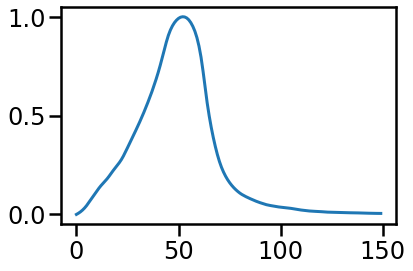

In [3]:
plt.plot(np.load('odor_kernel_50ms.npy'))

In [4]:
path = os.getcwd() + '/Session/'
savepath = os.getcwd() + '/Figures/test/'
savepath_pdf = os.getcwd() + '/Figures/test/pdf/'
savepath_png = os.getcwd() + '/Figures/test/png/'
savepath_svg = os.getcwd() + '/Figures/test/svg/'

dir_list = os.listdir(path)
np_savepath = os.getcwd() + '/Other_outputs/MLE_arrays/'

print(os.getcwd())


/Users/boero/OEA_Data_Analysis


In [20]:
cmap_3

[(0.16914226, 0.10805832, 0.20589698),
 (0.24423453, 0.20678459, 0.41985299),
 (0.23318874, 0.33648036, 0.59775543),
 (0.20692679, 0.48201774, 0.63812656),
 (0.20795035, 0.62210845, 0.66867802),
 (0.29215894, 0.76144162, 0.67886578),
 (0.60028928, 0.86793835, 0.71523675)]

In [3]:
### Establishing color palettes
animal_list = [['Tabby']]#,
            #    ['Bengal'],
            #    ['Shorthair'],
            #    ['Banner'],
            #    ['Natasha'],
            #    ['Stark'],
            #    ['Peterparker']]

c_2 = plt.cm.get_cmap('RdPu')
cmap = plt.get_cmap("tab10")
cmap_2 = sns.color_palette("rocket", 7)
cmap_3 = sns.color_palette("mako", 7)
cmap_4 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)(np.linspace(0, 0.75, len(animal_list)))
cmap_5 = sns.color_palette("rocket_r", as_cmap=True)(np.linspace(0.1, 0.8, len(animal_list)))
cmap_6 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)(np.linspace(0, 0.8, 5))
cmap_7 = sns.color_palette("YlGn", 10)
cmap_8 = sns.color_palette("bone_r", 10)
cmap_9 = sns.color_palette("tab20", 12)
cmap_10 = sns.color_palette('bright',10)
cmap_11 = sns.color_palette('plasma',10)

greys = sns.color_palette("Greys", 10)
colors = plt.cm.get_cmap('BuGn')(np.linspace(0.4, 1, len(animal_list)))
blue_palette = sns.dark_palette(cmap(0),n_colors=9, reverse=True)
orange_palette = sns.dark_palette(cmap(1),n_colors=9, reverse=True)
red_palette = sns.dark_palette(cmap(3),n_colors=12, reverse=True)

cmap_12 = sns.choose_dark_palette()
glom_palette = sns.cubehelix_palette(start=0, hue = .9, light = 0.8, dark=0.15, gamma=0.9, rot=-0.4, as_cmap=True)
glom_palette_2 = sns.cubehelix_palette(n_colors=18, start=0, hue = .9, light = 0.8, dark=0.15, gamma=0.9, rot=-0.4)#, as_cmap=True)
wistia_palette = sns.color_palette('Wistia', 10)
glom_p = glom_palette_2[::-1]


interactive(children=(IntSlider(value=179, description='h', max=359), IntSlider(value=49, description='s', max…

In [6]:
cmap_9

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451)]

In [31]:
# Compute psychometrics of each animal
num_bins = 20
half_num_bins = 8
min_pulse = 1
max_pulse = 20
num_hist = 6
pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)

phigh_list = list()
performance_list = list()
bin_counts_list = list()
phigh_hist_list = list()
performance_hist_list = list()
bin_counts_hist_list = list()
all_high_choices_list = list()
all_cum_odor_list = list()
all_cum_conv_odor_list = list()
all_correct_trials_list = list()
all_sniff_durations_list = list()
all_sniff_hist_list = list()
all_sniff_hist_shuffled_list = list()
all_coef_vars_list = list()

all_high_choices_hist_list = list()
all_cum_odor_hist_list = list()
all_correct_trials_hist_list = list()
all_sniff_durations_hist_list = list()
all_sniff_hist_h_list = list()
all_sniff_hist_shuffled_h_list = list()
all_previous_trial_list = list()
all_trial_odor_list = list()
all_trials_odor_onsets_list = list()
autocorr_list = list()
all_session_id_list = list()
all_breathing_list = list()

animal_list = [['Bengal'],
                ['Tabby']]#,
            #    ['Shorthair'],
            #    ['Banner'],
            #    ['Natasha'],
            #    ['Stark'],
            #    ['Peterparker']]

for animals in animal_list:
    fname_list = list()

    for date_number in range(20190419,20220526):    
        for animal in animals:
            #print(animal)
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'
                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    #print(fname)
                    fname_list.append(fname)
                    

    num_all_trials = 0
    
    all_trial_odor = np.zeros((0,5000))
    all_trial_odor_onsets =  np.zeros((0,))
    all_conv_weights = np.zeros((0,5000))
    all_conv_odor = np.zeros((0,5000))
    all_cum_odor = np.zeros((0,))
    all_cum_conv_odor = np.zeros((0,))
    all_high_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_coef_vars = np.zeros((0,))
    all_correct_trials = np.zeros((0,))
    all_session_id =  np.zeros((0,))
    all_sniff_durations = np.zeros(0,)
    all_sniff_hist = np.zeros((0,15)) #15
    all_sniff_hist_shuffled = np.zeros((0,15)) #15
    
    all_trial_odor_hist = np.zeros((0,5000))
    all_cum_odor_hist = np.zeros((0,))
    all_high_trials_hist = np.zeros((0,))
    all_high_choices_hist = np.zeros((0,))
    all_correct_trials_hist = np.zeros((0,))
    all_sniff_durations_hist = np.zeros(0,)
    all_sniff_hist_h = np.zeros((0,15)) #15
    all_sniff_hist_shuffled_h = np.zeros((0,15)) #15
    all_previous_trials = np.zeros((0,num_hist))
    all_breathing = np.zeros((0,9000))
    #all_breathing = list()
    
    for i_file in tnrange(len(fname_list)):
        
        session_id = 0
        fname = fname_list[i_file]
        print(fname)
        session_fname = path + 'session_' + fname
        if os.path.isfile(session_fname):
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                if session_list[0]['type'] == 'random':
                    if session_list[0]['delay_time'] == 5:
                        if round(session_list[0]['high_count']/session_list[0]['low_count']) == 3:
                            #if session_list[0]['low_count'] < 5:

                            num_trials = session['num_trials']
                            sess_id = np.repeat(fname[:-7], num_trials)
                            autocorr_list.append(get_autocorr(session,num_hist))
                            
                            session['conv_trial_odor'],session['conv_weights'] = get_conv_odor(session)
                            session['sniff_durations'] = get_sniff_durations(session)
                            non_idle_trials = np.invert(session['idle_trials'])
                            #print(len(non_idle_trials))
                            correct_trials = session['correct_trials'][non_idle_trials]
                            #print(len(correct_trials))

                            high_trials = session['high_trials'][non_idle_trials]
                            low_trials = session['low_trials'][non_idle_trials]
                            session_name = sess_id[non_idle_trials]
                            high_choices = (correct_trials==high_trials)
                            trial_odor = session['trial_odor'][non_idle_trials]
                            
                            breathing_signal = np.append(session['trial_pre_breath'][non_idle_trials, -2500:], session['trial_breath'][non_idle_trials, :6500], axis=1)
                            sniff_durations = session['sniff_durations'][non_idle_trials]
                            
                            sniff_durations = sniff_durations[sniff_durations>0] 
                            #pasting all the sniff durations of the session in just one array
                            sniff_hist = get_sniff_histogram(session,False)[non_idle_trials]
                            odor_onset = find_odor_onset_new(trial_odor)#.astype(np.float)
                            coef_var  = get_blanks_duration(odor_onset)[1]
                            sniff_hist_shuffled = get_sniff_histogram(session,True)[non_idle_trials]
                            cum_odor = np.ceil(trial_odor.sum(axis=1)/5000)
                            num_trials_taken = len(high_trials) - num_hist
                            previous_ind = np.arange(num_trials_taken).reshape(-1,1)+np.arange(0,num_hist)
                            previous_trials = high_choices[previous_ind]
                            
                            all_session_id = np.append(all_session_id, session_name)
                            all_trial_odor = np.append(all_trial_odor, trial_odor[:,:5000], axis=0)
                            all_breathing = np.append(all_breathing, breathing_signal[:,:11500], axis=0)
                            all_trial_odor_onsets = np.append(all_trial_odor_onsets, odor_onset)
                            all_trial_odor_hist = np.append(all_trial_odor_hist, trial_odor[num_hist:,:5000], axis=0)
                            all_correct_trials = np.append(all_correct_trials,correct_trials)
                            all_correct_trials_hist = np.append(all_correct_trials_hist,correct_trials[num_hist:])
                            all_high_trials = np.append(all_high_trials,high_trials)
                            all_high_trials_hist = np.append(all_high_trials_hist,high_trials[num_hist:])
                            all_high_choices = np.append(all_high_choices,high_choices)
                            all_coef_vars = np.append(all_coef_vars, coef_var)
                            all_high_choices_hist = np.append(all_high_choices_hist,high_choices[num_hist:])
                            all_cum_odor = np.append(all_cum_odor,cum_odor)
                            all_cum_odor_hist = np.append(all_cum_odor_hist,cum_odor[num_hist:])
                            all_sniff_durations = np.append(all_sniff_durations,sniff_durations)
                            all_sniff_durations_hist = np.append(all_sniff_durations_hist,sniff_durations[num_hist:])
                            all_sniff_hist = np.append(all_sniff_hist,sniff_hist,axis=0)
                            all_sniff_hist_h = np.append(all_sniff_hist_h,sniff_hist[num_hist:],axis=0)
                            all_sniff_hist_shuffled = np.append(all_sniff_hist_shuffled,sniff_hist_shuffled,axis=0)
                            all_sniff_hist_shuffled_h = np.append(all_sniff_hist_shuffled_h,sniff_hist_shuffled[num_hist:],axis=0)
                            all_previous_trials = np.append(all_previous_trials,previous_trials,axis=0)
                            #print(len(all_cum_odor))
                            #print(len(all_cum_odor_hist))

        high_seven = all_cum_odor>8
        low_eight = all_cum_odor<=8
        high_seven_hist = all_cum_odor_hist>8
        low_eight_hist = all_cum_odor_hist<=8
        print(len(high_seven), len(all_high_trials))
        all_low_trials = np.invert(all_high_trials.astype(np.bool))
        all_low_trials_hist = np.invert(all_high_trials_hist.astype(np.bool))
        bad_trials_1 = np.logical_and(high_seven,all_low_trials)
        bad_trials_2 = np.logical_and(low_eight,all_high_trials)
        bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
        good_trials = np.invert(bad_trials)
        bad_trials_hist_1 = np.logical_and(high_seven_hist,all_low_trials_hist)
        bad_trials_hist_2 = np.logical_and(low_eight_hist,all_high_trials_hist)
        bad_trials_hist = np.logical_or(bad_trials_hist_1,bad_trials_hist_2)
        good_trials_hist = np.invert(bad_trials_hist)
        
        print(len(good_trials))
        #print(len(good_trials_hist))
        
        all_correct_trials = all_correct_trials[good_trials]
        all_correct_trials_hist = all_correct_trials_hist[good_trials_hist]
        all_high_trials = all_high_trials[good_trials]
        all_high_trials_hist = all_high_trials_hist[good_trials_hist]
        all_low_trials = all_low_trials[good_trials]
        all_low_trials_hist = all_low_trials_hist[good_trials_hist]
        all_high_choices = all_high_choices[good_trials]
        all_coef_vars = all_coef_vars[good_trials]
        all_cum_odor = all_cum_odor[good_trials]
        all_trial_odor = all_trial_odor[good_trials,:]
        all_trial_odor_onsets = all_trial_odor_onsets[good_trials]
        all_session_id = all_session_id[good_trials]
        all_breathing = all_breathing[good_trials]

        all_sniff_hist = all_sniff_hist[good_trials,:]
        all_sniff_hist_shuffled = all_sniff_hist_shuffled[good_trials,:]
        all_high_choices_hist = all_high_choices_hist[good_trials_hist]
        all_cum_odor_hist = all_cum_odor_hist[good_trials_hist]
        all_trial_odor_hist = all_trial_odor_hist[good_trials_hist,:]
        all_sniff_hist_h = all_sniff_hist_h[good_trials_hist,:]
        all_sniff_hist_shuffled_h = all_sniff_hist_shuffled_h[good_trials_hist,:]
        all_previous_trials = all_previous_trials[good_trials_hist,:]


        #print(session_ids)
    
    #np.save('sniff_analysis_correct/' + animals[0] + '_' + 'conv_odor.npy', all_conv_odor)
    # np.save(os.getcwd() +'/Other_outputs/sniff_analysis_correct/' + animals[0] + '_' + 'all_high_trials.npy', all_high_trials_hist)
    # np.save(os.getcwd() +'/Other_outputs/sniff_analysis_correct/' + animals[0] + '_' + 'all_high_choices.npy', all_high_choices_hist)
    # np.save(os.getcwd() +'/Other_outputs/sniff_analysis_correct/' + animals[0] + '_' + 'all_true_pulses_number.npy', all_cum_odor_hist)
    # np.save(os.getcwd() +'/Other_outputs/sniff_analysis_correct/' + animals[0] + '_' + 'all_odor_commands.npy', all_trial_odor_hist)
    #np.save('sniff_analysis_correct/' + animals[0] + '_' + 'all_conv_weights.npy', all_conv_weights)
    all_correct_trials_list.append(all_correct_trials)
    all_coef_vars_list.append(all_coef_vars)
    all_high_choices_list.append(all_high_choices)
    all_cum_odor_list.append(all_cum_odor)
    #all_cum_conv_odor_list.append(all_cum_conv_odor)
    all_sniff_durations_list.append(all_sniff_durations)
    all_sniff_hist_list.append(all_sniff_hist)
    all_sniff_hist_shuffled_list.append(all_sniff_hist_shuffled)
    all_previous_trial_list.append(all_previous_trials)
    all_trials_odor_onsets_list.append(all_trial_odor_onsets)
    all_trial_odor_list.append(all_trial_odor)
    all_session_id_list.append(all_session_id)
    all_breathing_list.append(all_breathing)
    
    all_correct_trials_hist_list.append(all_correct_trials_hist)
    all_high_choices_hist_list.append(all_high_choices_hist)
    all_cum_odor_hist_list.append(all_cum_odor_hist)
    #all_cum_conv_odor_list.append(all_cum_conv_odor)
    all_sniff_durations_hist_list.append(all_sniff_durations_hist)
    all_sniff_hist_h_list.append(all_sniff_hist_h)
    all_sniff_hist_shuffled_h_list.append(all_sniff_hist_shuffled_h)    
    phigh = np.zeros((num_bins,2))
    performance = np.zeros((num_bins,2))
    phigh_hist = np.zeros((num_bins,2))
    performance_hist = np.zeros((num_bins,2))
    bin_counts = np.zeros((num_bins,))
    bin_counts_h = np.zeros((num_bins,))

    pulse_bin_ind = np.ceil(all_cum_odor).astype(np.int)
    pulse_bin_ind_h = np.ceil(all_cum_odor_hist).astype(np.int)
 
    for i in range(num_bins):
        selected = all_high_choices[pulse_bin_ind==pulse_bins[i]]
        selected_hist = all_high_choices_hist[pulse_bin_ind_h==pulse_bins[i]]
        selected_correct = all_correct_trials[pulse_bin_ind==pulse_bins[i]]
        selected_correct_hist = all_correct_trials_hist[pulse_bin_ind_h==pulse_bins[i]]
        num_selected = len(selected)
        num_selected_h = len(selected_hist)
        bin_counts[i] = num_selected
        bin_counts_h[i] = num_selected_h
        phigh[i,0] = selected.mean()
        phigh_hist[i,0] = selected_hist.mean()
        phigh[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
        phigh_hist[i,1] = 1.96*selected.std()/np.sqrt(num_selected_h)
        performance[i,0] = selected_correct.mean()
        performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)
        performance_hist[i,0] = selected_correct_hist.mean()
        performance_hist[i,1] = 1.96*selected_correct_hist.std()/np.sqrt(num_selected_h)
    phigh_list.append(phigh)
    performance_list.append(performance)
    bin_counts_list.append(bin_counts)
    phigh_hist_list.append(phigh_hist)
    performance_hist_list.append(performance_hist)
    bin_counts_hist_list.append(bin_counts_h)
autocorr_mat = np.array(autocorr_list)


  0%|          | 0/22 [00:00<?, ?it/s]

Bengal_20190419_0.pickle
249 249
249
Bengal_20190422_0.pickle
482 482
482
Bengal_20190423_0.pickle
697 697
697
Bengal_20190426_0.pickle
937 937
937
Bengal_20190427_0.pickle
1155 1155
1155
Bengal_20190430_0.pickle
1478 1478
1478
Bengal_20190501_0.pickle
1738 1738
1738
Bengal_20190502_0.pickle
1971 1971
1971
Bengal_20190503_0.pickle
2340 2340
2340
Bengal_20190504_0.pickle
2547 2547
2547
Bengal_20190505_0.pickle
2759 2759
2759
Bengal_20190507_0.pickle
2865 2865
2865
Bengal_20190508_0.pickle
3131 3131
3131
Bengal_20190509_0.pickle
3377 3377
3377
Bengal_20190510_0.pickle
3637 3637
3637
Bengal_20190511_0.pickle
3916 3916
3916
Bengal_20190512_0.pickle
4143 4143
4143
Bengal_20190513_0.pickle
4393 4393
4393
Bengal_20190516_0.pickle
4554 4554
4554
Bengal_20190517_0.pickle
4807 4807
4807
Bengal_20190518_0.pickle
5098 5098
5098
Bengal_20190519_0.pickle
5328 5328
5328


  0%|          | 0/18 [00:00<?, ?it/s]

Tabby_20190419_0.pickle
176 176
176
Tabby_20190423_0.pickle
344 344
344
Tabby_20190426_0.pickle
514 514
514
Tabby_20190427_0.pickle
745 745
745
Tabby_20190430_0.pickle
1066 1066
1066
Tabby_20190501_0.pickle
1403 1403
1403
Tabby_20190503_0.pickle
1600 1600
1600
Tabby_20190504_0.pickle
1752 1752
1752
Tabby_20190505_0.pickle
1928 1928
1928
Tabby_20190510_0.pickle
2249 2249
2249
Tabby_20190511_0.pickle
2549 2549
2549
Tabby_20190512_0.pickle
2829 2829
2829
Tabby_20190513_0.pickle
3151 3151
3151
Tabby_20190514_0.pickle
3484 3484
3484
Tabby_20190516_0.pickle
3635 3635
3635
Tabby_20190517_0.pickle
3913 3913
3913
Tabby_20190518_0.pickle
4137 4137
4137
Tabby_20190519_0.pickle
4388 4388
4388


In [64]:
import numpy as np

# Example list of histograms (assume bins are uniform across histograms)
# Each histogram is a tuple (counts, bin_edges)
histograms = [
    (np.array([10, 20, 30, 40, 50, 60, 70, 80]), np.linspace(0, 8, 9)),
    (np.array([80, 70, 60, 50, 40, 30, 20, 10]), np.linspace(0, 8, 9)),
    (np.array([15, 25, 35, 45, 55, 65, 75, 85]), np.linspace(0, 8, 9)),
]

# Function to compute sorting key
def half_difference(hist):
    counts, _ = hist
    mid = len(counts) // 2
    first_half_sum = np.sum(counts[:mid])
    last_half_sum = np.sum(counts[mid:])
    return first_half_sum - last_half_sum

# Sort histograms based on the key
sorted_histograms = sorted(histograms, key=half_difference)

# Print results
for i, (counts, bin_edges) in enumerate(sorted_histograms):
    print(f"Histogram {i}: counts={counts}, difference={half_difference((counts, bin_edges))}")


Histogram 0: counts=[10 20 30 40 50 60 70 80], difference=-160
Histogram 1: counts=[15 25 35 45 55 65 75 85], difference=-160
Histogram 2: counts=[80 70 60 50 40 30 20 10], difference=160


In [44]:
print(type(all_high_trials_list[0][:10]))

NameError: name 'all_high_trials_list' is not defined

Histogram 0: counts=[0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 3. 4. 4. 3.], difference=-12.0
Histogram 1: counts=[0. 2. 0. 1. 1. 0. 0. 4. 2. 2. 1. 3. 2. 1. 1.], difference=-12.0
Histogram 2: counts=[0. 0. 1. 0. 0. 0. 0. 1. 3. 2. 0. 2. 1. 3. 1.], difference=-12.0
Histogram 3: counts=[0. 0. 0. 2. 0. 1. 0. 0. 1. 2. 4. 1. 4. 0. 2.], difference=-11.0
Histogram 4: counts=[0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 2. 4. 1. 4. 1.], difference=-11.0
Histogram 5: counts=[0. 0. 1. 0. 0. 0. 0. 1. 4. 2. 0. 0. 2. 1. 2.], difference=-11.0
Histogram 6: counts=[2. 1. 1. 0. 0. 0. 0. 0. 0. 2. 1. 0. 7. 4. 1.], difference=-11.0
Histogram 7: counts=[0. 0. 2. 0. 0. 0. 0. 3. 0. 5. 1. 3. 1. 0. 0.], difference=-11.0
Histogram 8: counts=[1. 0. 0. 3. 0. 0. 0. 4. 0. 3. 1. 0. 1. 2. 4.], difference=-11.0
Histogram 9: counts=[0. 2. 1. 1. 0. 0. 0. 0. 3. 1. 1. 2. 3. 1. 3.], difference=-10.0
Histogram 10: counts=[0. 0. 1. 0. 0. 1. 0. 1. 5. 2. 2. 0. 1. 1. 0.], difference=-10.0
Histogram 11: counts=[0. 1. 0. 1. 0. 1. 0. 2. 3. 1. 2. 2. 0. 2. 

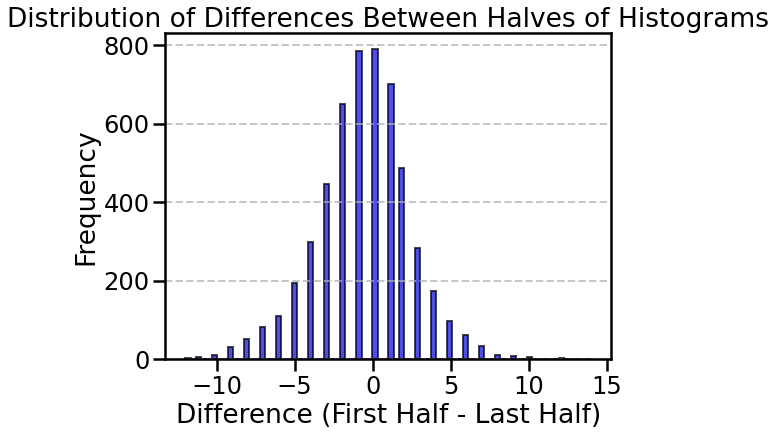

In [71]:
all_sniff_hist_list[1]

# Function to compute sorting key
def half_difference(counts):
    mid = len(counts) // 2
    first_half_sum = np.sum(counts[:mid])
    last_half_sum = np.sum(counts[mid:])
    return first_half_sum - last_half_sum

# Sort histograms based on the key
sorted_histograms = sorted(all_sniff_hist_list[1], key=half_difference)

# Print results
for i, counts in enumerate(sorted_histograms):
    print(f"Histogram {i}: counts={counts}, difference={half_difference(counts)}")

differences = [half_difference(hist) for hist in all_sniff_hist_list[1]]

# Plot the differences as a histogram
plt.figure(figsize=(8, 6))
plt.hist(differences, bins='auto', color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Differences Between Halves of Histograms')
plt.xlabel('Difference (First Half - Last Half)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [25]:
print(len(all_correct_trials_list[0]))
print(len(all_high_choices_list[0]))
print(len(all_cum_odor_list[0]))
print(len(all_trials_odor_onsets_list[0]))
#print(len(all_sniff_durations_list[0]))
#print(len(all_correct_trials_list[0][30:40]))
#print(len(all_correct_trials_list[0][30:40]))

#print(all_correct_trials_list[0][10:30])
#print(all_high_choices_list[0][10:30])
print(all_cum_odor_list[0][10:30])
print(all_high_choices_list[0][10:30])
print(all_correct_trials_list[0][10:30])

print(all_trials_odor_onsets_list[0][20:30])



5327
5327
5327
5327
[ 3. 13. 15. 12. 12. 14.  4. 17. 12. 10. 12. 14.  6. 17.  3.  6.  4. 15.
 12. 13.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]
[list([383, 386, 886, 1054, 1366, 1616, 2155, 3039, 3890, 4195, 4472, 4996])
 list([35, 114, 325, 471, 1327, 1920, 2223, 2518, 2660, 3322, 3504, 4493, 4936])
 list([2658, 2966, 3385, 3796, 4287, 4357])
 list([366, 533, 769, 958, 1349, 1417, 1460, 1691, 2061, 2125, 2174, 2797, 3234, 4049, 4243, 4784, 4831])
 list([1673, 1788, 2272]) list([170, 650, 974, 2905, 3232, 3772])
 list([164, 923, 1024, 4738])
 list([13, 983, 1234, 1353, 1577, 1683, 1963, 2088, 2475, 3526, 3881, 4039, 4197, 4328, 4735])
 list([279, 424, 1246, 1616, 1717, 2184, 2494, 2986, 3205, 3410, 3894, 4826])
 list([64, 325, 668, 905, 1001, 1255, 1362, 2091, 2405, 3804, 4456, 4504, 4650])]


In [51]:
len(all_correct_trials_list[0])

4381

In [25]:
arr=np.array([1,2,3])
data = { 'A':[10,20], 'B':[arr, np.array([4,5,6])]}
dfdf = pd.DataFrame(data)
print(dfdf['B'].mean(0))
dfdf


[2.5 3.5 4.5]


A          B
0  10  [1, 2, 3]
1  20  [4, 5, 6]

[list([690, 2279, 3310, 3777, 4798])
 list([452, 941, 1380, 2098, 2163, 2188, 3905]) list([223, 2195, 2581])
 ... list([991, 2273, 2317, 3043, 3314, 4327]) list([1593, 2971, 4027])
 list([147, 901, 1146, 1195, 1427, 3128, 3319, 4160, 4179, 4244, 4609])]
Histogram: [34601 34581 34358 34781 34582]


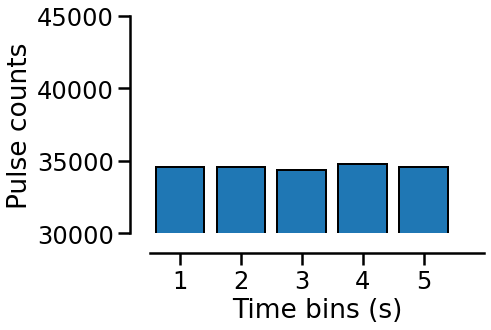

In [46]:
print(all_trials_odor_onsets_list[1])

#import numpy as np

# Example array
arr = np.array([[[1, 2, 3], [4, 5, 6]],
                [[7, 8, 9], [10, 11, 12]],
                [[13, 14, 15], [16, 17, 18]]])

# Flatten the array
flattened_arr = np.concatenate([np.concatenate(row) for row in all_trials_odor_onsets_list])

# Now you can run a histogram on the flattened array
histogram = np.histogram(flattened_arr, bins=5)[0]

plt.bar(np.arange(0,5), histogram, edgecolor='k', align='center')
plt.xticks(np.arange(0,5), np.arange(1,6))
plt.ylim(30000,45000)
plt.xlim(-0.5,5)
plt.ylabel('Pulse counts')
plt.xlabel('Time bins (s)')

print("Histogram:", histogram)
sns.despine(offset=20)

#fig.savefig(savepath_svg + 'Histogram_of_pulses_per_bin_5s_1to3.svg',transparent=True, format='svg', bbox_inches='tight')
#fig.savefig(savepath_png + 'Histogram_of_pulses_per_bin_5s_1to3.png',transparent=True, format='png', bbox_inches='tight')
#fig.savefig(savepath_pdf + 'Histogram_of_pulses_per_bin_5s_1to3.pdf',transparent=True, format='pdf', bbox_inches='tight')

plt.show()


In [180]:




namber = 503

print(all_trials_odor_onsets_list[1][namber])
test_array = np.insert(all_trials_odor_onsets_list[1][namber], 0, 0)
test_array = np.insert(test_array, len(test_array), 5000, axis=0)
print(test_array)
print(np.diff(test_array))
print(np.diff(test_array).std()/np.diff(test_array).mean())

[2081, 2119, 2131, 2712, 2732, 2762, 2909, 3147, 3424, 3459, 3474, 4056, 4252, 4733, 4879]
[   0 2081 2119 2131 2712 2732 2762 2909 3147 3424 3459 3474 4056 4252
 4733 4879 5000]
[2081   38   12  581   20   30  147  238  277   35   15  582  196  481
  146  121]
1.5817762167892144


In [219]:
# get_blanks_duration(all_trials_odor_onsets_list[1][503])
print(all_trials_odor_onsets_list[1][503])

get_blanks_duration(all_trials_odor_onsets_list[1][503])

[2081, 2119, 2131, 2712, 2732, 2762, 2909, 3147, 3424, 3459, 3474, 4056, 4252, 4733, 4879]


(array([2081,   38,   12,  581,   20,   30,  147,  238,  277,   35,   15,
         582,  196,  481,  146,  121]),
 1.5817762167892144)

In [129]:
df = pd.DataFrame(np.concatenate(phigh_list, axis=0), columns=['Mean','SEM'])
df.insert(0, 'N Pulses', np.tile(np.arange(1, 21), len(df) // 7)[:len(df)])
df.insert(0, 'Plam bins', np.tile(calc_plam(pulse_bins,12.5,4.16667), len(df) // 7)[:len(df)])
df['row_number'] = df.reset_index().index
df['Animal'] = pd.Series(animal_list).apply(lambda s: s * len(phigh_list[0])).sum()
df['Upper'] = df['Mean']+df['SEM']
df['Lower'] = df['Mean']-df['SEM']
df.dropna()

Plam bins  N Pulses      Mean       SEM  row_number       Animal  \
0     0.000721         1  0.000000  0.000000           0        Tabby   
1     0.002159         2  0.015773  0.013716           1        Tabby   
2     0.006448         3  0.015837  0.011639           2        Tabby   
3     0.019098         4  0.051760  0.019758           3        Tabby   
4     0.055186         5  0.158192  0.038015           4        Tabby   
..         ...       ...       ...       ...         ...          ...   
133   0.999131        14  0.821429  0.081904         133  Peterparker   
134   0.999710        15  0.866667  0.076934         134  Peterparker   
135   0.999903        16  0.807692  0.107121         135  Peterparker   
136   0.999968        17  0.941176  0.111852         136  Peterparker   
137   0.999989        18  0.823529  0.181221         137  Peterparker   

        Upper     Lower  
0    0.000000  0.000000  
1    0.029489  0.002057  
2    0.027476  0.004198  
3    0.071518  0.032002  
4    0.196207  0.120177  
..        ...       ...  
133  0.903333  0.739524  
134  0.943601  0.789732  
135  0.914814  0.700571  
136  1.053028  0.829325  
137  1.004750  0.642309  

[129 rows x 8 columns]

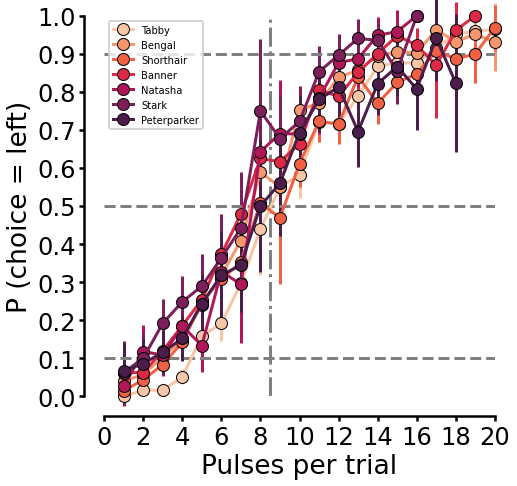

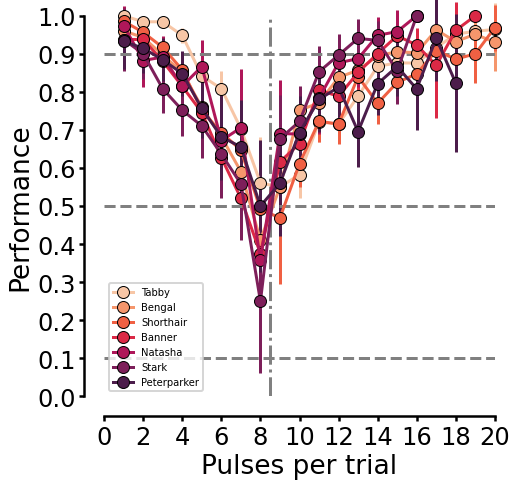

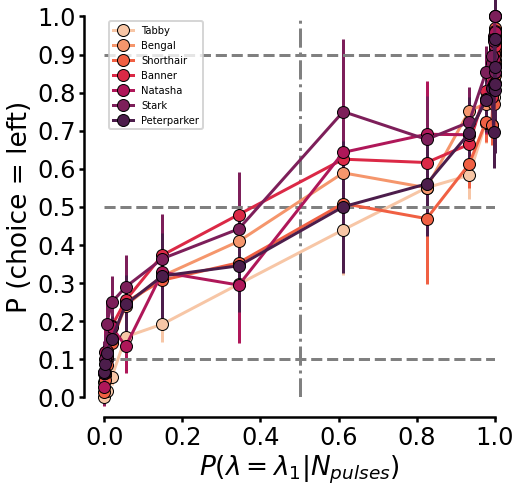

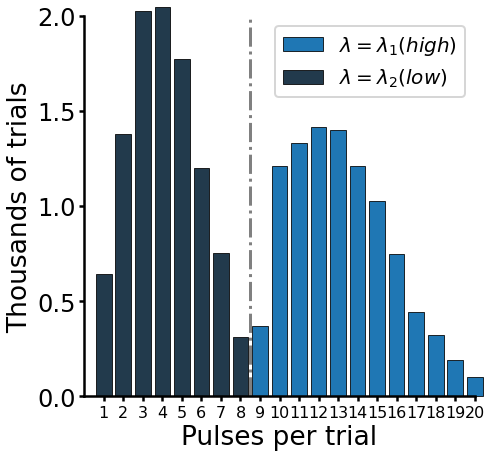

In [11]:
animals_legend = animal_list
fig = plt.figure(figsize=(7,7))

for i in range(len(phigh_list)):
    phigh = phigh_list[i]
    plt.errorbar(pulse_bins,y=phigh[0:20,0],yerr=phigh[0:20,1],
                 marker='o',color=cmap_5[i], markeredgecolor = 'black', clip_on=False)
    
plt.legend(['Tabby','Bengal','Shorthair','Banner','Natasha','Stark','Peterparker'],  prop={'size': 10})
plt.xlabel('Pulses per trial')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P (choice = left)')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,20)

plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True, offset=20)


fig.savefig(savepath_svg + 'behavior_summary_all_20.svg', transparent = True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'behavior_summary_all_20.png', transparent = True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'behavior_summary_all_20.pdf', transparent = True, format='pdf', bbox_inches='tight')

plt.show()

fig = plt.figure(figsize=(7,7))

for i in range(len(performance_list)):
    performance = performance_list[i]
    plt.errorbar(pulse_bins,y=performance[0:20,0],yerr=performance[0:20,1],
                 marker='o',color=cmap_5[i], markeredgecolor = 'black', clip_on=False)
    
plt.legend(['Tabby','Bengal','Shorthair','Banner','Natasha','Stark','Peterparker'],  prop={'size': 10})
plt.xlabel('Pulses per trial')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('Performance')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,20)

plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True, offset=20)


# fig.savefig(savepath_svg + 'behavior_summary_all_20.svg', transparent = True, format='svg', bbox_inches='tight')
# fig.savefig(savepath_png + 'behavior_summary_all_20.png', transparent = True, format='png', bbox_inches='tight')
# fig.savefig(savepath_pdf + 'behavior_summary_all_20.pdf', transparent = True, format='pdf', bbox_inches='tight')

plt.show()


plam_bins = calc_plam(pulse_bins,12.5,4.16667)

fig = plt.figure(figsize=(7,7))

for i in range(len(phigh_list)):
    phigh = phigh_list[i]
    plt.errorbar(plam_bins,y=phigh[:,0],yerr=phigh[:,1],marker='o',
                 markeredgecolor= 'black', color=cmap_5[i], clip_on=False)
plt.xlabel('$P(\lambda=\lambda_1|N_{pulses})$')
plt.legend(['Tabby','Bengal','Shorthair','Banner','Natasha','Stark','Peterparker'],  prop={'size': 10})
#plt.grid(False)
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=0.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P (choice = left)')
plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True, offset=20)
fig.savefig(savepath_svg + 'p_observed_vs_expected_poisson.svg', transparent = True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'p_observed_vs_expected_poisson.png', transparent = True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'p_observed_vs_expected_poisson.pdf', transparent = True, format='pdf', bbox_inches='tight')

plt.show()

fig = plt.figure(figsize=(7,7))

#plt.subplot(1,2,1)

bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[half_num_bins:],bin_counts[half_num_bins:]/1000,color=blue_palette[0], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.bar(pulse_bins[:half_num_bins],bin_counts[:half_num_bins]/1000,color=blue_palette[6], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.legend(['$\lambda=\lambda_1(high)$','$\lambda=\lambda_2(low)$'], fontsize=20)
plt.grid(False)
plt.xlim(0,20)
plt.ylim(0,2)

plt.xticks(np.linspace(1,20,20), fontsize = 16)#, rotation=70)
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('Pulses per trial')
plt.ylabel('Thousands of trials')
plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True)
# fig.savefig(savepath_svg + 'Histogram_of_trials_5s_1to3.svg',transparent=True, format='svg', bbox_inches='tight')
# fig.savefig(savepath_png + 'Histogram_of_trials_5s_1to3.png',transparent=True, format='png', bbox_inches='tight')
# fig.savefig(savepath_pdf + 'Histogram_of_trials_5s_1to3.pdf',transparent=True, format='pdf', bbox_inches='tight')

plt.show()

In [23]:
bin_counts_list[0]

array([147., 317., 442., 483., 354., 282., 155.,  66.,  40., 242., 283.,
       299., 322., 241., 218., 161., 119.,  83.,  49.,  28.])

19896.0


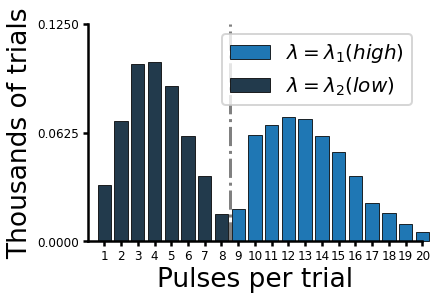

In [38]:
bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
print(bin_counts.sum())
plt.bar(pulse_bins[half_num_bins:],bin_counts[half_num_bins:]/bin_counts.sum(),color=blue_palette[0], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.bar(pulse_bins[:half_num_bins],bin_counts[:half_num_bins]/bin_counts.sum(),color=blue_palette[6], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.legend(['$\lambda=\lambda_1(high)$','$\lambda=\lambda_2(low)$'], fontsize=20)
plt.grid(False)
plt.xlim(0,20)
plt.ylim(0,0.125)

plt.xticks(np.linspace(1,20,20), fontsize = 12)#, rotation=70)
plt.yticks(np.linspace(0,0.125,3), fontsize = 12)#, rotation=70)

plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('Pulses per trial')
plt.ylabel('Thousands of trials')
plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True)
plt.savefig(savepath_svg + 'Histogram_fraction_of_trials_5s_1to3.svg',transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'Histogram_fraction_of_trials_5s_1to3.png',transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'Histogram_fraction_of_trials_5s_1to3.pdf',transparent=True, format='pdf', bbox_inches='tight')

plt.show()

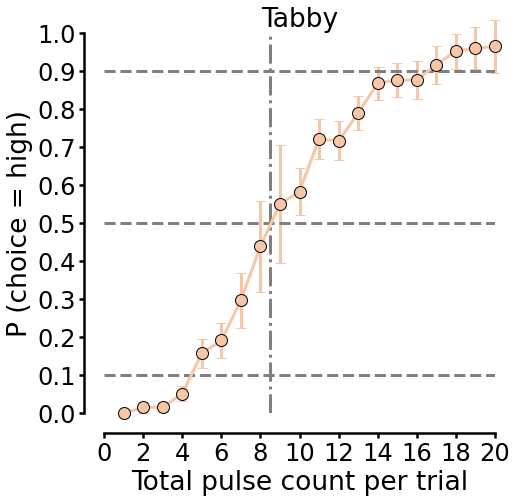

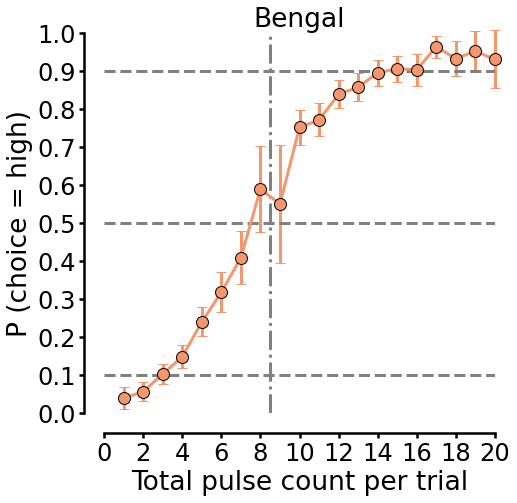

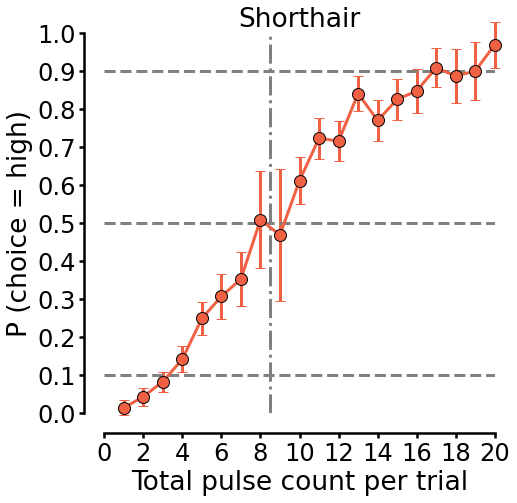

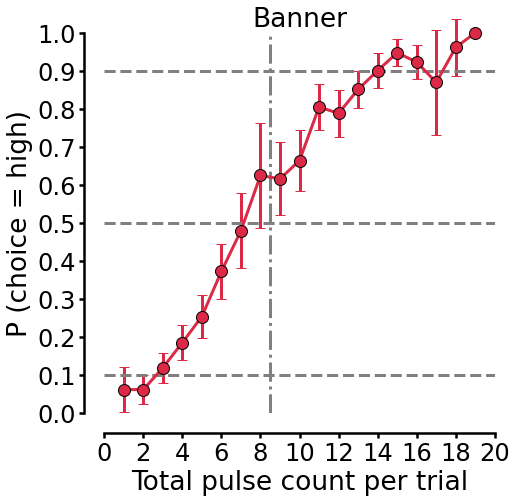

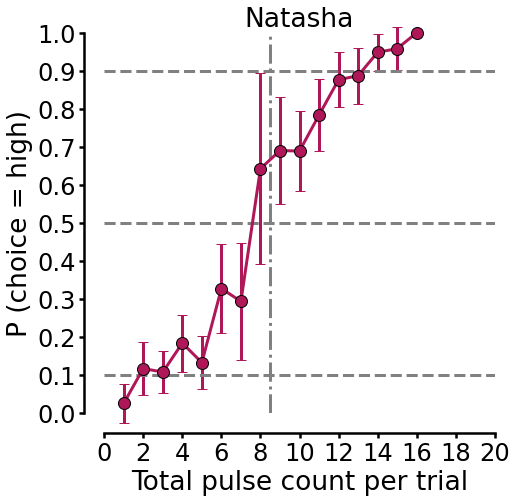

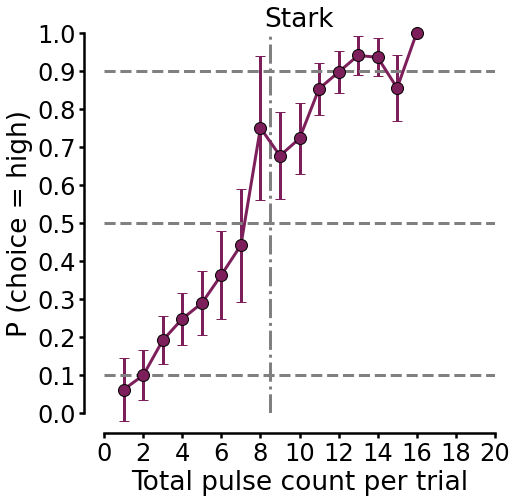

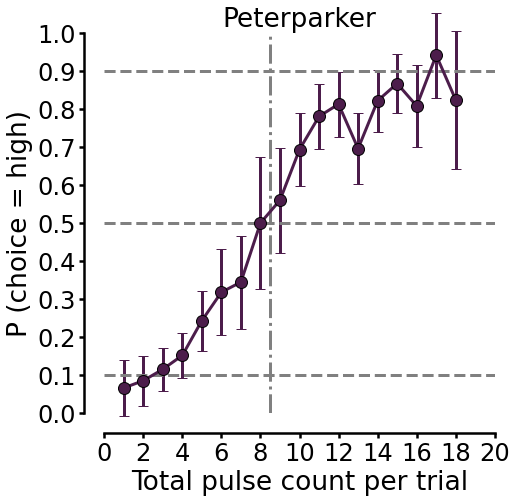

In [57]:
from itertools import chain
def flatten_comprehension(matrix):
    return list(chain.from_iterable(matrix))

for i in range(len(phigh_list)):
    plt.figure(figsize=(7,7))
    phigh = phigh_list[i]
    plt.errorbar(pulse_bins,y=phigh[0:20,0],yerr=phigh[0:20,1],
                 marker='o',color=cmap_5[i], markeredgecolor = 'black', capsize=5, clip_on=False)
    plt.axhline(y=0.1,color='gray',linestyle='--')
    plt.axhline(y=0.5,color='gray',linestyle='--')
    plt.axhline(y=0.9,color='gray',linestyle='--')
    plt.axvline(x=8.5,color='gray',linestyle='-.')
    plt.xlabel('Total pulse count per trial')
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.ylabel('P (choice = high)')
    plt.xticks(np.linspace(0,20,11))
    plt.xlim(0,20)
    plt.title(flatten_comprehension(animal_list)[i])
    plt.tick_params(axis='both', length=5, color='black', direction = 'out')
    sns.despine(right=True, top=True, offset=20)

    plt.savefig(savepath_svg + flatten_comprehension(animal_list)[i] + '_pscyhometric.svg',transparent=True, format='svg', bbox_inches='tight')
    plt.savefig(savepath_png + flatten_comprehension(animal_list)[i] + '_pscyhometric.png',transparent=True, format='png', bbox_inches='tight')
    plt.savefig(savepath_pdf + flatten_comprehension(animal_list)[i] + '_pscyhometric.pdf',transparent=True, format='pdf', bbox_inches='tight')

    #plt.show()

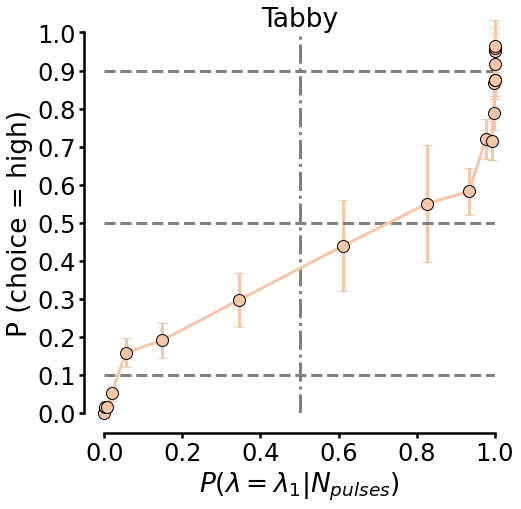

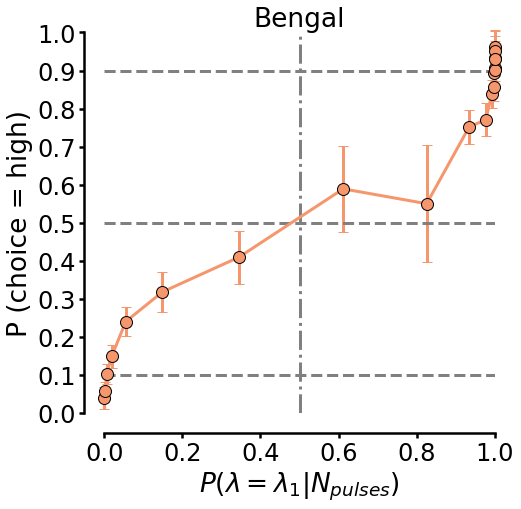

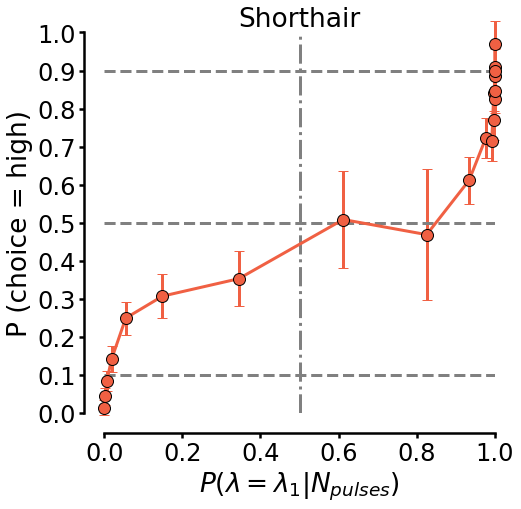

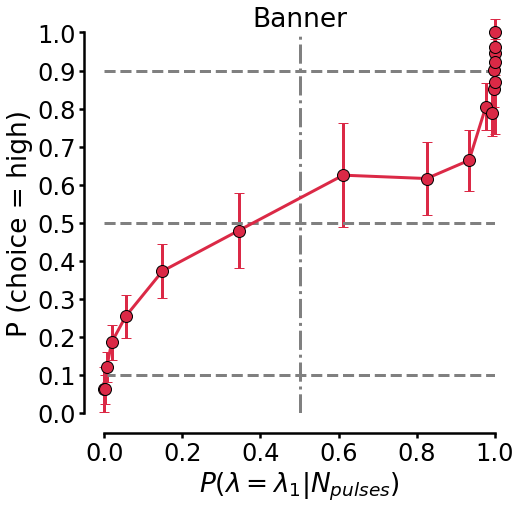

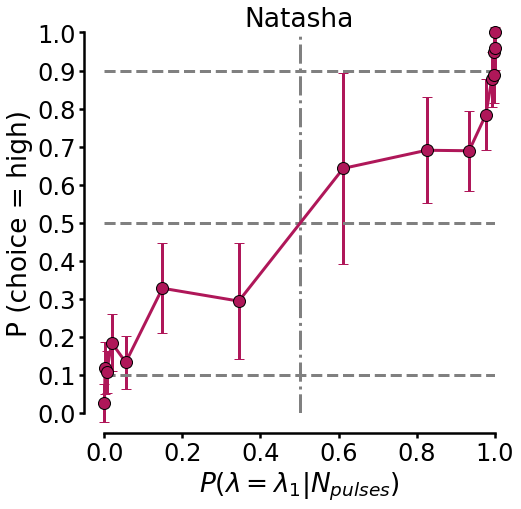

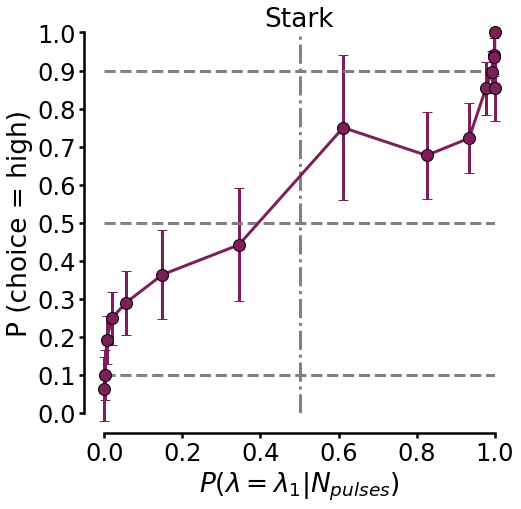

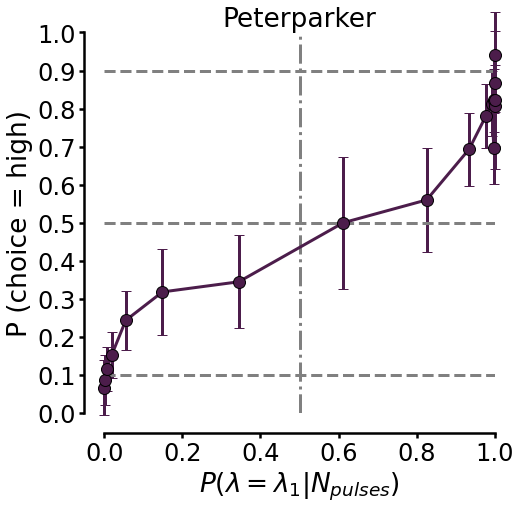

In [205]:
for i in range(len(phigh_list)):
    plt.figure(figsize=(7,7))
    phigh = phigh_list[i]
    plt.errorbar(plam_bins,y=phigh[:,0],yerr=phigh[:,1],
                 marker='o',color=cmap_5[i], markeredgecolor = 'black', capsize=5, clip_on=False)
    plt.axhline(y=0.1,color='gray',linestyle='--')
    plt.axhline(y=0.5,color='gray',linestyle='--')
    plt.axhline(y=0.9,color='gray',linestyle='--')
    plt.axvline(x=0.5,color='gray',linestyle='-.')
    plt.xlabel('$P(\lambda=\lambda_1|N_{pulses})$')
    
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.ylabel('P (choice = high)')
    plt.xticks(np.linspace(0,1,6))
    plt.xlim(0,1)
    plt.title(flatten_comprehension(animal_list)[i])
    plt.tick_params(axis='both', length=5, color='black', direction = 'out')
    sns.despine(right=True, top=True, offset=20)

    plt.savefig(savepath_svg + flatten_comprehension(animal_list)[i] + 'p_observed_vs_expected_poisson.svg',transparent=True, format='svg', bbox_inches='tight')
    plt.savefig(savepath_png + flatten_comprehension(animal_list)[i] + 'p_observed_vs_expected_poisson.png',transparent=True, format='png', bbox_inches='tight')
    plt.savefig(savepath_pdf + flatten_comprehension(animal_list)[i] + 'p_observed_vs_expected_poisson.pdf',transparent=True, format='pdf', bbox_inches='tight')

    plt.show()

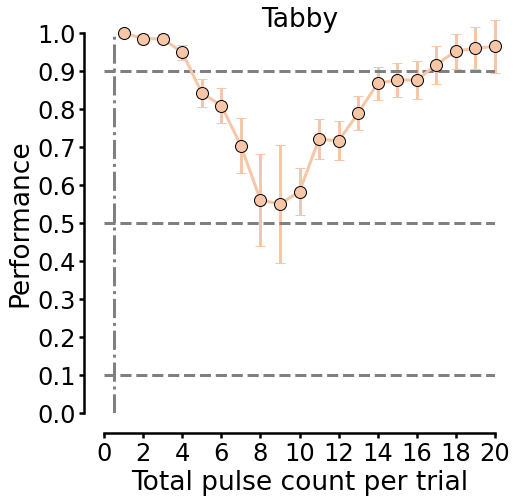

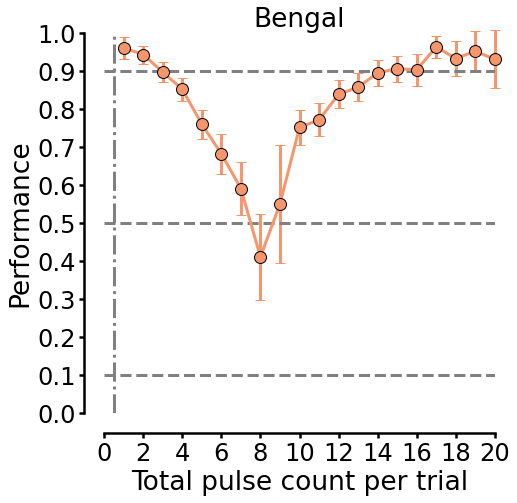

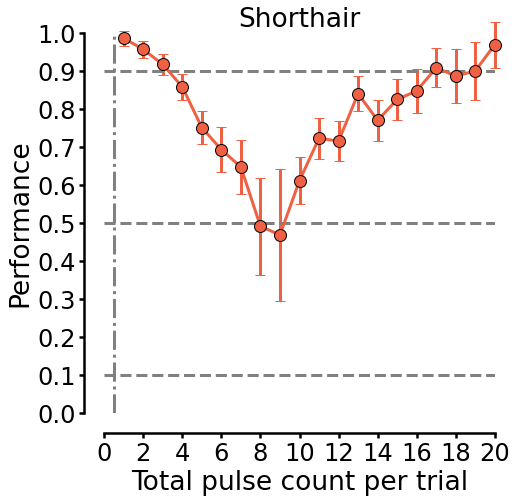

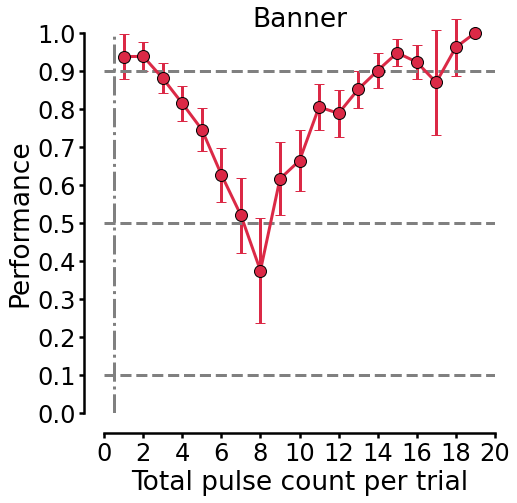

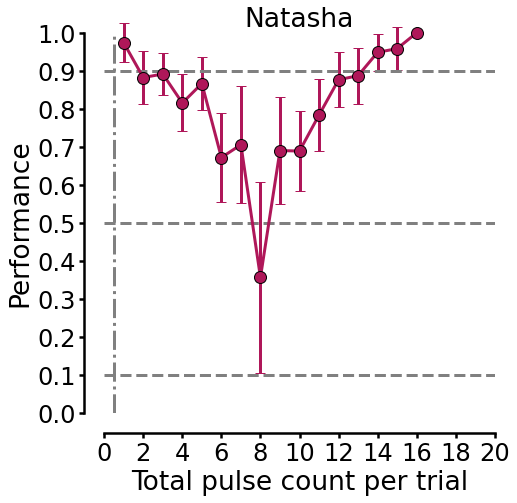

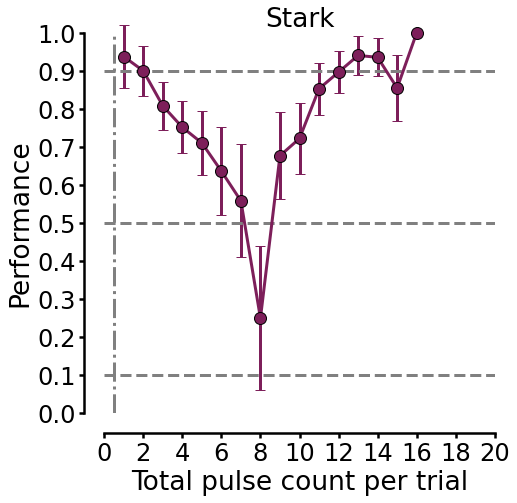

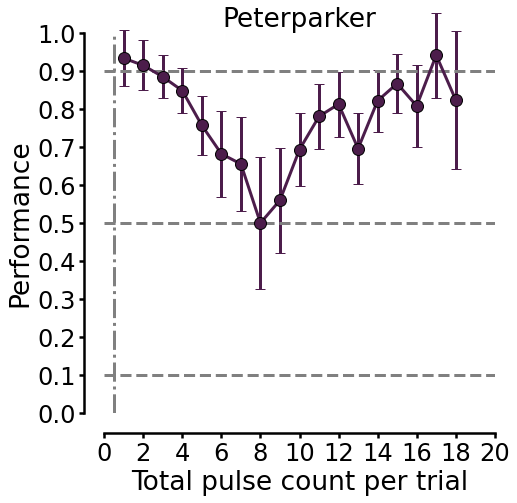

In [208]:
for i in range(len(phigh_list)):
    plt.figure(figsize=(7,7))
    a_performance = performance_list[i]
    plt.errorbar(pulse_bins,y=a_performance[:,0],yerr=a_performance[:,1],
                 marker='o',color=cmap_5[i], markeredgecolor = 'black', capsize=5, clip_on=False)
    plt.axhline(y=0.1,color='gray',linestyle='--')
    plt.axhline(y=0.5,color='gray',linestyle='--')
    plt.axhline(y=0.9,color='gray',linestyle='--')
    plt.axvline(x=0.5,color='gray',linestyle='-.')
    plt.xlabel('Total pulse count per trial')
    
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.ylabel('Performance')
    plt.xticks(np.linspace(0,20,11))
    plt.xlim(0,20)
    plt.title(flatten_comprehension(animal_list)[i])
    plt.tick_params(axis='both', length=5, color='black', direction = 'out')
    sns.despine(right=True, top=True, offset=20)

    plt.savefig(savepath_svg + flatten_comprehension(animal_list)[i] + 'performance.svg',transparent=True, format='svg', bbox_inches='tight')
    plt.savefig(savepath_png + flatten_comprehension(animal_list)[i] + 'performance.png',transparent=True, format='png', bbox_inches='tight')
    plt.savefig(savepath_pdf + flatten_comprehension(animal_list)[i] + 'performance.pdf',transparent=True, format='pdf', bbox_inches='tight')

    plt.show()

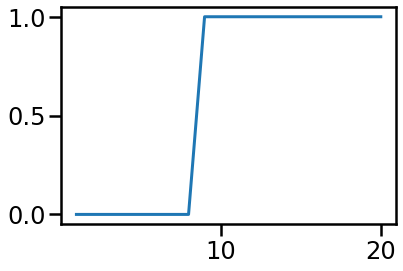

In [132]:
# psychometric function
def cum_gauss(x, alpha, beta, gamma, lambda_):
    return gamma + (lambda_ - gamma) / (1 + np.exp(-(x-alpha)/beta))

id_observer = cum_gauss(np.arange(1,21), 8.5, 0, 0, 1)
plt.plot(pulse_bins, id_observer, label='Fit')
plt.show()

In [94]:
print(type(all_trial_odor_list[0][1]))

<class 'numpy.ndarray'>


In [23]:
#Pooling data for posterior analysis

pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
for i in range(len(all_correct_trials_list)):
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list[i])

phigh = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
bin_counts = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts[i] = num_selected
    phigh[i,0] = selected.mean()
    phigh[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)

print(len(pool_correct_trials))

5327


In [ ]:
different_count = df_test[df_test['Sum_Onsets'] != df_test['Total Pulse']].index
different_count

In [24]:
df_test['Sum_Onsets'] = df_test['Odor onsets'].apply(len)
different_count = df_test[df_test['Sum_Onsets'] != df_test['Total Pulse']].index
print(different_count)

Int64Index([    2,    58,    70,    71,   105,   127,   281,   333,   348,
              483,
            ...
            19572, 19592, 19656, 19657, 19659, 19872, 19891, 19898, 19929,
            19958],
           dtype='int64', length=404)


In [45]:
test = np.random.exponential(scale=1200, size=80000)
proportion = np.sum((test > 49) & (test<51))/len(test)
print(proportion)

0.001625


In [184]:
import sys
print(sys.version)

3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:52) 
[Clang 13.0.1 ]


In [73]:
df_prueba_2 = df_test.groupby(['Session']).agg({'Total Pulse': 'count'})#.reset_index
df_prueba_2
df_prueba_2.to_excel('from_session_files_new.xlsx')

In [74]:
# Function to compute the difference between the first half and the last half
def half_difference(hist):
    mid = len(hist) // 2
    first_half_sum = np.sum(hist[:mid])
    last_half_sum = np.sum(hist[mid:])
    return first_half_sum - last_half_sum

# Apply the function to the 'Sniff Histograms' column and create a new column 'Differences'
df_test['Differences'] = df_test['Sniff_histogram'].apply(half_difference)
df_test

Animal                 Session  Total Pulse  Correct  High Choice  \
0           0        Tabby_20190419_0           14        1            1   
1           0        Tabby_20190419_0           14        1            1   
2           0        Tabby_20190419_0           11        1            1   
3           0        Tabby_20190419_0            5        1            0   
4           0        Tabby_20190419_0            2        1            0   
...       ...                     ...          ...      ...          ...   
20037       6  Peterparker_20220407_0            4        1            0   
20038       6  Peterparker_20220407_0           10        0            0   
20039       6  Peterparker_20220407_0            4        1            0   
20040       6  Peterparker_20220407_0            2        1            0   
20041       6  Peterparker_20220407_0            4        1            0   

                                     Sniff_histogram  Differences  
0      [0, 0, 1, 1, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 2]           -1  
1      [1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0]           -4  
2      [0, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 0]           -4  
3      [0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0]            1  
4      [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]            2  
...                                              ...          ...  
20037  [0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]            2  
20038  [1, 1, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0]            1  
20039  [0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0]           -2  
20040  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]           -2  
20041  [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]           -2  

[20042 rows x 7 columns]

1
0.970873786407767
0.9724770642201835
2
0.9388379204892966
0.938337801608579
3
0.8921892189218922
0.9275766016713092
4
0.8186274509803921
0.8998628257887518
5
0.7155499367888748
0.8227712137486574
6
0.6521739130434783
0.754
7
0.5609756097560976
0.674074074074074
8
0.36666666666666664
0.47619047619047616
9
0.6029411764705882
0.6121495327102804
10
0.745679012345679
0.6147260273972602
11
0.7850287907869482
0.7413333333333333
12
0.8669354838709677
0.7283072546230441
13
0.8716981132075472
0.8101109741060419
14
0.8914141414141414
0.8571428571428571
15
0.8927613941018767
0.8819672131147541
16
0.9230769230769231
0.8762626262626263
17
0.9294871794871795
0.9310344827586207
18
0.9345794392523364
0.9011627906976745
19
0.9354838709677419
0.9391304347826087
20
0.9583333333333334
0.953125


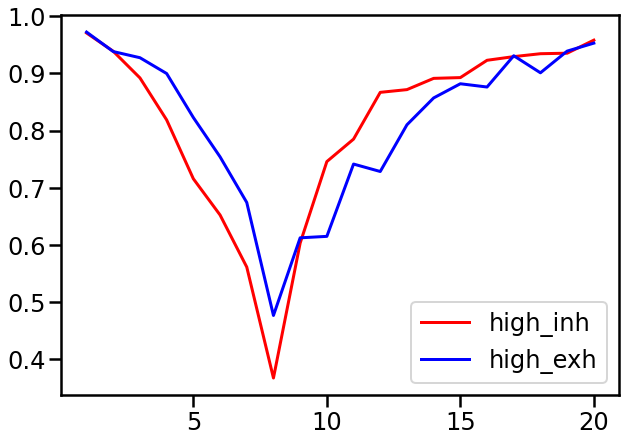

In [110]:
perf_high_inh = np.zeros(20)
perf_high_exh = np.zeros(20)
observed_diff = np.zeros(20)

plt.figure(figsize=(10,7))

for i in range(1,21):
    print(i)

    df_test_2 = df_test.loc[(df_test['Total Pulse']==i)]# & (df_test['Total Pulse']>0)]
#df_test_2 = df_test.loc[(df_test['Total Pulse']<21) & (df_test['Total Pulse']>0)]
# df_test['Effective_odor'] = df_test['Sniff_histogram'].apply(lambda x: (x*weights_norm).sum())
# df_test
    df_analysis = df_test_2

    observed_diff[i-1] = df_analysis[df_analysis['Differences']>0]['Correct'].mean() - df_analysis[df_analysis['Differences']<0]['Correct'].mean()
    perf_high_inh[i-1] = df_analysis[df_analysis['Differences']>0]['Correct'].mean()
    perf_high_exh[i-1] = df_analysis[df_analysis['Differences']<0]['Correct'].mean()
    print(df_analysis[df_analysis['Differences']>0]['Correct'].mean())
    print(df_analysis[df_analysis['Differences']<0]['Correct'].mean())

plt.plot(np.arange(1,21), perf_high_inh, color='red', label='high_inh')
plt.plot(np.arange(1,21), perf_high_exh, color='blue', label='high_exh')
plt.legend()

In [732]:
df_ff = df_test.drop(columns=['Sniff_histogram'])
#df_test.to_csv('behavioral_data_for_Farhad_with_eff_odor.csv', index=False)

df_ff.to_csv('behavioral_data_for_Farhad_with_eff_odor.csv', index=False)


Per-Animal Analysis:
   Animal  Perf_Diff_LT_0  Perf_Diff_GT_0
0       0        0.901961        0.781971
1       1        0.821637        0.647727
2       2        0.816479        0.674058
3       3        0.700880        0.718310
4       4        0.755725        0.795918
5       5        0.677632        0.708029
6       6        0.783951        0.734694
Paired t-test: t-statistic = 1.687, p-value = 7.131e-02


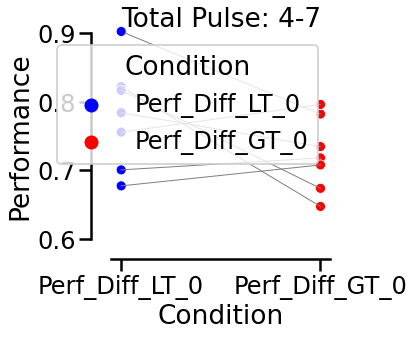

In [183]:
from scipy.stats import ttest_rel

# Group by 'Animal' and calculate mean performance for Differences < 0 and > 0
filtered_df = df_test.loc[(df_test['Total Pulse']>3) & (df_test['Total Pulse']<8)]

performance_by_animal = filtered_df.groupby('Animal').apply(
    lambda group: pd.Series({
        'Perf_Diff_LT_0': group.loc[group['Differences'] < 0, 'Correct'].mean(),
        'Perf_Diff_GT_0': group.loc[group['Differences'] > 0, 'Correct'].mean(),
    })
).reset_index()

# Perform a paired t-test
t_stat, p_value = ttest_rel(performance_by_animal['Perf_Diff_LT_0'], 
                            performance_by_animal['Perf_Diff_GT_0'], alternative='greater')

print("Per-Animal Analysis:")
print(performance_by_animal)
print(f"Paired t-test: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")

# Melt the data for easier plotting
melted_df = performance_by_animal.melt(id_vars='Animal', 
                                       value_vars=['Perf_Diff_LT_0', 'Perf_Diff_GT_0'],
                                       var_name='Condition', 
                                       value_name='Correct')

# Create a column for each animal to group the lines
melted_df['Animal_index'] = melted_df.groupby('Animal').ngroup()

# Plot using scatter
plt.figure(figsize=(6, 5))

# Scatter plot
sns.scatterplot(
    data=melted_df,
    x='Condition',  # Use condition as x-axis
    y='Correct',
    hue='Condition',
    #style='Condition',
    s=100,  # Marker size
    palette=['blue', 'red'],  # Optional: color for each condition
    clip_on=False)

# Draw lines connecting paired dots for each animal
for _, group in melted_df.groupby('Animal'):
    plt.plot(group['Condition'], group['Correct'], color='gray', linestyle='-', lw=1)

#plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='Chance level')
plt.xlabel("Condition")
plt.ylabel("Performance")
plt.title("Total Pulse: 4-7")

# Improve x-axis labels
plt.xticks([0, 1], ['Perf_Diff_LT_0', 'Perf_Diff_GT_0'])
#plt.legend(title="Condition")
plt.tight_layout()
sns.despine(offset=20)
plt.ylim(0.6,0.9)
plt.savefig(savepath_svg + 'below_boundary_sniff_effect_performance.svg',transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'below_boundary_sniff_effect_performance.png',transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'below_boundary_sniff_effect_performance.pdf',transparent=True, format='pdf', bbox_inches='tight')
plt.show()

Per-Animal Analysis:
   Animal  Perf_Diff_LT_0  Perf_Diff_GT_0
0       0        0.658065        0.789731
1       1        0.768742        0.863727
2       2        0.664903        0.811170
3       3        0.782090        0.818182
4       4        0.831325        0.824074
5       5        0.863874        0.846154
6       6        0.708791        0.764286
Paired t-test: t-statistic = -2.579, p-value = 2.092e-02


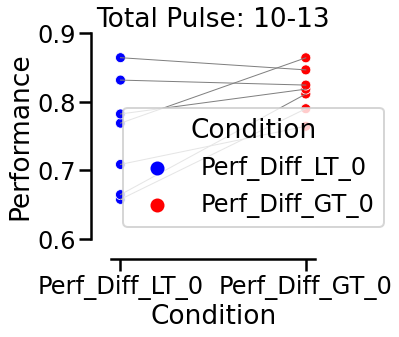

In [181]:
from scipy.stats import ttest_rel

# Group by 'Animal' and calculate mean performance for Differences < 0 and > 0
filtered_df = df_test.loc[(df_test['Total Pulse']>9) & (df_test['Total Pulse']<14)]

performance_by_animal = filtered_df.groupby('Animal').apply(
    lambda group: pd.Series({
        'Perf_Diff_LT_0': group.loc[group['Differences'] < 0, 'Correct'].mean(),
        'Perf_Diff_GT_0': group.loc[group['Differences'] > 0, 'Correct'].mean(),
    })
).reset_index()

# Perform a paired t-test
t_stat, p_value = ttest_rel(performance_by_animal['Perf_Diff_LT_0'], 
                            performance_by_animal['Perf_Diff_GT_0'], alternative='less')

print("Per-Animal Analysis:")
print(performance_by_animal)
print(f"Paired t-test: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")

# Melt the data for easier plotting
melted_df = performance_by_animal.melt(id_vars='Animal', 
                                       value_vars=['Perf_Diff_LT_0', 'Perf_Diff_GT_0'],
                                       var_name='Condition', 
                                       value_name='Correct')

# Create a column for each animal to group the lines
melted_df['Animal_index'] = melted_df.groupby('Animal').ngroup()

# Plot using scatter
plt.figure(figsize=(6, 5))

# Scatter plot
sns.scatterplot(
    data=melted_df,
    x='Condition',  # Use condition as x-axis
    y='Correct',
    hue='Condition',
    #style='Condition',
    s=100,  # Marker size
    palette=['blue', 'red']  # Optional: color for each condition
)

# Draw lines connecting paired dots for each animal
for _, group in melted_df.groupby('Animal'):
    plt.plot(group['Condition'], group['Correct'], color='gray', linestyle='-', lw=1)

#plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='Chance level')
plt.xlabel("Condition")
plt.ylabel("Performance")
plt.title("Total Pulse: 10-13")

# Improve x-axis labels
plt.xticks([0, 1], ['Perf_Diff_LT_0', 'Perf_Diff_GT_0'])
#plt.legend(title="Condition")
plt.tight_layout()
sns.despine(offset=20)
plt.ylim(0.6,0.9)
plt.savefig(savepath_svg + 'above_boundary_sniff_effect_performance.svg',transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'above_boundary_sniff_effect_performance.png',transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'above_boundary_sniff_effect_performance.pdf',transparent=True, format='pdf', bbox_inches='tight')

plt.show()

In [ ]:
xopts = []
xoptsX = []
ns = np.arange(1, 21)
nNs = []
ia = 0
y = []

if ia == 0:
    for ni in range(1, 21):
        nNs.append(np.sum(behav['pooled_pulse_counts'] == ni))
        #y.append(behav['Phighs_pooled_mean'][behav['NsUnique'] == ni].flatten())
        y.append(behav['Phighs_pooled_mean'].flatten()[np.where(behav['NsUnique'] == ni)[0][0]])
    idx = np.where((d['Total Pulse'] < 21) & (d['Total Pulse'] > 0) & (d['Animal'] > -1))[0]
else:
    idx = np.where((d['Animal'] == ia - 1) & (d['Total Pulse'] < 21) & (d['Total Pulse'] > 0))[0]
    y = []
    for ni in range(1, 21):
        y.append(behav['PhighAnimals'][ia - 1, behav['NsUnique2'] == ni].flatten())

# Process the data for the main figure plot
Nis = d['Total Pulse'].iloc[idx].values
yis = d['High Choice'].iloc[idx].values
wNs = d['Effective_odor'].iloc[idx].values
Nisorig0 = Nis; yisorig = yis;

# Plotting
plt.figure()
plt.scatter(Nis, wNs)
plt.xlabel('True N')
plt.ylabel('Effective N')
plt.plot([0, 20], [0, 20], '-', linewidth=2)
plt.grid(which='minor', linestyle='--')

p = np.polyfit(Nis, wNs, 1)
# Linear fit
slope, intercept, _, _, _ = linregress(Nis, wNs)
x_fit = np.linspace(0, 20, 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, 'r--', linewidth=2)
plt.title(f'Sniff kernel fit slope = {slope:.2f}')

# Error bars for each ni
for ni in range(1, 21):
    ni_idx = np.where(Nis == ni)[0]
    if len(ni_idx) > 0:
        plt.errorbar(ni, np.mean(wNs[ni_idx]), yerr=np.std(wNs[ni_idx]), color='r', linewidth=3)

plt.legend(['Data', 'y=x', 'linear fit'])
plt.gca().tick_params(axis='both', which='major', labelsize=15)
plt.show()


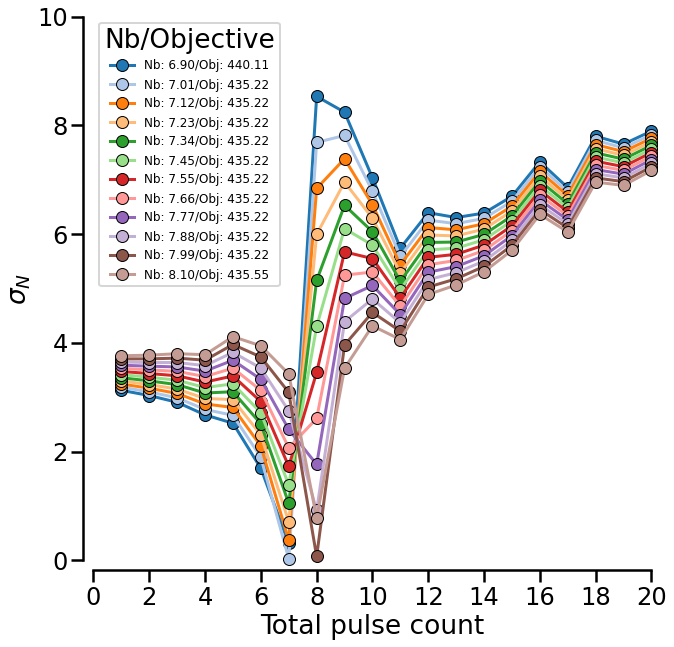

In [127]:
N = np.arange(1,21)
Nis = df_test_2['Total Pulse'].values
yis = df_test_2['High Choice'].values
Nisorig = Nis.copy()
yisorig = yis.copy()

F = lambda x, N: 0.5 * (1 + scipy.special.erf((N - x[20]) / np.sqrt(2 * (x[N.astype(int) - 1] ** 2 + x[21] ** 2))))

# Bootstrapping
k = np.arange(1, 21)
xall_data_theory = []
lks = []
Nboot = 0
numNbs = 12

for i in range(Nboot + 1):
    if i == 0:
        idxboot = np.arange(len(yisorig))
    else:
        idxboot = np.random.choice(len(yisorig), len(yis), replace=True)

    Nis = Nisorig[idxboot]
    yis = yisorig[idxboot]

    # Find average psychometric for this:
    yboot = []
    for ni in range(1, 21):
        yboot.append(np.mean(yis[Nis == ni]))

    nsq = np.arange(1, 20.01, 0.01)
    yq = np.interp(nsq, np.arange(1, 21), yboot)
    Nzerocrossing = nsq[np.argmin(np.abs(yq - 0.5))]
    Nb = Nzerocrossing

    if numNbs > 1:
        Nbs = np.linspace(np.floor(Nb) -0.1, np.floor(Nb) + 1.1, numNbs)
        #Nbs = np.linspace(np.floor(Nb), np.floor(Nb) + 1, numNbs)
    else:
        Nbs = [Nb]
    
    for j in range(numNbs):
        Nb = Nbs[j]
        sigmab = 0
        sigmaNs = np.sqrt(((k - Nb) / scipy.special.erfinv(2 * np.array(yboot)[k - 1] - 1)) ** 2 / 2 - sigmab ** 2)
        sigmaNs[np.where(np.arange(1, 21) == Nb)] = np.nan

        x = np.concatenate([sigmaNs, [Nb], [sigmab]])
        loglikelihood = -np.nanmean(np.log(F(x, Nis)) * yis + np.log(1 - F(x, Nis)) * (1 - yis))
        lks.append(loglikelihood * 1000)
        xall_data_theory.append(x)

# Plotting
xall_data_theory = np.array(xall_data_theory)
plt.figure(figsize=(10,10))
for i in range(xall_data_theory.shape[0]):
    plt.plot(np.arange(1, 21), xall_data_theory[i, :20], '-o', linewidth=3, color=cmap_9[i], markeredgecolor='k', clip_on=False)

#plt.title('Data - theory fit')
#plt.grid(which='both', linestyle='--')
plt.ylabel(r'$\sigma_N$')
plt.xlabel('Total pulse count')
#plt.text(1, 6.5, r'$\sigma_b=' + f'{np.mean(xall_data_theory[:, 21]):.2f} \pm {np.std(xall_data_theory[:, 21]):.2f}$', fontsize=18)
leg = plt.legend([f'Nb: {xall_data_theory[i, 20]:.2f}/Obj: {lks[i]:.2f}' for i in range(len(lks))], loc='best', fontsize=12)
leg.set_title('Nb/Objective')
sns.despine(offset=10)
plt.xlim(0,20)
plt.ylim(0,10)
plt.xticks(np.linspace(0,20,11))

plt.savefig(savepath_svg + 'sigma_estimation_multiple_Nbs.svg',transparent = True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'sigma_estimation_multiple_Nbs.png',transparent = True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'sigma_estimation_multiple_Nbs.pdf',transparent = True, format='pdf', bbox_inches='tight')

plt.show()

In [236]:
import importlib
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/matplotlib/pyplot.py'>

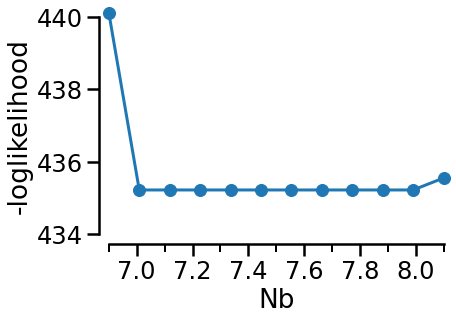

In [11]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

x_ticks = np.arange(6.90,8.10,(8.1-6.9)/7)
plt.plot(Nbs, lks, marker='o', clip_on=False)
#plt.xticks(np.arange(6.9,8.2,0.1), np.arange(6.9,8.2,0.2))
plt.ylabel('-loglikelihood')
plt.xlabel('Nb')
# Set ticks every 0.1 units
# Set ticks every 0.1 units (minor ticks)
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.1))

# Set major ticks every 0.2 units (labels will be shown only here)
plt.gca().xaxis.set_major_locator(MultipleLocator(0.2))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.xlim(6.9,8.1)
plt.ylim(434,440)
sns.despine(offset=10)

plt.savefig(savepath_svg + 'llkh_estimation_multiple_Nbs.svg',transparent = True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'llkh_estimation_multiple_Nbs.png',transparent = True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'llkh_estimation_multiple_Nbs.pdf',transparent = True, format='pdf', bbox_inches='tight')

plt.show()



In [154]:
df_test.groupby(['Animal','Session'])['Total Pulse'].count().reset_index()

Animal               Session  Total Pulse
0        0      Tabby_20190419_0          173
1        0      Tabby_20190423_0          169
2        0      Tabby_20190426_0          171
3        0      Tabby_20190427_0          229
4        0      Tabby_20190430_0          321
5        0      Tabby_20190501_0          339
6        0      Tabby_20190503_0          198
7        0      Tabby_20190504_0          147
8        0      Tabby_20190505_0          180
9        0      Tabby_20190510_0          320
10       0      Tabby_20190511_0          300
11       0      Tabby_20190512_0          282
12       0      Tabby_20190513_0          318
13       0      Tabby_20190514_0          336
14       0      Tabby_20190516_0          147
15       0      Tabby_20190517_0          269
16       0      Tabby_20190518_0          234
17       0      Tabby_20190519_0          248
18       1     Bengal_20190419_0          247
19       1     Bengal_20190422_0          234
20       1     Bengal_20190423_0          214
21       1     Bengal_20190426_0          240
22       1     Bengal_20190427_0          218
23       1     Bengal_20190430_0          323
24       1     Bengal_20190501_0          260
25       1     Bengal_20190502_0          234
26       1     Bengal_20190503_0          365
27       1     Bengal_20190504_0          210
28       1     Bengal_20190505_0          212
29       1     Bengal_20190507_0          108
30       1     Bengal_20190508_0          265
31       1     Bengal_20190509_0          244
32       1     Bengal_20190510_0          261
33       1     Bengal_20190511_0          280
34       1     Bengal_20190512_0          226
35       1     Bengal_20190513_0          250
36       1     Bengal_20190516_0          161
37       1     Bengal_20190517_0          247
38       1     Bengal_20190518_0          290
39       1     Bengal_20190519_0          238
40       2  Shorthair_20190419_0          229
41       2  Shorthair_20190422_0          141
42       2  Shorthair_20190423_0          231
43       2  Shorthair_20190427_0          222
44       2  Shorthair_20190430_0          273
45       2  Shorthair_20190501_0          288
46       2  Shorthair_20190502_0          357
47       2  Shorthair_20190503_0          321
48       2  Shorthair_20190504_0          151
49       2  Shorthair_20190505_0          242
50       2  Shorthair_20190507_0          367
51       2  Shorthair_20190508_0          306
52       2  Shorthair_20190509_0          297
53       2  Shorthair_20190516_0           81
54       2  Shorthair_20190517_0          227
55       2  Shorthair_20190518_0          165
56       2  Shorthair_20190519_0          180

In [13]:
no_cell_trials = 147+269+234+248+297+81+227+165+180+161+247+290+238
print(no_cell_trials)
print(len(df_test)-no_cell_trials)

2784
11002


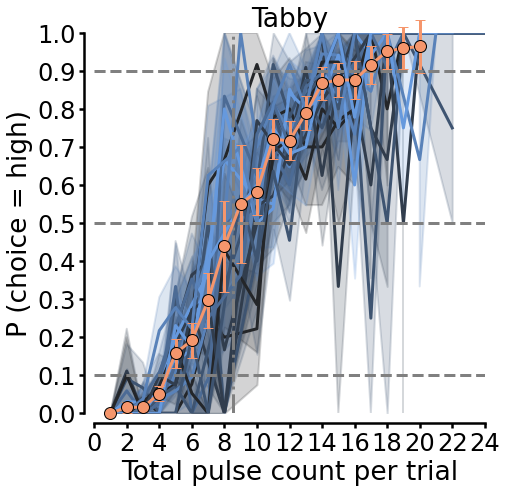

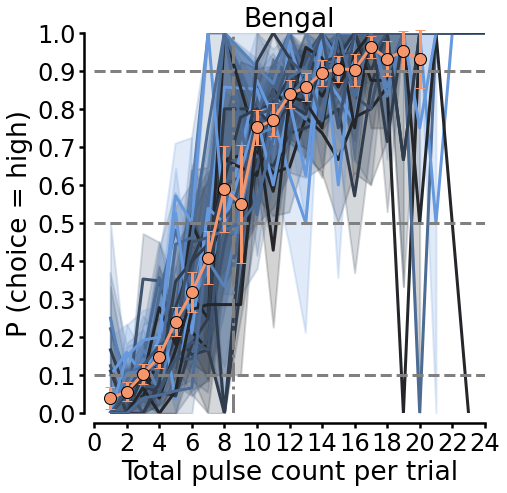

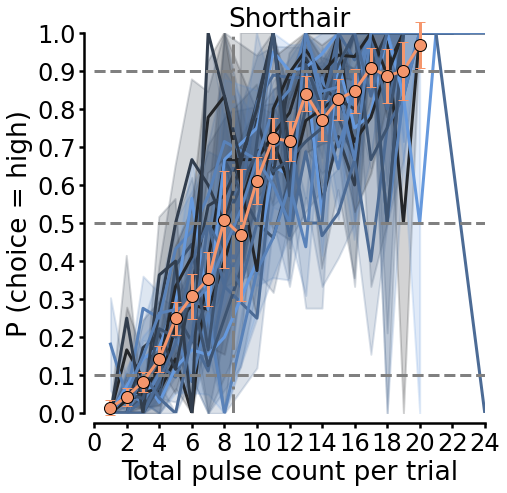

In [71]:
alist=['Tabby', 'Bengal', 'Shorthair']

for i in range(3):


    plt.figure(figsize=(7,7))
    sns.lineplot(data=df_test.loc[df_test['Animal']==i], x='Total Pulse', y='High Choice', hue='Session'
                 , legend=False, errorbar='se', palette=sns.dark_palette('#69d'))
    #plt.title[alist[i]]
    
    phigh = phigh_list[i]
    plt.errorbar(pulse_bins,y=phigh[0:24,0],yerr=phigh[0:20,1],
                 marker='o',color=cmap_5[1], markeredgecolor = 'black', capsize=5, clip_on=False)
    plt.xlim(0,20)
    plt.ylim(0,1)
    plt.axhline(y=0.1,color='gray',linestyle='--')
    plt.axhline(y=0.5,color='gray',linestyle='--')
    plt.axhline(y=0.9,color='gray',linestyle='--')
    plt.axvline(x=8.5,color='gray',linestyle='-.')
    plt.xlabel('Total pulse count per trial')
    plt.yticks(np.linspace(0,1,11))
    plt.ylabel('P (choice = high)')
    plt.xticks(np.linspace(0,24,13))
    plt.xlim(0,24)
    plt.title(flatten_comprehension(animal_list[:3])[i])
    plt.tick_params(axis='both', length=5, color='black', direction = 'out')
    sns.despine(offset=10)
    plt.show()

In [15]:
df_test_3 = df_test.groupby(['Animal', 'Session'])['Correct'].mean().reset_index()



(0.0, 1.0)

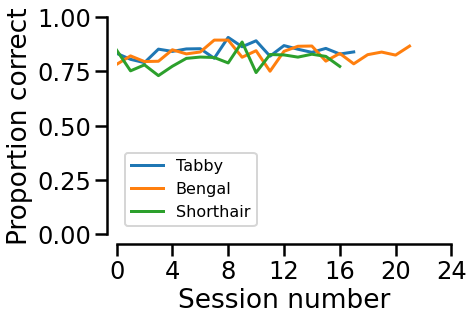

In [47]:
df_test_3['group_num'] = df_test_3.groupby(['Animal', 'Session']).ngroup()
df_test_3['Session_num'] = df_test_3.groupby(['Animal'])['group_num'].rank(method='dense').astype(int)-1
df_test_3.drop(columns=['group_num'], axis=1, inplace=True)
#df_test_3['Session_num'] = df_test_3.groupby(['Animal','Session'])['Correct'].count()
sns.lineplot(data=df_test_3, x='Session_num', y='Correct', hue='Animal', palette=sns.color_palette('tab10'), errorbar=None)
plt.legend(['Tabby', 'Bengal', 'Shorthair'], fontsize=16)
sns.despine(offset=10)
plt.xlim(0,24)
plt.xticks(np.arange(0,25,4))
plt.ylabel('Proportion correct')
plt.xlabel('Session number')
plt.ylim(0,1)

In [103]:
with (open(os.getcwd()+'/behavioral_data_for_Farhad_updated.pkl', "rb")) as openfile:
    df_file = pickle.load(openfile)

df_file

Animal                 Session  Total Pulse  Correct  High Choice  \
0           0        Tabby_20190419_0           14        1            1   
1           0        Tabby_20190419_0           14        1            1   
2           0        Tabby_20190419_0           11        1            1   
3           0        Tabby_20190419_0            5        1            0   
4           0        Tabby_20190419_0            2        1            0   
...       ...                     ...          ...      ...          ...   
20037       6  Peterparker_20220407_0            4        1            0   
20038       6  Peterparker_20220407_0           10        0            0   
20039       6  Peterparker_20220407_0            4        1            0   
20040       6  Peterparker_20220407_0            2        1            0   
20041       6  Peterparker_20220407_0            4        1            0   

                                              Trial odor  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                  ...   
20037  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
20038  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
20039  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
20040  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
20041  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             Odor onsets  \
0      [232, 573, 907, 1151, 1373, 1638, 2026, 2879, ...   
1      [104, 309, 510, 954, 1116, 1668, 2224, 2603, 3...   
2      [303, 505, 1828, 1961, 2496, 3357, 3597, 4679,...   
3                         [1741, 3478, 3599, 4178, 4448]   
4                                             [67, 1974]   
...                                                  ...   
20037                             [274, 987, 3460, 4562]   
20038  [736, 1655, 2453, 2686, 3903, 3915, 4096, 4211...   
20039                            [171, 1040, 1501, 3874]   
20040                                        [617, 3390]   
20041                           [1131, 1795, 4156, 4230]   

                                               Breathing        CV  Burstiness  
0      [2.8106680871555025, 2.822355210990738, 2.8301...  0.585915           0  
1      [4.9724699683179905, 4.9724699683179905, 4.978...  0.550588           0  
2      [2.249361953412101, 2.268515821687559, 2.27403...  0.924470           0  
3      [0.5524618390079302, 0.5508386343064373, 0.545...  0.791313           0  
4      [5.336072904872876, 5.329255343301051, 5.31789...  0.731941           0  
...                                                  ...       ...         ...  
20037  [1.8371021464367163, 1.8142198886851109, 1.818...  0.788089           0  
20038  [2.4446106560551133, 2.4645923918942683, 2.484...  0.852646           0  
20039  [4.331925870574089, 4.3267692466061245, 4.3064...  0.761042           0  
20040  [0.5924384908413423, 0.5888933644162682, 0.587...  0.528657           0  
20041  [0.4477328975604163, 0.4499888864308874, 0.449...  0.760625           0  

[20042 rows x 10 columns]

<class 'numpy.ndarray'>


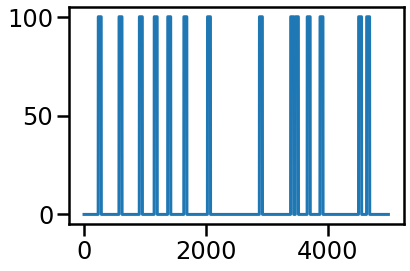

In [105]:
print(type(df_file['Trial odor'][0]))
plt.plot(df_file['Trial odor'][0])

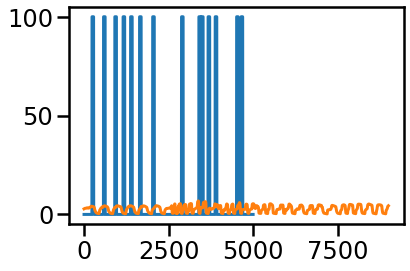

In [61]:
plt.plot(df_test['Trial odor'][0])
plt.plot(df_test['Breathing'][0])
#plt.xlim(573, 625)


In [69]:
import pingouin as pg

#df_high_b = df_high.loc[df_high['Burstiness']>1]
df_high = df_test.loc[(df_test['Total Pulse']>8) & (df_test['Total Pulse']<21)]
df_low = df_test.loc[(df_test['Total Pulse']>0) & (df_test['Total Pulse']<9)]
df_high_b = df_high.loc[df_high['Burstiness']==1]
df_high_nb = df_high.loc[df_high['Burstiness']==0]
df_low_b = df_low.loc[df_low['Burstiness']==1]
df_low_nb = df_low.loc[df_low['Burstiness']==0]


In [50]:
df_high

Animal                 Session  Total Pulse  Correct  High Choice  \
0           0        Tabby_20190419_0           14        1            1   
1           0        Tabby_20190419_0           14        1            1   
2           0        Tabby_20190419_0           11        1            1   
6           0        Tabby_20190419_0           12        1            1   
9           0        Tabby_20190419_0           16        0            0   
...       ...                     ...          ...      ...          ...   
20033       6  Peterparker_20220407_0            9        0            0   
20034       6  Peterparker_20220407_0            9        1            1   
20035       6  Peterparker_20220407_0           12        1            1   
20036       6  Peterparker_20220407_0           10        0            0   
20038       6  Peterparker_20220407_0           10        0            0   

                                              Trial odor  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                  ...   
20033  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
20034  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
20035  [0.0, 0.0, 0.0, 0.0, 100.0, 100.0, 100.0, 100....   
20036  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
20038  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             Odor onsets  \
0      [233, 574, 908, 1152, 1374, 1639, 2027, 2880, ...   
1      [105, 310, 511, 955, 1117, 1669, 2225, 2604, 3...   
2      [304, 506, 1829, 1962, 2497, 3358, 3598, 4680,...   
6      [92, 591, 841, 1001, 1102, 1143, 1152, 1413, 3...   
9      [217, 228, 267, 380, 648, 816, 1023, 1183, 228...   
...                                                  ...   
20033  [295, 609, 794, 832, 844, 861, 882, 1163, 1995...   
20034  [925, 928, 955, 975, 978, 1252, 2035, 3071, 37...   
20035  [4, 948, 1176, 1478, 2209, 3194, 3673, 3903, 4...   
20036  [342, 544, 646, 886, 1173, 1468, 2821, 3235, 4...   
20038  [737, 1656, 2454, 2687, 3904, 3916, 3954, 4097...   

                                               Breathing        CV  Burstiness  
0      [2.8106680871555025, 2.822355210990738, 2.8301...  0.585785           0  
1      [4.9724699683179905, 4.9724699683179905, 4.978...  0.550357           0  
2      [2.249361953412101, 2.268515821687559, 2.27403...  1.090472           1  
6      [4.183259073567781, 4.183259073567781, 4.18325...  1.201606           1  
9      [3.4599534093738935, 3.458330194270908, 3.4586...  1.244350           1  
...                                                  ...       ...         ...  
20033  [0.3355780351087476, 0.33074377435056734, 0.32...  0.960102           0  
20034  [0.6936357477466772, 0.7364995609659656, 0.786...  1.011190           1  
20035  [4.966191827749729, 4.972637632736624, 5.02001...  0.803369           0  
20036  [4.467609594179646, 4.537868666927731, 4.60748...  0.799540           0  
20038  [2.4446106560551133, 2.4645923918942683, 2.484...  1.012684           1  

[9743 rows x 10 columns]

0.8294218660560961
0.7716960749009723
0.492


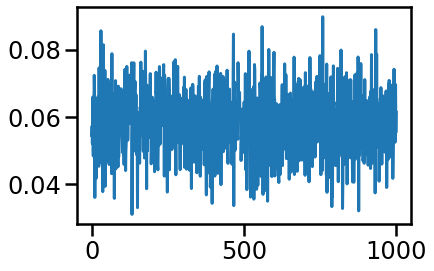

In [72]:
df_analysis = df_high

observed_diff = df_analysis[df_analysis['Burstiness']==0]['Correct'].mean() - df_analysis[df_analysis['Burstiness']==1]['Correct'].mean()
print(df_analysis[df_analysis['Burstiness']==0]['Correct'].mean())
print(df_analysis[df_analysis['Burstiness']==1]['Correct'].mean())
def bootstrap_proportions_diff(df, n_iterations=1000):
    #weights = df['Correct'].value_counts(normalize=True).reindex(df['Correct']).values
    bootstrap_diffs = []
    for _ in range(n_iterations):
        sample = df.sample(n=len(df), replace=True)#, weights=weights)
        prop_A_boot = sample[sample['Burstiness'] == 0]['Correct'].mean()
        prop_B_boot = sample[sample['Burstiness'] == 1]['Correct'].mean()
        bootstrap_diffs.append(prop_A_boot - prop_B_boot)
    return np.array(bootstrap_diffs)

# Perform bootstrapping
n_iter = 1000
bootstrap_diffs = bootstrap_proportions_diff(df_analysis, n_iter)

# Calculate p-value (two-sided test)
p_value = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))
print(p_value)
plt.plot(bootstrap_diffs)

In [87]:
#np.mean(df_high_b['Correct'])
def bootstrap_proportions_diff(x, y):
    return np.mean(x) - np.mean(y)#.mean()

In [85]:
print(type(bootstrap_diffs))

<class 'numpy.ndarray'>


In [66]:
bursty = df_high_b['Correct'].values
no_bursty = df_high_nb['Correct'].values

In [83]:
print(dist[1])
#np.abs(observed_diff)

-0.01133920565126012


0.512


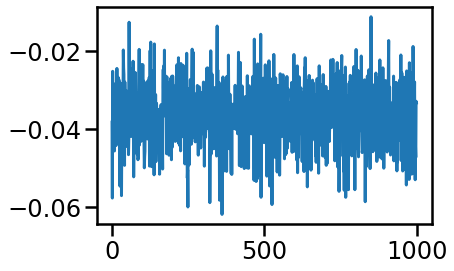

In [88]:

    
ci, dist = pg.compute_bootci(x=bursty, y=no_bursty, func=bootstrap_proportions_diff, n_boot=1000, return_dist=True)
plt.plot(dist)
p_value = np.mean(np.abs(dist) >= np.abs(observed_diff))
print(p_value)


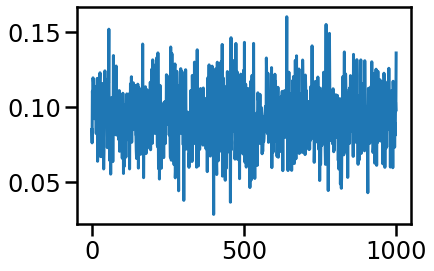

In [22]:
tata, tatin = pg.compute_bootci(x=df_high_nb['Correct'], y=df_high_b['Correct'], func='cohen', n_boot=1000, return_dist=True)

plt.plot(tatin)

In [280]:



results_array = np.zeros((4,3))

results_array[0,0] = df_high_b['Correct'].mean()
results_array[0, 1:] = pg.compute_bootci(x=df_high_b['Correct'], func='mean', method='cper', confidence=.95, n_boot = 500, decimals = 3, seed=123, return_dist=False)

results_array[1,0] = df_high_nb['Correct'].mean()
results_array[1, 1:] = pg.compute_bootci(x=df_high_nb['Correct'], func='mean', method='cper', confidence=.95, n_boot = 500, decimals = 3, seed=123, return_dist=False)

results_array[2,0] = df_low_b['Correct'].mean()
results_array[2, 1:] = pg.compute_bootci(x=df_low_b['Correct'], func='mean', method='cper', confidence=.95, n_boot = 500, decimals = 3, seed=123, return_dist=False)

results_array[3,0] = df_low_nb['Correct'].mean()
results_array[3, 1:] = pg.compute_bootci(x=df_low_nb['Correct'], func='mean', method='cper', confidence=.95, n_boot = 500, decimals = 3, seed=123, return_dist=False)

results_array

array([[0.7941905 , 0.782     , 0.806     ],
       [0.83062995, 0.82      , 0.841     ],
       [0.82573212, 0.81      , 0.841     ],
       [0.82424242, 0.817     , 0.833     ]])

In [281]:
test_cont = pd.crosstab(df_high['Correct'], df_high['Burstiness'])
scipy.stats.chi2_contingency(test_cont, correction=True)

(20.956808495230312,
 4.697553528916736e-06,
 1,
 array([[ 986.06425126,  825.93574874],
        [4315.93574874, 3615.06425126]]))

In [282]:
test_cont

Burstiness     0     1
Correct               
0            898   914
1           4404  3527

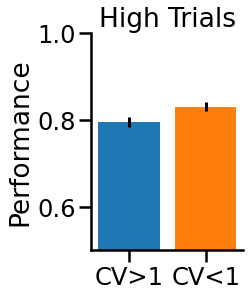

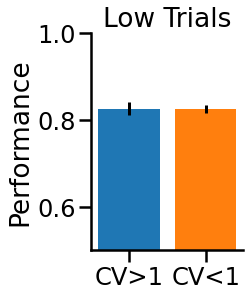

In [288]:
plt.subplot(1,2,1)

for i in range(2):
    plt.bar(x=i, height=results_array[i,0], yerr=results_array[i,2]-results_array[i,0])

plt.xticks(np.arange(2), ['CV>1', 'CV<1'])
plt.title('High Trials')
plt.ylabel('Performance')
plt.ylim(0.5,1)
sns.despine()
plt.show()

plt.subplot(1,2,2)

for i in range(2,4):
    plt.bar(x=i, height=results_array[i,0], yerr=results_array[i,2]-results_array[i,0])

plt.xticks(np.arange(2,4), ['CV>1', 'CV<1'])
plt.title('Low Trials')
plt.ylabel('Performance')
plt.ylim(0.5,1)
sns.despine()
plt.show()


[7.16950586e-04 2.15120660e-03 6.43620437e-03 1.90931902e-02
 5.52562563e-02 1.49475772e-01 3.45584562e-01 6.13419416e-01
 8.26628993e-01 9.34755040e-01 9.77298237e-01 9.92328658e-01
 9.97433843e-01 9.99144518e-01 9.99715133e-01 9.99905178e-01
 9.99968441e-01 9.99989497e-01 9.99996505e-01 9.99998837e-01]


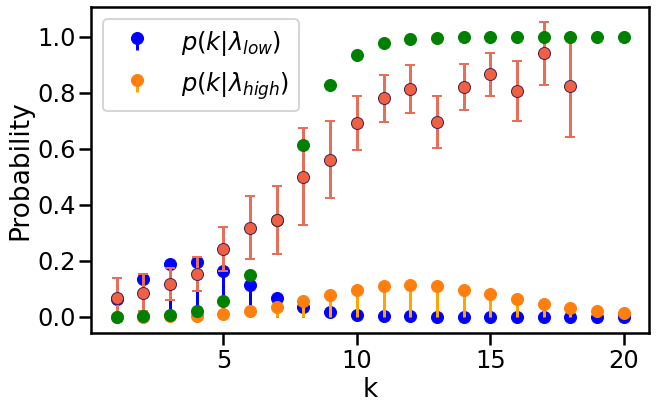

In [13]:
from scipy.special import factorial

# Poisson distribution
def pois(k, lambd):
    return (lambd**k * np.exp(-lambd)) / factorial(k)

# Modified distribution q
def q(k, lambd_low, lambd_high):
    return (lambd_high / lambd_low)**k * np.exp(lambd_low - lambd_high)

# phigh function
def phigher(k, lambd_low, lambd_high):
    return q(k, lambd_low, lambd_high) / (1 + q(k, lambd_low, lambd_high))

# Parameters
lambd_low = 4.16
lambd_high = 12.5
k_vals = np.arange(1, 21)

# Calculate values for plotting
pois_low = pois(k_vals, lambd_low)
pois_high = pois(k_vals, lambd_high)
phigh_vals = phigher(k_vals, lambd_low, lambd_high)
print(phigh_vals)

# Plotting
plt.figure(figsize=(10, 6))
plt.stem(k_vals, pois_low, linefmt='b-', markerfmt='bo', basefmt=" ", label=r'$p(k|\lambda_{low})$', use_line_collection=True)
plt.stem(k_vals, pois_high, linefmt='orange', markerfmt='o', basefmt=" ", label=r'$p(k|\lambda_{high})$', use_line_collection=True)
plt.errorbar(k_vals, phigh_vals, marker='o', ls='', color='g')#, markerfmt='go', basefmt=" ", label='phigh', use_line_collection=True)
plt.errorbar(pulse_bins,y=phigh[0:21,0],yerr=phigh[0:21,1], marker='o', ls='',
             color=cmap_5[2], markeredgecolor = cmap_5[6], clip_on=False, alpha=1,
            ecolor=cmap_11[6], capsize=5, capthick=2)


plt.xlabel('k')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [560]:
np.round(phigh_vals,2)

array([0.  , 0.  , 0.01, 0.02, 0.06, 0.15, 0.35, 0.61, 0.83, 0.93, 0.98,
       0.99, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

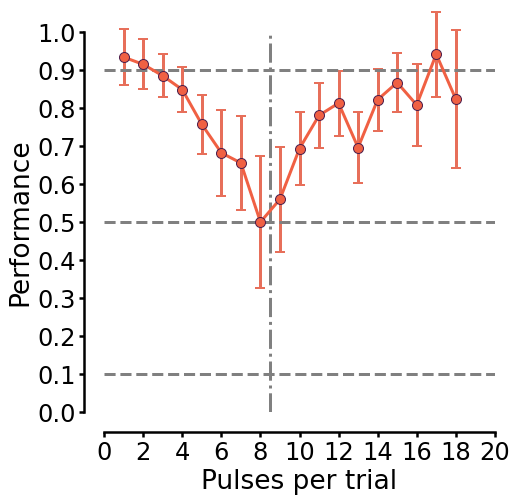

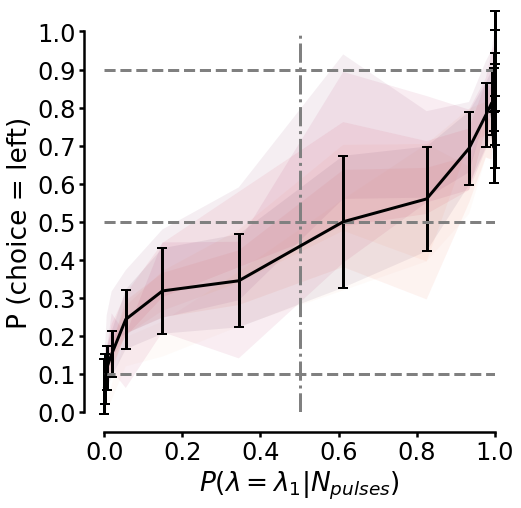

In [18]:
fig1 = plt.figure(figsize=(7,7))
plt.errorbar(pulse_bins,y=performance[0:20,0],yerr=performance[0:20,1], marker='.', markersize=20, ls='-',
             color=cmap_5[2], markeredgecolor = cmap_5[6], clip_on=False, alpha=1,
            ecolor=cmap_11[6], capsize=5, capthick=2)
# for i in range(len(phigh_list)):
#     phigh_animal = phigh_list[i]
#     plt.fill_between(pulse_bins, phigh_animal[0:20,0] - phigh_animal[0:20,1],
#                      phigh_animal[0:20,0] + phigh_animal[0:20,1], 
#                      alpha=0.1, color=cmap_5[i], edgecolor=None)

plt.xlabel('Pulses per trial')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('Performance')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,20)
plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True, offset=20)

fig1.savefig(savepath_svg + 'behavior_summary_all_20_indbands_bars_test_last.svg', transparent = True, format='svg', bbox_inches='tight')
fig1.savefig(savepath_png + 'behavior_summary_all_20_indbands_bars_test_last.png', transparent = True, format='png', bbox_inches='tight')
fig1.savefig(savepath_pdf + 'behavior_summary_all_20_indbands_bars_test_last.pdf', transparent = True, format='pdf', bbox_inches='tight')

plt.show()

plam_bins = calc_plam(pulse_bins,12.5,4.16667)

fig2 = plt.figure(figsize=(7,7))
plt.errorbar(plam_bins,y=phigh[0:20,0],yerr=phigh[0:20,1], marker='', ls='-',
             clip_on=False, color='black', ecolor='black', capsize=5, capthick=2)

for i in range(len(phigh_list)):
    phigh_animal = phigh_list[i]
    plt.fill_between(plam_bins, phigh_animal[0:20,0] - phigh_animal[0:20,1], 
                     phigh_animal[0:20,0] + phigh_animal[0:20,1], 
                     alpha=0.075, color=cmap_5[i], edgecolor=None)
    
plt.xlabel('$P(\lambda=\lambda_1|N_{pulses})$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=0.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P (choice = left)')
plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True, offset=20)
# fig2.savefig(savepath_svg + 'p_observed_vs_expected_poisson_indbands_bars.svg', transparent = True, format='svg', bbox_inches='tight')
# fig2.savefig(savepath_png + 'p_observed_vs_expected_poisson_indbands_bars.png', transparent = True, format='png', bbox_inches='tight')
# fig2.savefig(savepath_pdf + 'p_observed_vs_expected_poisson_indbands_bars.pdf', transparent = True, format='pdf', bbox_inches='tight')

plt.show()

In [18]:
df_mb_wo_catch = pd.read_csv("methyl_butyrate_wo_catch.csv")


In [19]:
df_mb_wo_catch

Unnamed: 0  Animal               Session  Total_pulse  Correct  \
0              0       0  Camembert_20250723_0           10        1   
1              1       0  Camembert_20250723_0           13        1   
2              2       0  Camembert_20250723_0            9        1   
3              3       0  Camembert_20250723_0            5        0   
4              4       0  Camembert_20250723_0            3        1   
...          ...     ...                   ...          ...      ...   
9758       10414       2   Emmental_20250818_3            4        1   
9759       10415       2   Emmental_20250818_3            2        1   
9760       10416       2   Emmental_20250818_3           17        0   
9761       10417       2   Emmental_20250818_3            2        0   
9762       10418       2   Emmental_20250818_3           13        1   

      High_choice  Catch_trial  
0               1            0  
1               1            0  
2               1            0  
3               1            0  
4               0            0  
...           ...          ...  
9758            0            0  
9759            0            0  
9760            0            0  
9761            1            0  
9762            1            0  

[9763 rows x 7 columns]

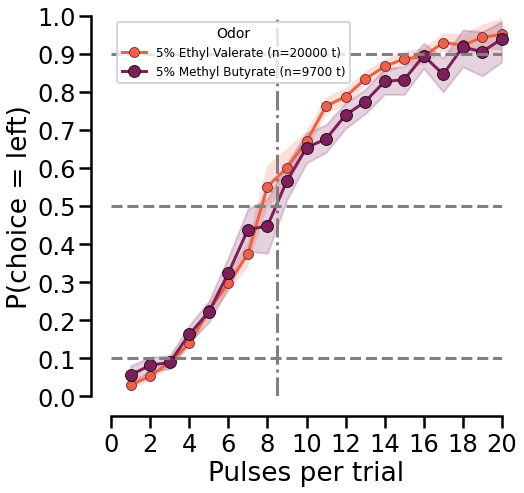

In [34]:
fig, ax = plt.subplots(figsize=(7,7))#= plt.figure(figsize=(7,7))

sns.lineplot(x=pulse_bins[0:20],y=phigh[0:20,0],color=cmap_5[2],  
                  marker='.',markeredgecolor=cmap_5[6], markersize=20, clip_on=False, label='5% Ethyl Valerate')
plt.fill_between(pulse_bins[0:20], phigh[0:20,0] - phigh[0:20,1], phigh[0:20,0] + phigh[0:20,1], 
                   alpha=0.2, color=cmap_5[2], edgecolor=None)

sns.lineplot(df_mb_wo_catch.loc[df_mb_wo_catch['Total_pulse']<21], x='Total_pulse', y='High_choice', hue='Catch_trial', palette = {0: cmap_5[5]}, clip_on=False, err_style='band',
             marker='o', markeredgecolor='k', label='5% Methyl Butyrate')

plt.xlabel('Pulses per trial')  #'$N_{pulses}$'
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.xlim(0,20)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice = left)')  #$P$(choice = left)
plt.xticks(np.linspace(0,20,11))
sns.despine(right=True, top=True, offset=20)

# Get current handles and labels
handles, labels = ax.get_legend_handles_labels()

# Replace with custom labels
ax.legend(handles, ['5% Ethyl Valerate (n=20000 t)', '5% Methyl Butyrate (n=9700 t)'], title="Odor", fontsize=12, title_fontsize=14)
#ax.legend(title="Group")




# fig_2 = plt.figure(figsize=(7,7))

# #sns.lineplot(x=pulse_bins[0:24],y=phigh[0:20,0],color=cmap_5[1])
# plt.errorbar(pulse_bins,y=phigh[0:24,0],yerr=phigh[0:24,1], marker='.', ls='-', markersize=20,
#              color=cmap_5[2], markeredgecolor = cmap_5[6], clip_on=False, alpha=1,
#             ecolor=cmap_11[6], capsize=5, capthick=2)

# #plt.errorbar(k_vals, phigh_vals, label='phigh', clip_on=False, marker='.', markersize=20, color='blue', ls='-', markeredgecolor = 'black')               

# plt.xlabel('Pulses per trial')
# plt.axhline(y=0.1,color='gray',linestyle='--')
# plt.axhline(y=0.5,color='gray',linestyle='--')
# plt.axhline(y=0.9,color='gray',linestyle='--')
# plt.axvline(x=8.5,color='gray',linestyle='-.')
# plt.ylim(0,1)
# plt.xlim(0,1)
# plt.yticks(np.linspace(0,1,11))
# plt.ylabel('P(choice = left)')
# plt.xticks(np.linspace(0,20,11))
# sns.despine(right=True, top=True, offset=20)

# fig_3 = plt.figure(figsize=(7,7))

# ax = plt.errorbar(plam_bins,y=phigh_vals, marker='.', markersize=20, color='blue', 
#                   markeredgecolor = 'black', capsize=5, clip_on=False)


# ax = sns.lineplot(x=plam_bins[0:20],y=phigh[0:20,0],color=cmap_5[2],
#                  marker='.',markeredgecolor=cmap_5[6], markersize=20, clip_on=False)
# # plt.errorbar(plam_bins[0:20],y=phigh[0:20,0],yerr=phigh[0:20,1], marker='o', ls='',
# #              color=cmap_5[2], markeredgecolor = cmap_5[6], clip_on=False, alpha=1)

# ax.fill_between(plam_bins[0:24], phigh[0:24,0] - phigh[0:24,1], phigh[0:24,0] + phigh[0:24,1], 
#                    alpha=0.2, color=cmap_5[2], edgecolor=None)

# plt.xlabel('$P(\lambda=\lambda_1|N_{pulse})$')
# plt.axhline(y=0.1,color='gray',linestyle='--')
# plt.axhline(y=0.5,color='gray',linestyle='--')
# plt.axhline(y=0.9,color='gray',linestyle='--')
# plt.axvline(x=0.5,color='gray',linestyle='-.')
# plt.ylim(0,1)
# plt.xlim(0,1)
# plt.yticks(np.linspace(0,1,11))
# plt.ylabel('P(choice = left)')
# sns.despine(right=True, top=True, offset=20)


fig.savefig(savepath_svg + 'psychometric_curve_ev_vs_mb.svg',transparent = True, format='svg', bbox_inches='tight')
# fig.savefig(savepath_png + 'psychometric_curve_ev_vs_mb.png',transparent = True, format='png', bbox_inches='tight')
# fig.savefig(savepath_pdf + 'psychometric_curve_ev_vs_mb.pdf',transparent = True, format='pdf', bbox_inches='tight')

# fig_2.savefig(savepath_svg + 'psychometric_curve_pooled_20_bars.svg',transparent = True, format='svg', bbox_inches='tight')
# fig_2.savefig(savepath_png + 'psychometric_curve_pooled_20_bars.png',transparent = True, format='png', bbox_inches='tight')
# fig_2.savefig(savepath_pdf + 'psychometric_curve_pooled_20_bars.pdf',transparent = True, format='pdf', bbox_inches='tight')

# fig_3.savefig(savepath_svg + 'p_observed_vs_expected_poisson_pooled.svg',transparent = True, format='svg', bbox_inches='tight')
# fig_3.savefig(savepath_png + 'p_observed_vs_expected_poisson_pooled.png',transparent = True, format='png', bbox_inches='tight')
# fig_3.savefig(savepath_pdf + 'p_observed_vs_expected_poisson_pooled.pdf',transparent = True, format='pdf', bbox_inches='tight')

plt.show()

In [8]:
norm_given_odor_all = np.zeros((0,))
#all_sniff_hist_all = np.zeros((0,15)) #15
#all_sniff_hist_shuffled_all = np.zeros((0,15)) #15
#all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))
all_cum_odor_all =  np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    norm_given_odor = all_cum_odor_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<21)
    norm_given_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_list[animal_ind][selected_trials]
    #all_sniff_hist = all_sniff_hist_h_list[animal_ind][selected_trials]

    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_correct_trials_all = np.concatenate([all_correct_trials_all,all_correct_trials],axis=0)
    all_cum_odor_all = np.concatenate([all_cum_odor_all, all_cum_odor], axis=0)
    

19896


In [14]:
num_processes = 16
N_bootstrap = 20000
num_iter = 1000
batch_iter = 100
bound = (0,50)
bounds = list()

for i in range(21):
    bounds.append(bound)
#bounds[1] = (0,50)
num_batch = num_iter//batch_iter
res_array = np.zeros((21,num_iter))

def worker(x):
    ind_bootstrap = np.random.randint(range(0,len(pool_correct_trials)),np.round(len(pool_correct_trials)*0.8).astype(int))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        #sig_dN = x[1]
        sig_Np = x[1:]
        return -compute_logp_correct_new(choices,Nps,Nb,sig_Np)

    x0 = 8+np.random.rand(21)*5 #6+np.random.rand(22)*5
    x0[0] = 8
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000, 'ftol':1e-6})  #1e-6})
    print(-loss(res.x))
    return res.x

output = list()

p = mp.Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,21).transpose()
print(res_array.shape)

resx_pool_newfun =np.zeros((21,3))
resx_pool_newfun[:,0] = res_array.mean(1)
resx_pool_newfun[:,1] = res_array.std(1)
resx_pool_newfun[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)
np.save(np_savepath + 'resx20_new.npy',resx_pool_newfun)
print(resx_pool_newfun)

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: low >= high

In [15]:
num_processes = 16
N_bootstrap = 20000
num_iter = 1000
batch_iter = 100
bound = (0,50)
bounds = list()

for i in range(21):
    bounds.append(bound)
#bounds[1] = (0,50)
num_batch = num_iter//batch_iter
res_array = np.zeros((21,num_iter))

def worker(x):
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=len(pool_correct_trials)).astype(int)
    #ind_bootstrap = random.sample(range(0,len(pool_correct_trials)),np.round(len(pool_correct_trials)*0.8).astype(int))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = 8.00
        #sig_dN = x[1]
        sig_Np = x[1:]
        return -compute_logp_correct_new(choices,Nps,Nb,sig_Np)

    x0 = 7.00+np.random.rand(21)*0 #6+np.random.rand(22)*5
    x0[0] = 8.00
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000, 'ftol':1e-6})  #1e-6})
    #print(-loss(res.x))
    return res.x

output = list()

p = mp.Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,21).transpose()
#print(res_array.shape)

resx_pool_newfun_7 =np.zeros((21,3))
resx_pool_newfun_7[:,0] = res_array.mean(1)
resx_pool_newfun_7[:,1] = res_array.std(1)
resx_pool_newfun_7[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)
np.save(np_savepath + 'resx20_new.npy',resx_pool_newfun_7)
print(resx_pool_newfun_7)

  0%|          | 0/10 [00:00<?, ?it/s]

[[8.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.70839387e+00 1.92541061e-01 1.19338186e-02]
 [3.75762730e+00 1.16212855e-01 7.20294737e-03]
 [3.72934982e+00 1.02776559e-01 6.37015714e-03]
 [3.68471038e+00 1.11367335e-01 6.90261894e-03]
 [3.98384754e+00 2.02085709e-01 1.25254020e-02]
 [3.74803072e+00 2.84036618e-01 1.76047720e-02]
 [3.19214781e+00 4.85492153e-01 3.00911154e-02]
 [7.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.50516817e+00 1.82174591e+00 1.12912981e-01]
 [4.53445976e+00 3.78626914e-01 2.34675393e-02]
 [4.25583931e+00 2.31695117e-01 1.43606121e-02]
 [4.98458768e+00 2.40829494e-01 1.49267667e-02]
 [5.14580448e+00 1.85336236e-01 1.14872589e-02]
 [5.44237621e+00 2.29712446e-01 1.42377249e-02]
 [5.83274909e+00 2.67796254e-01 1.65981838e-02]
 [6.43718305e+00 2.91005295e-01 1.80366951e-02]
 [6.16340923e+00 2.72778578e-01 1.69069914e-02]
 [6.92831211e+00 4.29247428e-01 2.66050312e-02]
 [6.97505848e+00 6.00602759e-01 3.72257447e-02]
 [7.07869743e+00 1.30053338e+00 8.060789

In [319]:
num_processes = 16
N_bootstrap = 20000
num_iter = 1000
batch_iter = 100
bound = (0,50)
bounds = list()

for i in range(22):
    bounds.append(bound)
bounds[1] = (0,50)
num_batch = num_iter//batch_iter
res_array = np.zeros((22,num_iter))

def worker(x):
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=len(pool_correct_trials)).astype(int)
    #ind_bootstrap = random.sample(range(0,len(pool_correct_trials)),np.round(len(pool_correct_trials)*0.8).astype(int))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        sig_Np = x[2:]
        return -compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np)

    x0 = 6+np.random.rand(22)*0 #6+np.random.rand(22)*5
    x0[1] = 1
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000, 'ftol':1e-6})  #1e-6})
    return res.x

output = list()

p = mp.Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,22).transpose()
print(res_array.shape)

resx_pool =np.zeros((22,3))
resx_pool[:,0] = res_array.mean(1)
resx_pool[:,1] = res_array.std(1)
resx_pool[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)
np.save(np_savepath + 'resx20.npy',resx_pool)
#print(resx_pool)

  0%|          | 0/10 [00:00<?, ?it/s]

(22, 1000)


In [385]:
len(pool_correct_trials)

20042

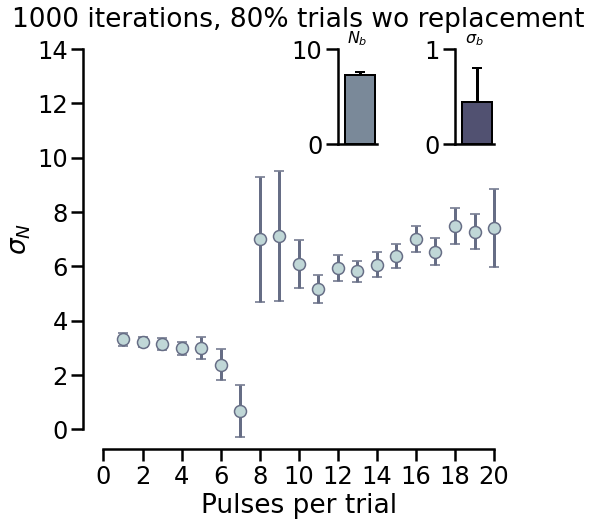

In [571]:
Nb_array = np.zeros((22,2))
sig_dN_array = np.zeros((22,2))

Nb_array[0,:] = resx_pool[0,0:2]
sig_dN_array[0,:] = resx_pool[1,0:2]

fig, ax1 = plt.subplots(figsize=(7,7))
plt.errorbar(x=np.arange(1,21),y=resx_pool[2:,0],yerr=resx_pool[2:,1],
                 marker='o',color=cmap_8[1], markeredgecolor=cmap_8[5],
                 markeredgewidth=1.5, linestyle = '', clip_on=False, ecolor=cmap_8[5], capsize=5)

plt.xticks(np.linspace(0,20,11))
plt.xlabel('Pulses per trial')
plt.ylim(0,14)
plt.xlim(0,20)
plt.ylabel('$\sigma_{N}$')
sns.despine(right=True, top=True, offset=20)

plt.title('1000 iterations, 80% trials wo replacement', pad=22)

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

ax2 = plt.axes([0,0,0.1,1])
ip = InsetPosition(ax1, [0.6,0.75,0.1,0.25])
ax2.set_axes_locator(ip)
ax2.bar(x=0.5, height=Nb_array[0,0],width=0.18,yerr=Nb_array[0,1],color=cmap_8[4], ec='k', 
        linewidth=2, error_kw=dict(zorder=0, capsize=5, capthick=2))
ax2.set_xticks([])
ax2.set_title('$N_{b}$',size=16)
plt.ylim(0, 10)
plt.xlim(0.37, 0.60)
sns.despine(right=True, top=True)
plt.rcParams['axes.titley'] = 1

ax3 = plt.axes([0,0,1,1])
ip3 = InsetPosition(ax1, [0.9,0.75,0.1,0.25])
ax3.set_axes_locator(ip3)
ax3.bar(x=0.5, height=sig_dN_array[0,0],width=0.18, yerr=sig_dN_array[0,1], color=cmap_8[6], 
        ec='k', zorder=1, linewidth=2, clip_on=False, error_kw=dict(zorder=0, capsize=5, capthick=2))

ax3.set_xticks([])
ax3.set_title('$\sigma_{b}$',size=16)
plt.ylim(0, 1)
plt.xlim(0.37, 0.60)
#ax3.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
sns.despine(right=True, top=True)
plt.rcParams['axes.titley'] = 1

fig.savefig(savepath_svg + 'numeric_approximation_error_estimate_pooled.svg', transparent=True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'numeric_approximation_error_estimate_pooled.png', transparent=True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'numeric_approximation_error_estimate_pooled.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

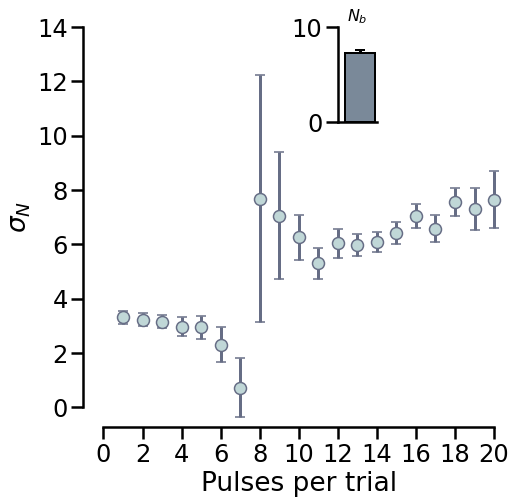

In [569]:
fig, ax1 = plt.subplots(figsize=(7,7))
plt.errorbar(x=np.arange(1,21),y=resx_pool_newfun[1:,0],yerr=resx_pool_newfun[1:,1],
                 marker='o',color=cmap_8[1], markeredgecolor=cmap_8[5],
                 markeredgewidth=1.5, linestyle = '', clip_on=False, ecolor=cmap_8[5], capsize=5)

# plt.errorbar(x=np.arange(1,21),y=resx_pool[2:,0],yerr=resx_pool[2:,1],
#                  marker='o',color='k', markeredgecolor=cmap_8[5],
#                  markeredgewidth=1.5, linestyle = '', clip_on=False, ecolor=cmap_8[5], capsize=5)


plt.xticks(np.linspace(0,20,11))
plt.xlabel('Pulses per trial')
plt.ylim(0,14)
plt.xlim(0,20)
plt.ylabel('$\sigma_{N}$')
sns.despine(right=True, top=True, offset=20)

#plt.title('1000 iterations, 80% trials wo replacement', pad=22)

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

ax2 = plt.axes([0,0,0.1,1])
ip = InsetPosition(ax1, [0.6,0.75,0.1,0.25])
ax2.set_axes_locator(ip)
ax2.bar(x=0.5, height=resx_pool_newfun[0,0],width=0.18,yerr=resx_pool_newfun[0,1],color=cmap_8[4], ec='k', 
        linewidth=2, error_kw=dict(zorder=0, capsize=5, capthick=2))
ax2.set_xticks([])
ax2.set_title('$N_{b}$',size=16)
plt.ylim(0, 10)
plt.xlim(0.37, 0.60)
sns.despine(right=True, top=True)
plt.rcParams['axes.titley'] = 1

fig.savefig(savepath_svg + 'numeric_approximation_error_estimate_pooled_nosigman.svg', transparent=True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'numeric_approximation_error_estimate_pooled_nosigman.png', transparent=True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'numeric_approximation_error_estimate_pooled_nosigman.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

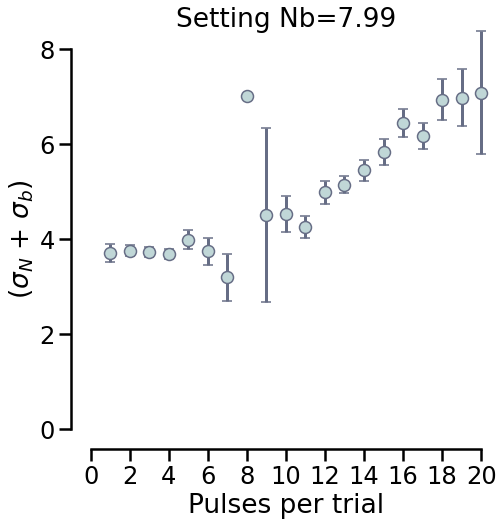

In [16]:
fig, ax1 = plt.subplots(figsize=(7,7))
plt.errorbar(x=np.arange(1,21),y=resx_pool_newfun_7[1:,0],yerr=resx_pool_newfun_7[1:,1],
                 marker='o',color=cmap_8[1], markeredgecolor=cmap_8[5],
                 markeredgewidth=1.5, linestyle = '', clip_on=False, ecolor=cmap_8[5], capsize=5)

plt.xticks(np.linspace(0,20,11))
plt.xlabel('Pulses per trial')
plt.ylim(0,8)
plt.xlim(0,20)
plt.ylabel('($\sigma_{N}$ + $\sigma_{b}$)')
sns.despine(right=True, top=True, offset=20)

plt.title('Setting Nb=7.99', pad=22)

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

# ax2 = plt.axes([0,0,0.1,1])
# ip = InsetPosition(ax1, [0.6,0.75,0.1,0.25])
# ax2.set_axes_locator(ip)
# ax2.bar(x=0.5, height=resx_pool_newfun_7[0,0],width=0.18,yerr=resx_pool_newfun_7[0,1],color=cmap_8[4], ec='k', 
#         linewidth=2, error_kw=dict(zorder=0, capsize=5, capthick=2))
# ax2.set_xticks([])
# ax2.set_title('$N_{b}$',size=16)
# plt.ylim(0, 8)
# plt.xlim(0.37, 0.60)
# sns.despine(right=True, top=True)
# plt.rcParams['axes.titley'] = 1

# fig.savefig(savepath_svg + 'numeric_approximation_error_estimate_pooled_nb799.svg', transparent=True, format='svg', bbox_inches='tight')
# fig.savefig(savepath_png + 'numeric_approximation_error_estimate_pooled_nb799.png', transparent=True, format='png', bbox_inches='tight')
# fig.savefig(savepath_pdf + 'numeric_approximation_error_estimate_pooled_nb799.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

In [331]:
import random
num_processes = 16
N_bootstrap = 20000
num_iter = 1000
batch_iter = 100
bound = (0,50)
bounds = list()

for i in range(18):
    bounds.append(bound)
bounds[1] = (0,50)
num_batch = num_iter//batch_iter
#res_array = np.zeros((22,num_iter))

resx_list = list()

for i in range(len(all_correct_trials_list)):
    res_array = np.zeros((18,num_iter))
    all_correct_trials = all_correct_trials_list[i]
    all_high_choices = all_high_choices_list[i]
    all_cum_odor = all_cum_odor_list[i]
    
    def worker(x):
        ind_bootstrap = random.sample(range(0,len(all_correct_trials)),np.round(len(all_correct_trials)*0.8).astype(int))
        new_high_choices = all_high_choices[ind_bootstrap]
        new_cum_odor = all_cum_odor[ind_bootstrap]
        choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,16)

        def loss(x):
            Nb = x[0]
            sig_dN = x[1]
            sig_Np = x[2:]
            return -compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np)

        x0 = 6+np.random.rand(18)*0 #6+np.random.rand(22)*5
        x0[1] = 1
        res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000, 'ftol':1e-6})  #1e-6})
        return res.x

    output = list()

    p = mp.Pool(processes=16)
    
    for i in tnrange(num_batch):
        batch_output = p.map(worker,range(batch_iter))
        output.extend(batch_output)
    p.close()

    res_array = np.concatenate(output).reshape(-1,18).transpose()
    #print(res_array.shape)

    resx_i_pool =np.zeros((18,3))
    resx_i_pool[:,0] = res_array.mean(1)
    resx_i_pool[:,1] = res_array.std(1)
    resx_i_pool[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)
    resx_list.append(resx_i_pool)

for i in range(len(resx_list)):
    Nb_array = np.zeros((22,2))
    sig_dN_array = np.zeros((22,2))
    resx_pool_animal = np.zeros((16,2))

    Nb_array[0,:] = resx_list[i][0,0:2]
    sig_dN_array[0,:] = resx_list[i][1,0:2]
    resx_pool_animal = resx_list[i][2:,0:2]
    #print(np.arange(1,21).shape) 

    fig, ax1 = plt.subplots(figsize=(7,7))
    plt.errorbar(x=np.arange(1,17),y=resx_pool_animal[:,0],yerr=resx_pool_animal[:,1],
                    marker='o',color=cmap_8[1], markeredgecolor=cmap_8[5],
                    markeredgewidth=1.5, linestyle = '', clip_on=True, ecolor=cmap_8[5], capsize=5)

    plt.xticks(np.linspace(0,20,11))
    plt.xlabel('Pulses per trial')
    plt.ylim(0,14)
    plt.xlim(0,20)
    plt.ylabel('$\sigma_{N}$')
    sns.despine(right=True, top=True, offset=20)

    from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

    ax2 = plt.axes([0,0,0.1,1])
    ip = InsetPosition(ax1, [0.6,0.75,0.1,0.25])
    ax2.set_axes_locator(ip)
    ax2.bar(x=0.5, height=Nb_array[0,0],width=0.18,yerr=Nb_array[0,1],color=cmap_8[4], ec='k', 
            linewidth=2, error_kw=dict(zorder=0, capsize=5, capthick=2))
    ax2.set_xticks([])
    ax2.set_title('$N_{b}$',size=16)
    plt.ylim(0, 10)
    plt.xlim(0.37, 0.60)
    sns.despine(right=True, top=True)
    plt.rcParams['axes.titley'] = 1

    ax3 = plt.axes([0,0,1,1])
    ip3 = InsetPosition(ax1, [0.9,0.75,0.1,0.25])
    ax3.set_axes_locator(ip3)
    ax3.bar(x=0.5, height=sig_dN_array[0,0],width=0.18, yerr=sig_dN_array[0,1], color=cmap_8[6], 
            ec='k', zorder=1, linewidth=2, error_kw=dict(zorder=0, capsize=5, capthick=2))

    ax3.set_xticks([])
    ax3.set_title('$\sigma_{b}$',size=16)
    plt.ylim(0, 2)
    plt.xlim(0.37, 0.60)
    #ax3.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    sns.despine(right=True, top=True)
    plt.rcParams['axes.titley'] = 1
    
    plt.title(flatten_comprehension(animal_list)[i])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'P(choice = left)')

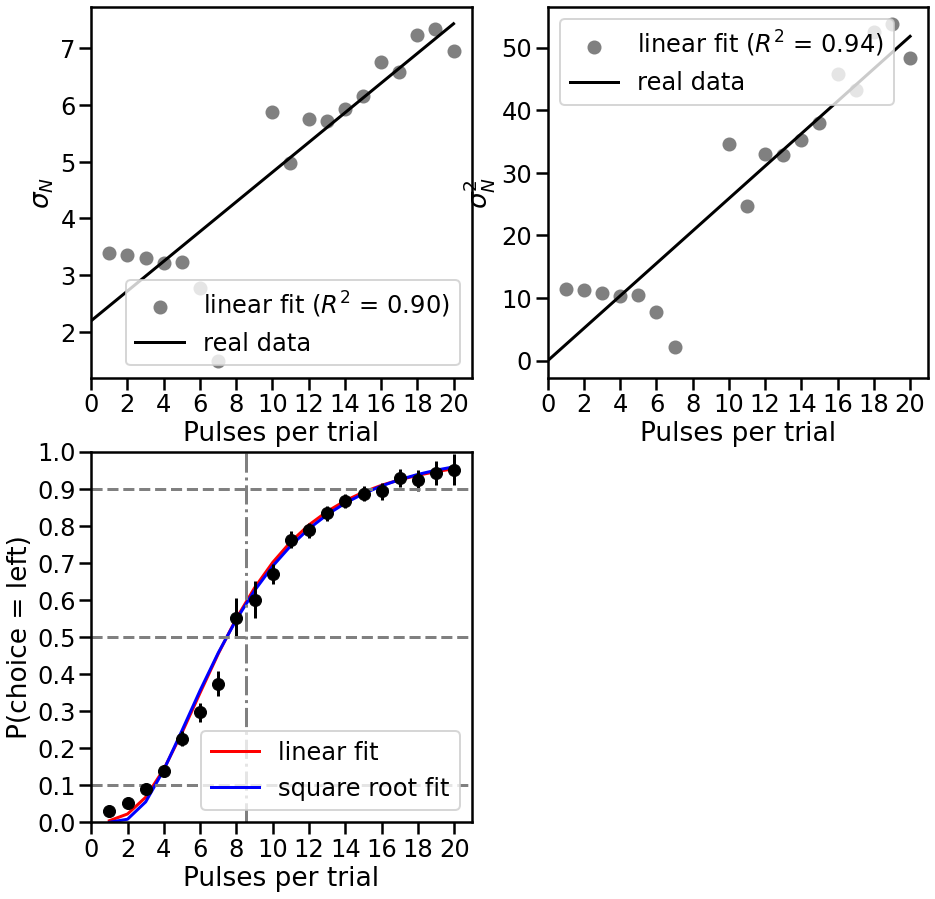

In [ ]:
fig = plt.figure(figsize=(15,15))

x_reg = np.concatenate([np.arange(1,8),np.arange(10,21)])
y_reg = resx_pool[2:,0][x_reg-1]
slope, intercept, r_value, p_value, std_err = linregress(x_reg,y_reg)
x_fit = np.linspace(0,20,21)
y_fit = x_fit * slope + intercept

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x_reg,y_reg**2)
y_fit2 = x_fit * slope2 #+ intercept2

plt.subplot(2,2,1)
plt.scatter(x_reg,y_reg,color='gray')
plt.plot(x_fit,y_fit,color='black')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,21)
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value,'real data'])
plt.xlabel('Pulses per trial')
plt.ylabel('$\sigma_N$')

plt.subplot(2,2,2)
plt.scatter(x_reg,y_reg**2,color='gray')
plt.plot(x_fit,y_fit2,color='black')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,21)
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value2,'real data'])
plt.xlabel('Pulses per trial')
plt.ylabel('$\sigma_N^2$')

plt.subplot(2,2,3)
phigh_est_lin = compute_phigh(np.arange(1,21),resx_pool[0,0],resx_pool[1,0],y_fit[1:21])
phigh_est_sq = compute_phigh(np.arange(1,21),resx_pool[0,0],resx_pool[1,0],np.sqrt(y_fit2[1:21]))
plt.plot(np.arange(1,21),phigh_est_lin,color='red')
plt.plot(np.arange(1,21),phigh_est_sq,color='blue')
plt.errorbar(np.arange(1,21),phigh[:,0],phigh[:,1],color='black',marker='o',linestyle='')
plt.xticks(np.linspace(0,20,11))
plt.legend(['linear fit','square root fit'])
plt.xlabel('Pulses per trial')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice = left)')

# fig.savefig(savepath_svg + 'noise_scaling_fits.svg', transparent=True, format='svg', bbox_inches='tight')
# fig.savefig(savepath_png + 'noise_scaling_fits.png', transparent=True, format='png', bbox_inches='tight')
# fig.savefig(savepath_pdf + 'noise_scaling_fits.pdf', transparent=True, format='pdf', bbox_inches='tight')

In [17]:
#Modelling noise scaling as the square root of number of pulses

num_processes = 16
N_bootstrap = 20042
num_iter = 1000
batch_iter = 100
bounds = [(0,20), (0, 20)]
res_array = np.zeros((2,num_iter))

def worker(x):
    np.random.seed(404)
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        #sig_dN = x[1]
        ksig = x[1]
        return -compute_logp_correct_sq(choices,Nps,Nb,ksig,Nmax=20)

    x0 = 9.5+np.random.rand(2)*5
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000}) #10000
    return res.x

output = list()


p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,2).transpose()

resx_pool_sq =np.zeros((2,3))
resx_pool_sq[:,0] = res_array.mean(1)
resx_pool_sq[:,1] = res_array.std(1)
resx_pool_sq[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)
phigh_est_sq2 = compute_phigh_sq(np.arange(1,21),resx_pool_sq[0,0],resx_pool_sq[1,0],Nmax=20)
#np.save(np_savepath+'resx_pool_sq.npy',resx_pool_sq)

resx_pool_sq

  0%|          | 0/10 [00:00<?, ?it/s]

array([[7.39385592e+00, 5.41788836e-14, 3.35804200e-15],
       [3.30581650e+00, 2.93098879e-14, 1.81664567e-15]])

In [18]:
#Modelling noise scaling as linear dependence with number of pulses

num_processes = 16
N_bootstrap = 20042
num_iter = 1000
batch_iter = 100
bounds = [(0,30), (0, 2), (0, 5)]
num_batch = num_iter//batch_iter
res_array = np.zeros((3,num_iter))
    
def worker(x):
    np.random.seed(404)

    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26

    def loss(x):
        Nb = x[0]
        #sig_dN = x[1]
        ksig = x[1]
        #sig_0 = 0
        sig_0 = x[2]
        return -compute_logp_correct_lin(choices,Nps,Nb,ksig,sig_0,Nmin=1,Nmax=20)  #Nmax=26

    x0 = 9.5+np.random.rand(3)*5 
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,3).transpose() #.reshape(-1,3)

resx_pool_lin =np.zeros((3,3))
resx_pool_lin[:,0] = res_array.mean(1)
resx_pool_lin[:,1] = res_array.std(1)
resx_pool_lin[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)
#np.save(np_savepath+'resx_pool_lin.npy',resx_pool_lin)

phigh_est_lin_MLE = compute_phigh_lin(np.arange(1,21),resx_pool_lin[0,0],resx_pool_lin[1,0],
                                  resx_pool_lin[2,0],Nmax=20)

resx_pool_lin

  0%|          | 0/10 [00:00<?, ?it/s]

array([[8.10069524e+00, 7.81597009e-14, 4.84438845e-15],
       [1.51178552e-01, 7.77156117e-16, 4.81686352e-17],
       [3.31858261e+00, 8.43769499e-14, 5.22973753e-15]])

In [19]:
#Modelling noise scaling as power law dependence with number of pulses

num_processes = 16
N_bootstrap = 15000
num_iter = 1000
batch_iter = 100
bounds = [(0,20), (0, 20), (0, 20), (0,20)]
num_batch = num_iter//batch_iter
res_array = np.zeros((4,num_iter))

    
def worker(x):
    np.random.seed(404)

    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        ind = x[3]
        return -compute_logp_correct_pow(choices,Nps,Nb,sig_dN,ksig,ind,Nmax=20)

    x0 = 4+np.random.rand(4)*3
    
    res = minimize(loss,x0,bounds=bounds,method='SLSQP', options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,4).transpose()

resx_pool_pow =np.zeros((4,3))
resx_pool_pow[:,0] = res_array.mean(1)
resx_pool_pow[:,1] = res_array.std(1)
resx_pool_pow[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)
phigh_est_pow = compute_phigh_pow(np.arange(1,21),resx_pool_pow[0,0],resx_pool_pow[1,0],
                                  resx_pool_pow[2,0],resx_pool_pow[3,0],Nmax=20)

#np.save(np_savepath+'resx_pool_pow.npy',resx_pool_pow)

resx_pool_pow

  0%|          | 0/10 [00:00<?, ?it/s]

array([[8.08853681e+00, 1.31450406e-13, 8.14738058e-15],
       [3.75561166e+00, 9.32587341e-14, 5.78023622e-15],
       [3.87735162e-02, 2.77555756e-17, 1.72030840e-18],
       [1.73532489e+00, 2.39808173e-14, 1.48634646e-15]])

In [34]:
#Modelling noise scaling as constant variance

num_processes = 16
N_bootstrap = 15000
num_iter = 1000
batch_iter = 100
bounds = [(0,20), (0,20)]
num_batch = num_iter//batch_iter

res_array = np.zeros((2,num_iter))

    
def worker(x):
    np.random.seed(404)
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        return -compute_logp_correct_const(choices,Nps,Nb,sig_dN,Nmax=20)

    x0 = 4+np.random.rand(2)*3
    
    res = minimize(loss,x0,bounds=bounds,method='SLSQP', options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,2).transpose()
resx_pool_const =np.zeros((2,3))
resx_pool_const[:,0] = res_array.mean(1)
resx_pool_const[:,1] = res_array.std(1)
resx_pool_const[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)
#np.save(np_savepath+'resx_pool_const.npy',resx_pool_pow)

phigh_est_const = compute_phigh_const(np.arange(1,21),resx_pool_const[0,0],resx_pool_const[1,0],Nmax=20)
resx_pool_const

  0%|          | 0/10 [00:00<?, ?it/s]

array([[8.70885559e+00, 1.45661261e-13, 9.02817848e-15],
       [4.63808975e+00, 4.79616347e-14, 2.97269291e-15]])

In [85]:
print(np.arange(1,21).shape)

(20,)


In [20]:
limit=6

def compute_phigh_lin_sub(Np,Nb,ksig,sig_0,Nmin=1,Nmax=18): #sig_dN,
    sig_Np = np.concatenate([np.zeros(limit),ksig*(np.arange(limit+1,Nmax+1,1))+sig_0])
    sig = np.sqrt(sig_Np**2)#+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_lin_sub(choices,Nps,Nb,ksig,sig_0,Nmin=1,Nmax=18): #sig_dN
    sig_Np = np.concatenate([np.zeros(limit),ksig*(np.arange(limit+1,Nmax+1,1))+sig_0])
    pcorrect = compute_pcorrect_new(choices,Nps,Nb,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

num_processes = 16
N_bootstrap = 20042
num_iter = 1000
batch_iter = 100
bounds = [(0,20), (0, 20), (0, 20)]
num_batch = num_iter//batch_iter

res_array = np.zeros((3,num_iter))
    
def worker(x):
    np.random.seed(404)
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26
    
    def loss(x):
        Nb = 7.99
        #sig_dN = x[1]
        ksig = x[1]
        sig_0 = x[2]
        return -compute_logp_correct_lin_sub(choices,Nps,Nb,ksig,sig_0,Nmin=1,Nmax=20)  #Nmax=26 #sig_dN

    x0 = 9.5+np.random.rand(3)*5 
    x0[0] = 7.99
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,3).transpose() #.reshape(-1,3)

resx_pool_lin_sub =np.zeros((3,3)) #np.zeros((3,2))
resx_pool_lin_sub[:,0] = res_array.mean(1)
resx_pool_lin_sub[:,1] = res_array.std(1)
resx_pool_lin_sub[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)

#np.save(np_savepath+'resx_pool_lin_sub.npy',resx_pool_lin_sub)
phigh_est_lin_sub = compute_phigh_lin_sub(np.arange(1,21),resx_pool_lin_sub[0,0],resx_pool_lin_sub[1,0],
                                  resx_pool_lin_sub[2,0],Nmax=20)

resx_pool_lin_sub

  0%|          | 0/10 [00:00<?, ?it/s]

array([[7.99000000e+00, 1.59872116e-13, 9.90897638e-15],
       [1.08370055e+01, 1.82964754e-13, 1.13402730e-14],
       [1.16543866e+01, 3.90798505e-14, 2.42219423e-15]])

In [216]:
len(all_correct_trials_all)

19896

In [21]:
def compute_phigh_lin_fakesub(Np,Nb,ksig,sig_1,sig_0,Nmin=1,Nmax=20): #ksig,sig_0,sub sig_dN
    sig_Np = np.concatenate([np.ones(limit)*sig_1,ksig*(np.arange(limit+1,Nmax+1,1))+sig_0]) # + sig_0
    sig = np.sqrt(sig_Np**2)   #Why this is not multiplied by 2 +sig_dN**2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_lin_fakesub(choices,Nps,Nb,ksig,sig_1,sig_0,Nmin=1,Nmax=20): #ksig,sig_0,sub sig_dN,
    sig_Np = np.concatenate([np.ones(limit)*sig_1,ksig*(np.arange(limit+1,Nmax+1,1))+sig_0]) # + sig_0
    pcorrect = compute_pcorrect_new(choices,Nps,Nb,sig_Np,Nmin) #sig_dN,
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

num_processes = 16
N_bootstrap = len(all_high_choices_all)
num_iter = 1000
batch_iter = 100

bounds = [(0,20), (0, 5), (0, 5), (0,5)]

num_batch = num_iter//batch_iter

res_array_lf = np.zeros((4,num_iter)) 
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(all_correct_trials_all),size=(N_bootstrap,))
    new_high_choices = all_high_choices_all[ind_bootstrap]
    new_cum_odor = all_cum_odor_all[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26
    
    def loss(x):
        Nb = x[0]
        #sig_dN = x[1]
        ksig = x[1]
        sig_1 = x[2]
        sig_0 = x[3]

        return -compute_logp_correct_lin_fakesub(choices,Nps,Nb,ksig,sig_1,sig_0,Nmin=1,Nmax=20)  #Nmax=26

    x0 = 9.5+np.random.rand(4)*5
    #x0[0] = 7.99
    x0[1] = 0.27
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000, 'ftol':'1e-9'})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array_lf = np.concatenate(output).reshape(-1,4).transpose() #.reshape(-1,3)

resx_pool_lin_fakesub =np.zeros((4,3)) #np.zeros((3,2))
resx_pool_lin_fakesub[:,0] = res_array_lf.mean(1)
resx_pool_lin_fakesub[:,1] = res_array_lf.std(1)
resx_pool_lin_fakesub[:,2] = 1.96*res_array_lf.std(1)/np.sqrt(num_iter)
#np.save(np_savepath+'resx_pool_lin_fakesub.npy',resx_pool_lin_fakesub)
phigh_est_lin_fakesub = compute_phigh_lin_fakesub(np.arange(1,21),resx_pool_lin_fakesub[0,0],
                        resx_pool_lin_fakesub[1,0], resx_pool_lin_fakesub[2,0],
                        resx_pool_lin_fakesub[3,0],Nmax=20)

resx_pool_lin_fakesub

  0%|          | 0/10 [00:00<?, ?it/s]

array([[7.93500610e+00, 8.69262782e-02, 5.38774654e-03],
       [3.26124473e-01, 4.22162838e-02, 2.61659238e-03],
       [3.68544213e+00, 9.24200477e-02, 5.72825390e-03],
       [9.85000600e-01, 5.99327915e-01, 3.71467290e-02]])

In [215]:
res_array_lf

array([[7.98845651, 7.8680362 , 7.98845651, ..., 8.01538848, 7.93773963,
        7.9154572 ],
       [0.34830709, 0.29075721, 0.34830709, ..., 0.29178957, 0.38403102,
        0.32810335],
       [3.77865034, 3.6127529 , 3.77865034, ..., 3.93170812, 3.63341514,
        3.74063225],
       [0.54752209, 1.56582266, 0.54752209, ..., 1.50068345, 0.21423382,
        0.87524399]])

In [22]:
def compute_phigh_sub_sq(Np,Nb,ksig,Nmin=1,Nmax=20): #ksig,sig_0,sub sig_dN
    sig_Np = np.concatenate([np.zeros(limit),np.sqrt(ksig*(np.arange(limit+1,Nmax+1,1)))]) # + sig_0
    sig = np.sqrt(sig_Np**2)#+sig_dN**2)   #Why this is not multiplied by 2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_sub_sq(choices,Nps,Nb,ksig,Nmin=1,Nmax=20): #ksig,sig_0,sub sig_dN
    sig_Np = np.concatenate([np.zeros(limit),np.sqrt(ksig*(np.arange(limit,Nmax+1,1)))]) # + sig_0
    pcorrect = compute_pcorrect_new(choices,Nps,Nb,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

num_processes = 16
N_bootstrap = 20042
num_iter = 1000
batch_iter = 100
bounds = [(0,50), (0,20)]

num_batch = num_iter//batch_iter

res_array = np.zeros((2,num_iter)) 
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26
    def loss(x):
        Nb = x[0]
#        sig_dN = x[1]
        ksig = x[1]

        return -compute_logp_correct_sub_sq(choices,Nps,Nb,ksig,Nmin=1,Nmax=20)  #Nmax=26 sig_dN,

    x0 = 9.5+np.random.rand(2)*5 
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,2).transpose() #.reshape(-1,3)

resx_pool_sq_sub = np.zeros((2,3)) #np.zeros((3,2))
resx_pool_sq_sub[:,0] = res_array.mean(1)
resx_pool_sq_sub[:,1] = res_array.std(1)
resx_pool_sq_sub[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)

#np.save(np_savepath+'resx_pool_lin_fakesub.npy',resx_pool_lin_fakesub)
phigh_est_sq_sub = compute_phigh_sub_sq(np.arange(1,21),resx_pool_sq_sub[0,0],
                        resx_pool_sq_sub[1,0])

resx_pool_sq_sub

  0%|          | 0/10 [00:00<?, ?it/s]

array([[12.05557321,  1.44789308,  0.08974134],
       [11.87381941,  1.45285472,  0.09004887]])

In [23]:
def compute_phigh_sq_fakesub(Np,Nb,ksig,sig_1,Nmin=1,Nmax=18): #ksig,sig_0,sub sig_dN,
    sig_Np = np.concatenate([np.ones(limit)*sig_1,np.sqrt(ksig*(np.arange(limit+1,Nmax+1,1)))]) # + sig_0
    sig = np.sqrt(sig_Np**2)   #Why this is not multiplied by 2 +sig_dN**2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_sq_fakesub(choices,Nps,Nb,ksig,sig_1,Nmin=1,Nmax=18): #ksig,sig_0,sub sig_dN,
    sig_Np = np.concatenate([np.ones(limit)*sig_1,np.sqrt(ksig*(np.arange(limit+1,Nmax+1,1)))]) # + sig_0
    pcorrect = compute_pcorrect_new(choices,Nps,Nb,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

# def compute_phigh_sq(Np,Nb,sig_dN,ksig,Nmin=1,Nmax=18):
#     sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
#     sig = np.sqrt(sig_Np**2+sig_dN**2)
#     phigh = norm.cdf((Np-Nb)/sig)
#     return phigh

# def compute_logp_correct_sq(choices,Nps,Nb,sig_dN,ksig,Nmin=1,Nmax=18):
#     sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
#     return compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np)

num_processes = 16
N_bootstrap = 20042
num_iter = 1000
batch_iter = 100

bounds = [(0,20), (0, 20), (3, 5)]

num_batch = num_iter//batch_iter

res_array = np.zeros((4,num_iter)) 
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26
    
    def loss(x):
        Nb = x[0]
        ksig = x[1]
        sig_1 = x[2]

        return -compute_logp_correct_sq_fakesub(choices,Nps,Nb,ksig,sig_1,Nmin=1,Nmax=20)  #Nmax=26

    x0 = 9.5+np.random.rand(3)*5
    x0[1] = 0.27
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000, 'ftol':'1e-9'})
    #res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,3).transpose() #.reshape(-1,3)

resx_pool_sq_fakesub =np.zeros((3,3)) #np.zeros((3,2))
resx_pool_sq_fakesub[:,0] = res_array.mean(1)
resx_pool_sq_fakesub[:,1] = res_array.std(1)
resx_pool_sq_fakesub[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)

#np.save(np_savepath+'resx_pool_lin_fakesub.npy',resx_pool_lin_fakesub)


phigh_est_sq_fakesub = compute_phigh_sq_fakesub(np.arange(1,21),resx_pool_sq_fakesub[0,0],
                        resx_pool_sq_fakesub[1,0], resx_pool_sq_fakesub[2,0],
                        Nmax=20)

resx_pool_sq_fakesub

  0%|          | 0/10 [00:00<?, ?it/s]

array([[7.85916789e+00, 9.97675253e-02, 6.18365528e-03],
       [2.28445356e+00, 9.74640914e-02, 6.04088697e-03],
       [3.63314991e+00, 1.10463692e-01, 6.84661056e-03]])

In [81]:
def compute_phigh_double_lin(Np,Nb,sig_dN,ksig_1,sig_0,ksig_2,sig_1,Nmin=1,Nmax=18): #ksig,sig_0,sub
    sig_Np = np.concatenate([ksig_1*(np.arange(Nmin,6,1))+sig_0, ksig_2*(np.arange(6,Nmax+1,1))+sig_1]) # + sig_0
    sig = np.sqrt(sig_Np**2+sig_dN**2)   #Why this is not multiplied by 2
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_double_lin(choices,Nps,Nb,sig_dN,ksig_1,sig_0,ksig_2,sig_1,Nmin=1,Nmax=18): #ksig,sig_0,sub
    sig_Np = np.concatenate([ksig_1*(np.arange(Nmin,6,1))+sig_0,ksig_2*(np.arange(6,Nmax+1,1))+sig_1]) # + sig_0
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

num_processes = 16
N_bootstrap = 15000
num_iter = 1000
batch_iter = 100
bounds = [(0,20), (0, 20), (-0.5,0.5), (3,5), (0,5), (-1,5)]
num_batch = num_iter//batch_iter
res_array = np.zeros((6,num_iter)) 
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26
    
    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig_1 = x[2]
        sig_0 = x[3]
        ksig_2 = x[4]
        sig_1 = x[5]


        return -compute_logp_correct_double_lin(choices,Nps,Nb,sig_dN,ksig_1,sig_0,ksig_2,sig_1,Nmin=1,Nmax=20)  #Nmax=26

    x0 = 9.5+np.random.rand(6)*5 
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':10000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,6).transpose() #.reshape(-1,3)

resx_pool_double_lin =np.zeros((6,3)) #np.zeros((3,2))
resx_pool_double_lin[:,0] = res_array.mean(1)
resx_pool_double_lin[:,1] = res_array.std(1)
resx_pool_double_lin[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)

phigh_est_double_lin = compute_phigh_double_lin(np.arange(1,21),resx_pool_double_lin[0,0],
                        resx_pool_double_lin[1,0], resx_pool_double_lin[2,0],
                        resx_pool_double_lin[3,0],resx_pool_double_lin[4,0],
                        resx_pool_double_lin[5,0], Nmax=20)

resx_pool_double_lin

  0%|          | 0/10 [00:00<?, ?it/s]

array([[ 7.85968671e+00,  8.88780062e-02,  5.50871590e-03],
       [ 1.45185402e+00,  9.38507470e-01,  5.81692957e-02],
       [-4.69551085e-03,  9.23105518e-02,  5.72146728e-03],
       [ 3.18909390e+00,  2.95330697e-01,  1.83047863e-02],
       [ 3.07094127e-01,  3.87702488e-02,  2.40300492e-03],
       [ 1.08139550e+00,  6.63293085e-01,  4.11113314e-02]])

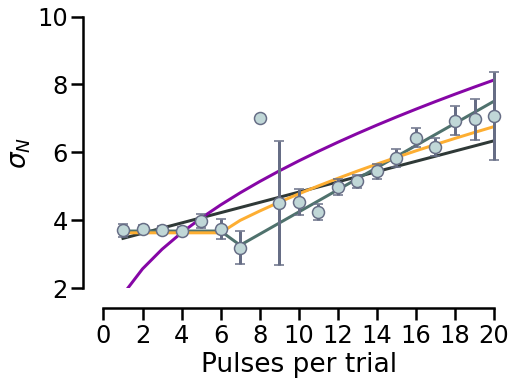

In [34]:
sigma_lin = resx_pool_lin[1,0]*(np.arange(1,21)) + resx_pool_lin[2,0]
sigma_sq = np.sqrt(resx_pool_sq[1,0]*(np.arange(1,21)))
# sigma_sub_lin = np.concatenate([np.zeros(6),
#             resx_pool_lin_sub[2,0]*(np.arange(7,21,1))+resx_pool_lin_sub[3,0]])
# sigma_sub_sq = np.concatenate([np.zeros(6),
#             np.sqrt(resx_pool_sq_sub[2,0]*(np.arange(7,21,1)))])
sigma_fsub_lin = np.concatenate([np.ones(limit)*resx_pool_lin_fakesub[2,0],
            resx_pool_lin_fakesub[1,0]*(np.arange(limit+1,21,1))+resx_pool_lin_fakesub[3,0]])
sigma_fsub_sq = np.concatenate([np.ones(limit)*resx_pool_sq_fakesub[2,0],
            np.sqrt(resx_pool_sq_fakesub[1,0]*(np.arange(limit+1,21,1)))])
#sigma_double_lin = np.concatenate([resx_pool_double_lin[2,0]*(np.arange(1,6,1))+resx_pool_double_lin[3,0],
#                                   resx_pool_double_lin[4,0]*(np.arange(6,21,1))+resx_pool_double_lin[5,0]])

fig = plt.figure(figsize=(7,5))

plt.xticks(np.linspace(0,20,11))
plt.xlabel('Pulses per trial')
plt.ylim(2,10)
plt.xlim(0,20)
plt.ylabel('$\sigma_{N}$')

plt.plot(pulse_bins[:20],sigma_lin[:20],color=cmap_12[2],linewidth=3)
#plt.plot(pulse_bins[:20],y_fit[:20],'green',linewidth=3)
#plt.plot(pulse_bins[:20],np.sqrt(y_fit2[:20]),'black',linewidth=3)
#plt.plot(pulse_bins[:20],sigma_sub_lin[:20],color=cmap_12[5],linewidth=3, clip_on=False)
plt.plot(pulse_bins[:20],sigma_fsub_lin[:20],color=cmap_12[8],linewidth=3)

plt.plot(pulse_bins[:20],sigma_sq[:20],color=cmap_11[2],linewidth=3)
#plt.plot(pulse_bins[:20],sigma_sub_sq[:20],color=cmap_13[5],linewidth=3, clip_on=False)
plt.plot(pulse_bins[:20],sigma_fsub_sq[:20],color=cmap_11[8],linewidth=3)

plt.errorbar(x=np.arange(1,21),y=resx_pool_newfun_7[1:,0],yerr=resx_pool_newfun_7[1:,1],
                 marker='o',color=cmap_8[1], markeredgecolor=cmap_8[5],
                 markeredgewidth=1.5, linestyle = '', clip_on=False, ecolor=cmap_8[5], capsize=5)

# plt.plot(pulse_bins[:20],sigma_double_lin[:20],'green',linewidth=3)


#plt.legend(['Scalar Variability (SV)','Flat Noise (L=6)+SV','Linear Variance (LV)', 'Flat Noise (L=6)+LV'], prop={'size': 13}, ncol=2)#Flat noise (limit=7) +SV', 'Flat noise (limit=7) +LV']) #, 'sub', 'sub_basal_noise', 'data'
sns.despine(right=True, top=True, offset=20)
fig.savefig(savepath_svg + 'model_fits_to_noise_estimates.svg', transparent=True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'model_fits_to_noise_estimates.png', transparent=True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'model_fits_to_noise_estimates.pdf', transparent=True, format='pdf', bbox_inches='tight')


In [75]:
# phigh_est_lin = compute_phigh(np.arange(1,21),resx_pool[0,0],resx_pool[1,0],y_fit[1:21])
# phigh_est_sq = compute_phigh(np.arange(1,21),resx_pool[0,0],resx_pool[1,0],np.sqrt(y_fit2[1:21]))

#kl1 = entropy(phigh_est_lin*bin_counts,phigh[:,0]*bin_counts)
#kl2 = entropy(phigh_est_sq*bin_counts,phigh[:,0]*bin_counts)
kl_sq2 = entropy(phigh_est_sq2*bin_counts,phigh[:,0]*bin_counts)
kl_lin_MLE = entropy(phigh_est_lin_MLE*bin_counts,phigh[:,0]*bin_counts)
kl_pow = entropy(phigh_est_pow*bin_counts,phigh[:,0]*bin_counts)
kl_const = entropy(phigh_est_const*bin_counts,phigh[:,0]*bin_counts)
kl_lin_sub = entropy(phigh_est_lin_sub*bin_counts,phigh[:,0]*bin_counts)
kl_lin_fakesub = entropy(phigh_est_lin_fakesub*bin_counts,phigh[:,0]*bin_counts)
kl_sub_sq = entropy(phigh_est_sq_sub*bin_counts,phigh[:,0]*bin_counts)
kl_fakesub_sq = entropy(phigh_est_sq_fakesub*bin_counts,phigh[:,0]*bin_counts)
#kl_double_linear = entropy(phigh_est_double_lin*bin_counts,phigh[:,0]*bin_counts)


(0.0, 0.004)

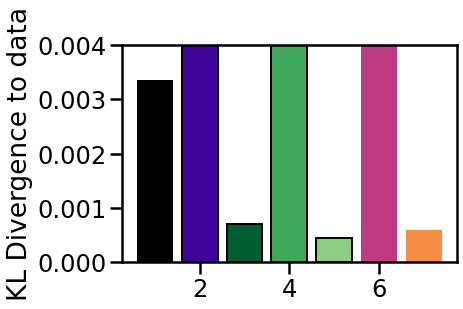

In [76]:

plt.bar(1,kl_const,color='k')
plt.bar(2,kl_sq2, color=cmap_11[0], edgecolor='k')
plt.bar(6,kl_sub_sq, color=cmap_11[4])
plt.bar(7,kl_fakesub_sq,color=cmap_11[7])

plt.bar(3,kl_lin_MLE, color=cmap_7[9], edgecolor='k')
plt.bar(4,kl_lin_sub,color=cmap_7[6], edgecolor='k')


#plt.bar(5,kl_double_linear,color='green')
plt.bar(5,kl_lin_fakesub,color=cmap_7[4], edgecolor='k')
#plt.bar(7,kl1, color='black')
p#lt.bar(8,kl_sub_sv, color='yellow')
plt.ylabel('KL Divergence to data')
#plt.legend(['Constant noise', 'LV', 'Sub(l=7)+LV', 'Flat+LV', 'SV', 'Sub(l=7)+SV', 'Flat+SV'])

plt.ylim(0, 0.004)
#plt.xlim(0, 4)



In [91]:
cmap_12 = sns.choose_dark_palette()



interactive(children=(IntSlider(value=179, description='h', max=359), IntSlider(value=49, description='s', max…

In [92]:
cmap_13 = sns.choose_dark_palette()


interactive(children=(IntSlider(value=179, description='h', max=359), IntSlider(value=49, description='s', max…

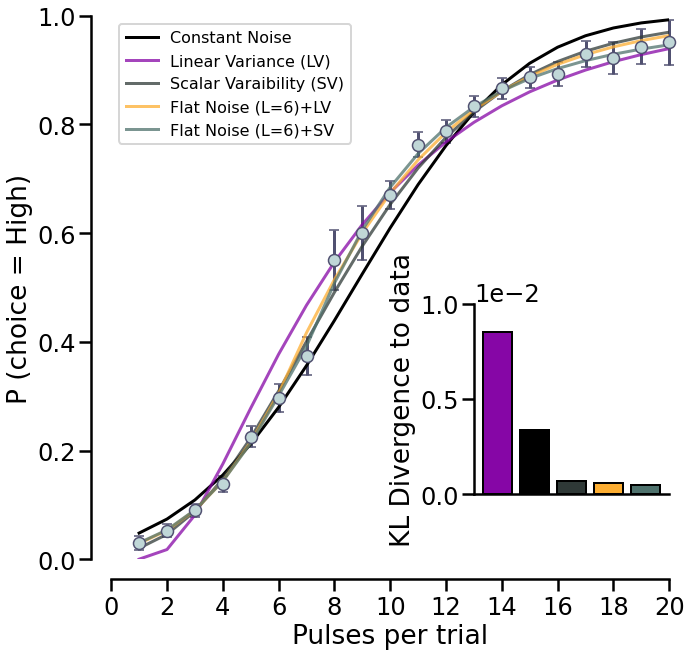

In [93]:
fig, ax1 = plt.subplots(figsize=(10,10))

ax1.errorbar(x=pulse_bins[:20],y=phigh[:20,0],yerr=phigh[:20,1],marker='o',
             color=cmap_8[1], markeredgecolor=cmap_8[6], markeredgewidth=1.5,
             linestyle = '', clip_on=False, ecolor=cmap_8[6], capsize=5)

ax1.plot(pulse_bins[:20],phigh_est_const[:20],color='k',linewidth=3, alpha=1)
ax1.plot(pulse_bins[:20],phigh_est_sq2[:20],color=cmap_11[2],linewidth=3, alpha=0.75)
ax1.plot(pulse_bins[:20],phigh_est_lin_MLE[:20],color=cmap_12[2],linewidth=3, alpha=0.75)
#plt.plot(pulse_bins[:20],phigh_est_sq_sub[:20],color=cmap_11[5],linewidth=3,alpha=0.75)
# plt.plot(pulse_bins[:20],phigh_est_lin_sub[:20],color=cmap_12[5],linewidth=3, alpha=0.75)
plt.plot(pulse_bins[:20],phigh_est_sq_fakesub[:20],color=cmap_11[8],linewidth=3,alpha=0.75)
plt.plot(pulse_bins[:20],phigh_est_lin_fakesub[:20],color=cmap_12[8],linewidth=3, alpha=0.75)

#plt.plot(pulse_bins[:20],phigh_est_double_lin[:20],color='green',linewidth=3, alpha=0.5)
#plt.plot(pulse_bins[:20],phigh_est_sq[:20],color='green',linewidth=3)
#plt.plot(pulse_bins[:20],phigh_est_lin[:20],color='black',linewidth=3)

plt.ylim(0,1)
plt.xlim(0,8)
plt.xticks(np.linspace(0,20,11))
plt.xlabel('Pulses per trial')
plt.ylabel('P (choice = High)')
plt.legend(['Constant Noise', 'Linear Variance (LV)', 'Scalar Varaibility (SV)', 'Flat Noise (L=6)+LV', 'Flat Noise (L=6)+SV'], prop={'size': 16})# Flat noise +SV [limit=7]', 'Flat noise +LV [limit=7]'])#, 'Sub(non-zero)+LV'+ 'Sub+SV']) , 'Sub+SV [limit=7]', 'Sub+LV [limit=7]' 'Sub (L=6)+LV', 'Sub (L=6)+SV', 
#ax1.xlim(0,8)

#plt.legend(['LV', 'Sub + LV', 'Sub_sigma + LV','SV', 'CV', 'sqrt fit','linear fit', 'Data'])
sns.despine(right=True, top=True, offset=20)

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.65,0.12,0.35,0.35])
ax2.set_axes_locator(ip)
ax2.bar(3,kl_lin_MLE, color=cmap_12[2], edgecolor='k')
ax2.bar(1,kl_sq2, color=cmap_11[2], edgecolor='k')
# ax2.bar(6,kl_lin_sub,color=cmap_12[5], edgecolor='k')
ax2.bar(5,kl_lin_fakesub,color=cmap_12[8], edgecolor='k')
ax2.bar(2,kl_const,color='k', edgecolor='k')
#ax2.bar(3,kl_sub_sq,color=cmap_11[5], edgecolor='k')
ax2.bar(4,kl_fakesub_sq,color=cmap_11[8], edgecolor='k')

#ax2.bar(6,kl1, color='black')
#ax2.bar(7,kl2, color='green')
ax2.set_xticks([])
ax2.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.ylim(0, 0.01)
plt.ylabel('KL Divergence to data')
sns.despine(right=True, top=True)

# fig.savefig(savepath_svg + 'model_fits_to_data_extended_new_240612.svg', transparent=True, format='svg', bbox_inches='tight')
# fig.savefig(savepath_png + 'model_fits_to_data_extended_new_240612.png', transparent=True, format='png', bbox_inches='tight')
# fig.savefig(savepath_pdf + 'model_fits_to_data_extended_new_240612.pdf', transparent=True, format='pdf', bbox_inches='tight')

In [95]:
print(all_sniff_hist_h_list[0][0:10])
print(all_sniff_hist_list[0][0:10])

[[1. 1. 1. 0. 1. 1. 2. 0. 1. 0. 1. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [1. 0. 2. 1. 4. 0. 0. 0. 2. 0. 1. 3. 1. 1.]
 [1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 2. 1. 0. 0. 1. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 2. 1. 1. 1. 1. 2. 1. 0. 3. 2. 1. 1.]
 [0. 0. 0. 1. 0. 0. 2. 1. 1. 1. 3. 3. 1. 0.]]
[[0. 1. 0. 0. 3. 1. 1. 1. 2. 1. 1. 1. 1. 1.]
 [2. 1. 3. 1. 0. 0. 2. 1. 1. 0. 0. 1. 1. 1.]
 [2. 0. 0. 1. 0. 1. 0. 3. 2. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 2. 0. 1. 0. 1. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [1. 0. 2. 1. 4. 0. 0. 0. 2. 0. 1. 3. 1. 1.]]


In [56]:
print(all_sniff_hist_list[0][236:247])

[[0. 0. 0. 3. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 2. 0. 1. 0. 2. 1. 0. 2. 2. 1. 2. 2. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 2. 1. 2. 2. 0.]
 [3. 2. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 2. 0. 3. 0. 1. 0. 1. 1. 2. 1. 1. 3.]
 [0. 0. 0. 0. 0. 0. 2. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [2. 1. 0. 3. 1. 1. 0. 0. 1. 2. 2. 1. 2. 0. 1.]
 [0. 1. 1. 1. 1. 2. 1. 0. 0. 1. 1. 1. 1. 1. 2.]
 [1. 2. 1. 2. 0. 2. 1. 0. 3. 1. 2. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0.]]


In [55]:
print(type(all_correct_trials_list[0]))
print(all_correct_trials_list[0].shape)
print(all_correct_trials_list[0][0])

print(type(all_sniff_hist_list[0]))
print(all_sniff_hist_list[0].shape)
print(all_sniff_hist_list[0][0:10,:])

print(all_session_id_list[0][0])
print(all_high_choices_list[0][236:247].astype(bool))
print(len(all_high_choices_list[0]))#[-10:-1].astype(bool))

<class 'numpy.ndarray'>
(5327,)
0.0
<class 'numpy.ndarray'>
(5327, 15)
[[0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 2. 0. 0. 0. 3. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0. 3. 1. 2. 2. 1. 1. 2. 1. 0.]
 [0. 2. 0. 1. 1. 1. 0. 2. 1. 1. 1. 0. 0. 1. 1.]
 [2. 0. 0. 2. 0. 1. 0. 2. 1. 2. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [3. 0. 0. 0. 1. 0. 1. 1. 2. 1. 1. 1. 0. 1. 0.]]
Bengal_20190419_0
[False False False  True  True False False  True  True  True False]
5327


In [32]:
num_processes = 16
N_bootstrap = 15000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,15)) #15
all_sniff_hist_shuffled_all = np.zeros((0,15)) #15
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    norm_given_odor = all_cum_odor_hist_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<21)
    norm_given_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_hist_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_hist_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_h_list[animal_ind][selected_trials]
    #all_sniff_hist = all_sniff_hist_list[animal_ind][selected_trials]
    #all_sniff_hist_shuffled = all_sniff_hist_shuffled_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_h_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
def worker(x):
    #ind_bootstrap = random.sample(range(0,len(norm_given_odor_all)),np.round(len(norm_given_odor_all)*0.8).astype(int))
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    X5 = all_sniff_hist_shuffled_all[ind_bootstrap]
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    clf5 = LogisticRegression().fit(X5, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100, clf5.score(X5,y)*100]
    #print(clf3.coef_[0][0:15])
    #weights = clf3.coef_[0][0:15]
    weights_2 = clf2.coef_[0][0:15]/clf2.coef_[0][0:15].max()
    weights_3 = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max() #[0:15] [0:15]
    #print(weights)
    #weights = weights/weights.max()
    #print(weights)
    weights_shuffled = clf5.coef_[0][0:15]/clf5.coef_[0][0:15].max() #[0:15]
    #weights_shuffled = weights_shuffled/weights_shuffled.max()
    trial_history = clf3.coef_[0][15:]/clf3.coef_[0][15:].max() #[35:14:-1] [0:15]
    #print(trial_history)
    return accuracy,weights_2,weights_3,trial_history,weights_shuffled

output = list()
    
for i in tnrange(num_iter):
    output.append(worker(0))


  0%|          | 0/1000 [00:00<?, ?it/s]

In [1]:
print(norm_given_odor_all)

NameError: name 'norm_given_odor_all' is not defined

In [33]:
accuracy_list = list()
weights_list_2 = list()
weights_list_3 = list()
weights_shuffled_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output[i][0])
    weights_list_2.append(output[i][1])
    weights_list_3.append(output[i][2])
    trial_history_list.append(output[i][3])
    weights_shuffled_list.append(output[i][4])

print(output[100][1])
print(output[100][2])


accuracy_mat = np.concatenate(accuracy_list).reshape(-1,5)
accuracy_mean = accuracy_mat.mean(axis=0)
accuracy_std = accuracy_mat.std(axis=0)
accuracy_error = 1.96*accuracy_std/np.sqrt(num_iter)

weights_mat_2 = np.concatenate(weights_list_2).reshape(-1,15) #15
weights_mean_2 = weights_mat_2.mean(axis=0)
weights_std_2 = weights_mat_2.std(axis=0)
weights_error_2 = 1.96*weights_std_2/np.sqrt(num_iter)

weights_mat_3 = np.concatenate(weights_list_3).reshape(-1,15) #15
weights_mean_3 = weights_mat_3.mean(axis=0)
weights_std_3 = weights_mat_3.std(axis=0)
weights_error_3 = 1.96*weights_std_3/np.sqrt(num_iter)

trial_history_mat = np.concatenate(trial_history_list).reshape(-1,6)
trial_history_mean = trial_history_mat.mean(axis=0)
trial_history_std = trial_history_mat.std(axis=0)
trial_history_error = 1.96*trial_history_std/np.sqrt(num_iter)

weights_shuffled_mat = np.concatenate(weights_shuffled_list).reshape(-1,15) #15
weights_shuffled_mean = weights_shuffled_mat.mean(axis=0)
weights_shuffled_std = weights_shuffled_mat.std(axis=0)
weights_shuffled_error = 1.96*weights_shuffled_std/np.sqrt(num_iter)
# plt.plot(np.minimum(weights_mean_2,1-weights_mean_2)/np.minimum(weights_mean_2,1-weights_mean_2).max())
# plt.plot(weights_std/weights_std.max())
# plt.show()

[0.5887456  0.94886553 1.         0.92665211 0.72045879 0.56731232
 0.50569944 0.47027034 0.29221662 0.40549334 0.46272993 0.44170807
 0.57234825 0.40462269 0.63782786]
[0.55935412 0.91962273 1.         0.9051676  0.70174072 0.55564358
 0.50435451 0.44081016 0.28413711 0.38919569 0.42838816 0.42927887
 0.52849515 0.3928838  0.64676898]


In [35]:
trial_history_mean

array([0.45683157, 0.27128461, 0.27172635, 0.3932543 , 0.82119387,
       0.99626126])

In [36]:
weights_mean

NameError: name 'weights_mean' is not defined

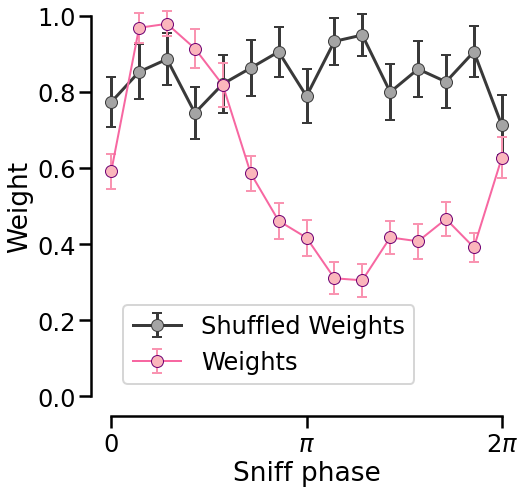

In [34]:
# sns.set_style('ticks')
# sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 2, "legend.fontsize":14})
# sns.despine()

phase = np.linspace(0,2*np.pi,15)
plt.figure(figsize=(7,7))
#uplims = np.ones(15)
#plt.plot(phase,sniff_rolled,color='g')

plt.errorbar(phase,weights_shuffled_mean,yerr=weights_shuffled_std, color = greys[8], ecolor=greys[8],
             capsize=5,capthick=2, marker='o',markerfacecolor=greys[4],markeredgecolor=greys[8], 
             clip_on=False)
plt.errorbar(phase,weights_mean_2,yerr=weights_std_2,color = c_2(0.5), linewidth=2,
             capsize=5, capthick=2, marker='o',markerfacecolor=c_2(0.3),markeredgecolor=c_2(0.9),
             ecolor=c_2(0.4), clip_on=False)
plt.legend(['Shuffled Weights','Weights'], loc='best')
plt.xlabel('Sniff phase')
plt.ylabel('Weight')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)
ax = plt.gca()
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_xticklabels(['0','$\pi$','$2\pi$'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(right=True, top=True, offset=20)
# plt.savefig(savepath_svg + 'sniffing_weights_behavior.svg', transparent=True, format='svg', bbox_inches='tight')
# plt.savefig(savepath_png + 'sniffing_weights_behavior.png', transparent=True, format='png', bbox_inches='tight')
# plt.savefig(savepath_pdf + 'sniffing_weights_behavior.pdf', transparent=True, format='pdf', bbox_inches='tight')
plt.show()


In [85]:
with h5py.File('./adaptation_data_HW1_50ms_struct.mat', 'r') as f:
    breath = f['imaging_struct/breath'][:]
    odor = f['imaging_struct/odor'][:]
    valve = f['imaging_struct/valve'][:]
    df_data = f['imaging_struct/df_data'][:]

breath.shape

(2119200, 1)

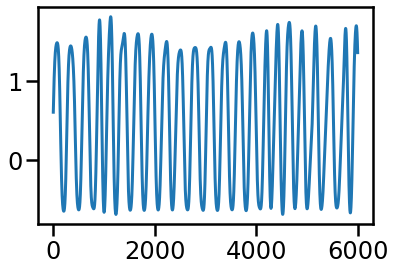

In [154]:
sniff = butter_lowpass_filter(breath.flatten(),10,1000,3)
sniff = (sniff - sniff.mean()+1)/2
plt.plot(sniff[852000:858000])

In [244]:
int(38.1*(10000)+(38.1/2)*(10000))

571500

231000
538000


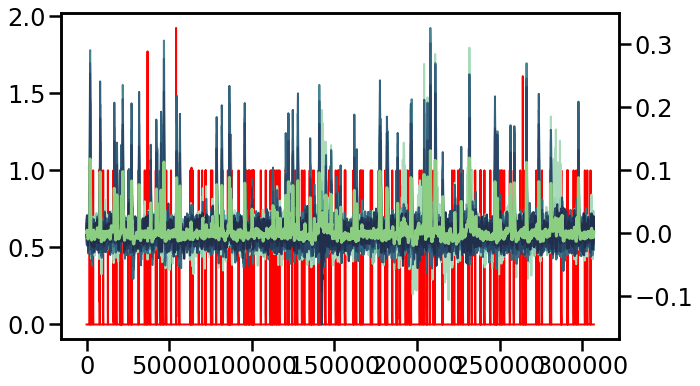

In [248]:
# fig, ax1 = plt.subplots(figsize=(10,6))

begin = int(38.1*(10000)-(15)*(10000)) #27.5 35
end = int(38.8*(10000)+(15)*(10000)) #28 36

print(begin)
print(end)
interval = end-begin
samp_interval = 100
# #ax1.plot(sniff[1100000:1160000])
# ax1.plot(sniff[begin:end], linewidth=2, color='k')



fig, ax1 = plt.subplots(figsize=(10,6))

#ax1.plot(sniff[1100000:1160000])
ax1.plot(odor[begin:end], linewidth=2, color='r')
#ax1.plot(sniff[begin:end], linewidth=2, color='k')
#ax1.set_ylim(-4,0)

ax2 = ax1.twinx()

for i in range(df_data.shape[1]):

    ax2.plot(np.linspace(0,interval,int(interval/samp_interval)), 
            df_data[int(begin/samp_interval):int(end/samp_interval), i], 
            color=glom_palette_2[i], linewidth=2)

ax2.plot(np.linspace(0,interval,int(interval/samp_interval)), 
                     df_data.mean(1)[int(begin/samp_interval):int(end/samp_interval)],
                     color=cmap_7[4], linewidth=3)

#ax2.set_ylim(-2,2.55)
#ax2.plot(valve[1133500:1138500], color='g')
#plt.xlim(340,440)

fig.savefig(savepath_svg + 'rep_traces_odor_breathin_calcium_long.svg',transparent=True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'rep_traces_odor_breathin_calcium_long.png',transparent=True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'rep_traces_odor_breathin_calcium_long.pdf',transparent=True, format='pdf', bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(10,6))

# for i in range(df_data.shape[1]):

#     plt.plot(df_data[int(begin/100):int(end/100), i], color=glom_palette_2[i], linewidth=2)

# plt.plot(df_data.mean(1)[int(begin/100):int(end/100)], color=cmap_7[4], linewidth=3)

408000
420000


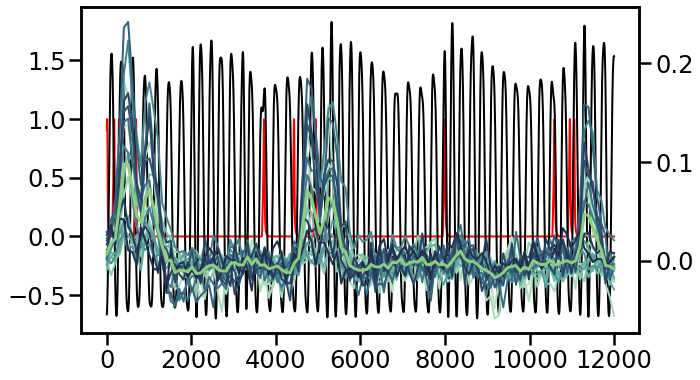

In [247]:
# fig, ax1 = plt.subplots(figsize=(10,6))

begin = int(40.8*(10000)) #27.5 35
end = int(42*(10000)) #28 36

print(begin)
print(end)
interval = end-begin
samp_interval = 100
# #ax1.plot(sniff[1100000:1160000])
# ax1.plot(sniff[begin:end], linewidth=2, color='k')



fig, ax1 = plt.subplots(figsize=(10,6))

#ax1.plot(sniff[1100000:1160000])
ax1.plot(odor[begin:end], linewidth=2, color='r')
ax1.plot(sniff[begin:end], linewidth=2, color='k')
#ax1.set_ylim(-4,0)

ax2 = ax1.twinx()

for i in range(df_data.shape[1]):

    ax2.plot(np.linspace(0,interval,int(interval/samp_interval)), 
            df_data[int(begin/samp_interval):int(end/samp_interval), i], 
            color=glom_palette_2[i], linewidth=2)

ax2.plot(np.linspace(0,interval,int(interval/samp_interval)), 
                     df_data.mean(1)[int(begin/samp_interval):int(end/samp_interval)],
                     color=cmap_7[4], linewidth=3)

#ax2.set_ylim(-2,2.55)
#ax2.plot(valve[1133500:1138500], color='g')
#plt.xlim(340,440)

#fig.savefig(savepath_svg + 'rep_traces_odor_breathin_calcium_zoom.svg',transparent=True, format='svg', bbox_inches='tight')
#fig.savefig(savepath_png + 'rep_traces_odor_breathin_calcium_zoom.png',transparent=True, format='png', bbox_inches='tight')
#fig.savefig(savepath_pdf + 'rep_traces_odor_breathin_calcium_zoom.pdf',transparent=True, format='pdf', bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(10,6))

# for i in range(df_data.shape[1]):

#     plt.plot(df_data[int(begin/100):int(end/100), i], color=glom_palette_2[i], linewidth=2)

# plt.plot(df_data.mean(1)[int(begin/100):int(end/100)], color=cmap_7[4], linewidth=3)

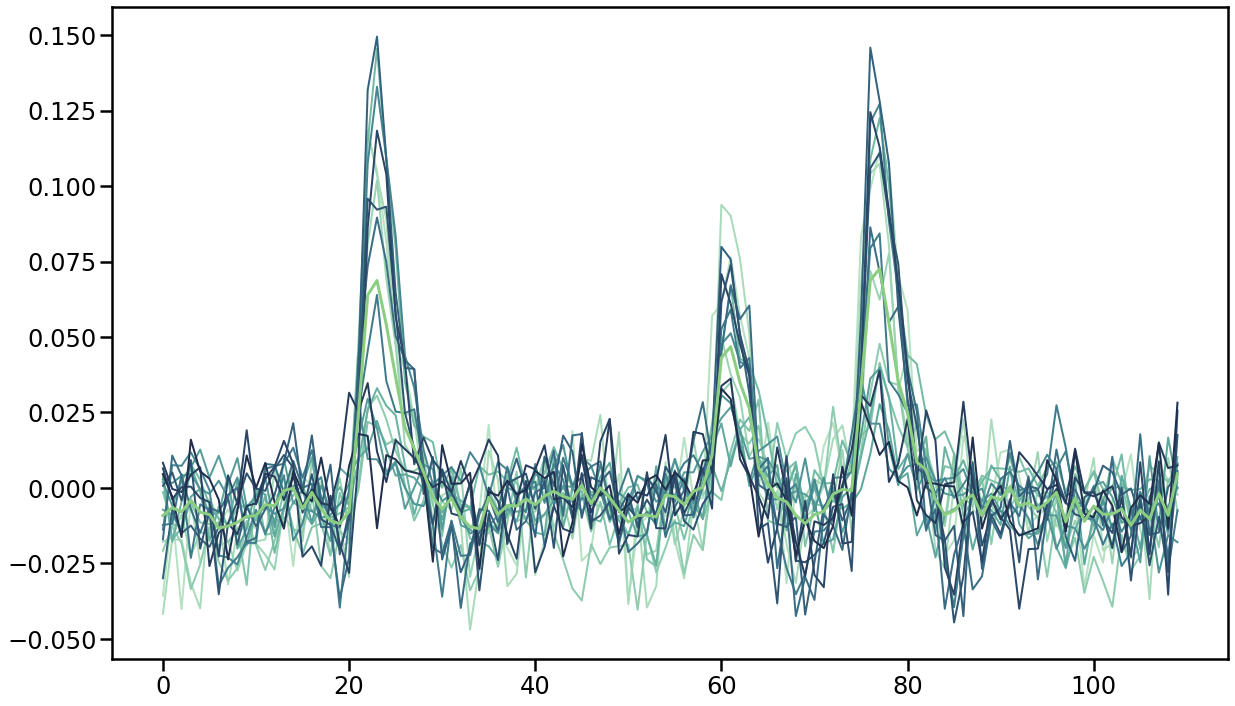

In [107]:
fig, ax = plt.subplots(figsize=(20,12))

for i in range(df_data.shape[1]):

    plt.plot(df_data[500:610, i], color=glom_palette_2[i], linewidth=2)

plt.plot(df_data.mean(1)[500:610], color=cmap_7[4], linewidth=3)

# fig.savefig(savepath_svg + 'rep_traces_calcium_reduced.svg',transparent=True, format='svg', bbox_inches='tight')
# fig.savefig(savepath_png + 'rep_traces_calcium_reduced.png',transparent=True, format='png', bbox_inches='tight')
# fig.savefig(savepath_pdf + 'rep_traces_calcium_reduced.pdf',transparent=True, format='pdf', bbox_inches='tight')

In [22]:
sphinx = file['Spinx_50ms_sniff_locked']
plt.plot(sphinx[1])
#plt.xlim(19800, 20500)

IndexError: index 1 is out of bounds for axis 0 with size 1

(75000.0, 76000.0)

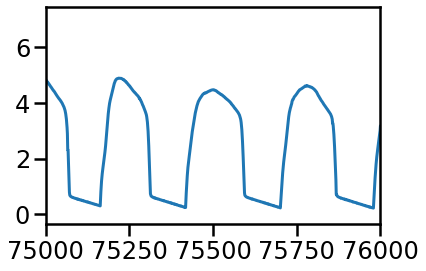

In [30]:
hw1 = file['HW1_respiration']
plt.plot(hw1[0])
plt.xlim(75000, 76000)

(75000.0, 76000.0)

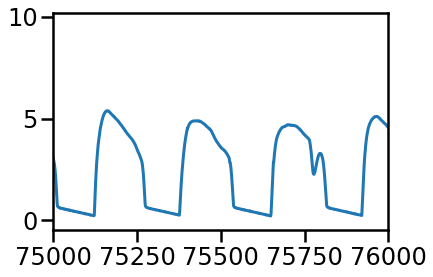

In [31]:
hw4 = file['HW4_respiration']
plt.plot(hw4[0])
plt.xlim(75000, 76000)

In [159]:
cmap_7

[(0.977362552864283, 0.9915109573241061, 0.7735332564398308),
 (0.9164936562860438, 0.9673817762399077, 0.6872587466359092),
 (0.822560553633218, 0.9289042675893887, 0.6256516724336794),
 (0.692641291810842, 0.87280276816609, 0.5636447520184544),
 (0.5455747789311803, 0.8090119184928873, 0.5042214532871973),
 (0.39277201076509033, 0.7382698961937716, 0.4348942714340638),
 (0.2452133794694348, 0.657993079584775, 0.3563091118800461),
 (0.1566320645905421, 0.5428373702422146, 0.27953863898500575),
 (0.06082276047673972, 0.45650134563629374, 0.23653979238754327),
 (0.0, 0.36962706651287963, 0.200399846212995)]

dict_keys(['__header__', '__version__', '__globals__', 'HW1_mid', 'HW1_onset', 'HW1_peak', 'HW4_mid', 'HW4_onset', 'HW4_peak', 'Sphinx_mid', 'Sphinx_onset', 'Sphinx_peak'])
(18, 15)
dict_keys(['__header__', '__version__', '__globals__', 'HW1_mid', 'HW1_onset', 'HW1_peak', 'HW4_mid', 'HW4_onset', 'HW4_peak', 'Sphinx_mid', 'Sphinx_onset', 'Sphinx_peak'])
(53, 15)
dict_keys(['__header__', '__version__', '__globals__', 'HW1_mid', 'HW1_onset', 'HW1_peak', 'HW4_mid', 'HW4_onset', 'HW4_peak', 'Sphinx_mid', 'Sphinx_onset', 'Sphinx_peak'])
(35, 15)


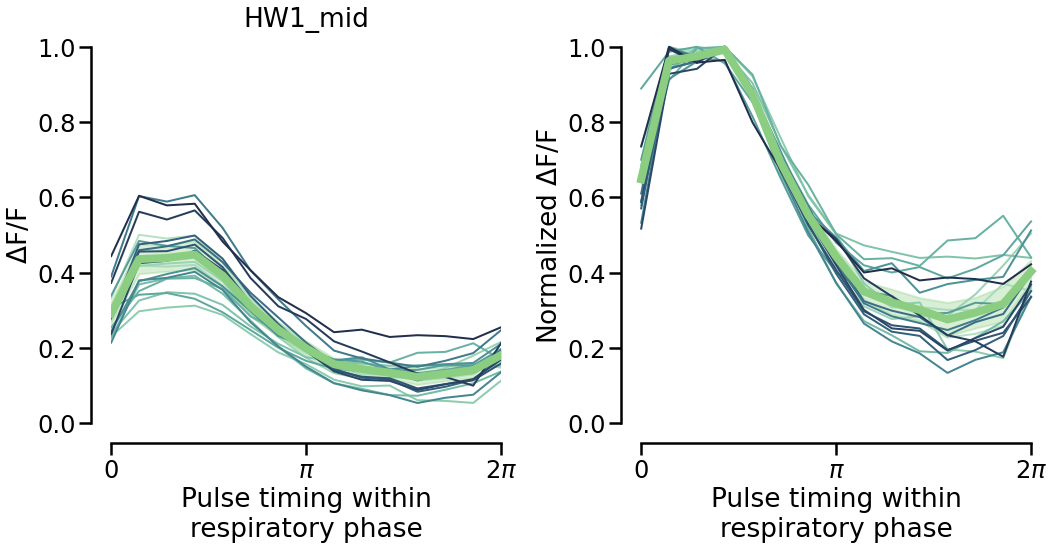

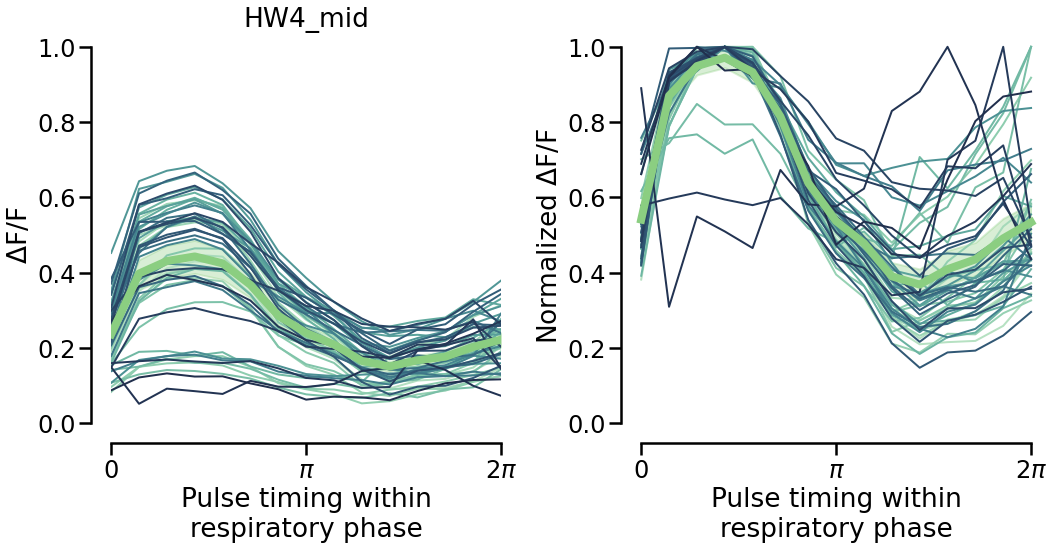

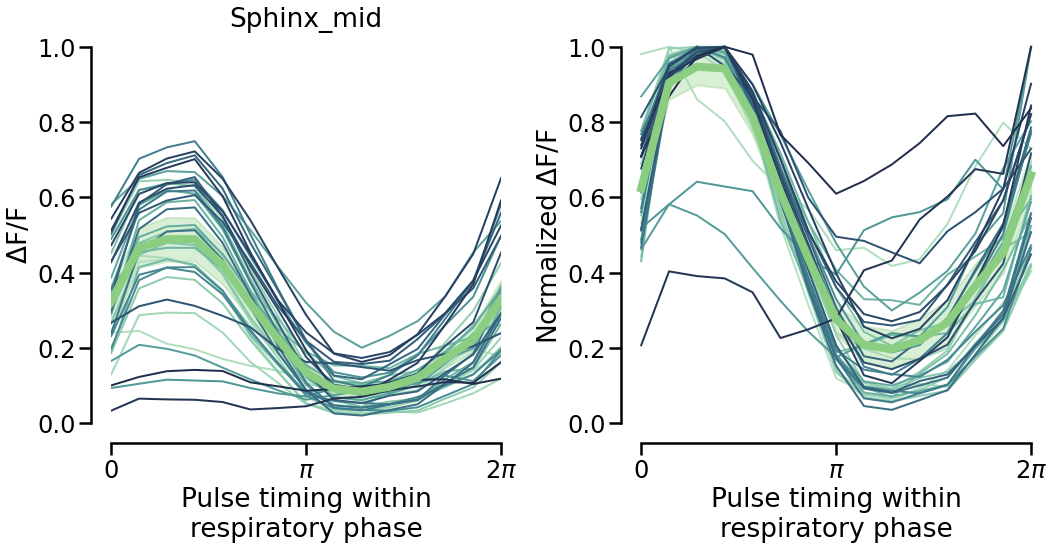

In [12]:
#matlab_filepath = os.getcwd() + '/kernels.mat'
matlab_filepath = os.getcwd() + '/Kernel_workspace.mat'

def phase_transform(x):
    return (0+((x-1)*(2*np.pi-0)/(14)))

def calcium_kernel(matlab_filepath, table_name):
    file = scipy.io.loadmat(matlab_filepath)
    print(file.keys())
    glom_matrix = file[table_name]
    print(glom_matrix.shape)
    kernel_mean = glom_matrix.mean(0)
    kernel_std = glom_matrix.std(0)  
    norm_glom_matrix = np.ones_like(glom_matrix)
    colx = [i for i in range(1,16)]  

    for i in range(glom_matrix.shape[0]):
        norm_glom_matrix[i,:] = glom_matrix[i,:]/glom_matrix[i,:].max()

    df_g = pd.DataFrame(glom_matrix, columns=colx)
    df_g.insert(0, 'Glom', np.arange(0,len(glom_matrix)))
    df_g2 = df_g.melt(id_vars='Glom', var_name='Bin', value_name='dF_F')
    df_g2['Breathing phase'] = df_g2['Bin'].apply(phase_transform)
    df_g2['Animal'] = table_name

  
    df_gn = pd.DataFrame(norm_glom_matrix, columns=colx)
    df_gn.insert(0, 'Glom', np.arange(0,len(norm_glom_matrix)))
    df_gn2 = df_gn.melt(id_vars='Glom', var_name='Bin', value_name='dF_F')
    df_gn2['Breathing phase'] = df_gn2['Bin'].apply(phase_transform)
    df_gn2['Animal'] = table_name
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

    sns.lineplot(x=df_g2['Breathing phase'], y=df_g2['dF_F'], hue=df_g2['Glom'], legend=False, 
             palette=glom_palette, linewidth=2, clip_on=True, ax=ax1)
    
    sns.lineplot(x=df_g2['Breathing phase'], y=df_g2['dF_F'], errorbar=('ci'),
                 color=cmap_7[4], linewidth=8, ax=ax1, err_kws={'alpha':0.33}) #wistia_palette[1]
    
    ax1.set_xticks([0,np.pi,2*np.pi])
    ax1.set_xticklabels(['0','$\pi$','$2\pi$'])
    ax1.set_xlim(0,2*np.pi)
    ax1.set_ylim(0,1)
    ax1.set_ylabel('$\Delta $F/F',)
    ax1.set_xlabel('Pulse timing within\nrespiratory phase')
    ax1.set_title(table_name, pad=20)

    sns.despine(offset=20)

    sns.lineplot(x=df_gn2['Breathing phase'], y=df_gn2['dF_F'], hue=df_g2['Glom'], legend=False, 
             palette=glom_palette, linewidth=2, clip_on=False, ax=ax2) #sns.color_palette("mako", as_cmap=True)
    
    sns.lineplot(x=df_gn2['Breathing phase'], y=df_gn2['dF_F'], errorbar=('ci'),
                 color=cmap_7[4], linewidth=8, ax=ax2, err_kws={'alpha':0.33}, clip_on=False)

    ax2.set_xticks([0,np.pi,2*np.pi])
    ax2.set_xticklabels(['0','$\pi$','$2\pi$'])
    ax2.set_xlim(0,2*np.pi)
    ax2.set_ylim(0,1.)
    ax2.set_ylabel('Normalized $\Delta $F/F')
    ax2.set_xlabel('Pulse timing within\nrespiratory phase')
    sns.despine(offset=20)
    plt.tight_layout(pad=2)

    return fig, df_g2, df_gn2

fig_hw1, table_hw1, table_hw1_norm =  calcium_kernel(matlab_filepath, 'HW1_mid')
fig_hw4, table_hw4, table_hw4_norm =  calcium_kernel(matlab_filepath, 'HW4_mid')
fig_sphinx, table_sphinx, table_sphinx_norm =  calcium_kernel(matlab_filepath, 'Sphinx_mid')

fig_hw1.savefig(savepath_svg + 'all_glomerular_weights_hw1_peak.svg', transparent=True, format='svg', bbox_inches='tight')
fig_hw1.savefig(savepath_png + 'all_glomerular_weights_hw1_peak.png', transparent=True, format='png', bbox_inches='tight')
fig_hw1.savefig(savepath_pdf + 'all_glomerular_weights_hw1_peak.pdf', transparent=True, format='pdf', bbox_inches='tight')

fig_hw4.savefig(savepath_svg + 'all_glomerular_weights_hw4_peak.svg', transparent=True, format='svg', bbox_inches='tight')
fig_hw4.savefig(savepath_png + 'all_glomerular_weights_hw4_peak.png', transparent=True, format='png', bbox_inches='tight')
fig_hw4.savefig(savepath_pdf + 'all_glomerular_weights_hw4_peak.pdf', transparent=True, format='pdf', bbox_inches='tight')

fig_sphinx.savefig(savepath_svg + 'all_glomerular_weights_sphinx_peak.svg', transparent=True, format='svg', bbox_inches='tight')
fig_sphinx.savefig(savepath_png + 'all_glomerular_weights_sphinx_peak.png', transparent=True, format='png', bbox_inches='tight')
fig_sphinx.savefig(savepath_pdf + 'all_glomerular_weights_sphinx_peak.pdf', transparent=True, format='pdf', bbox_inches='tight')

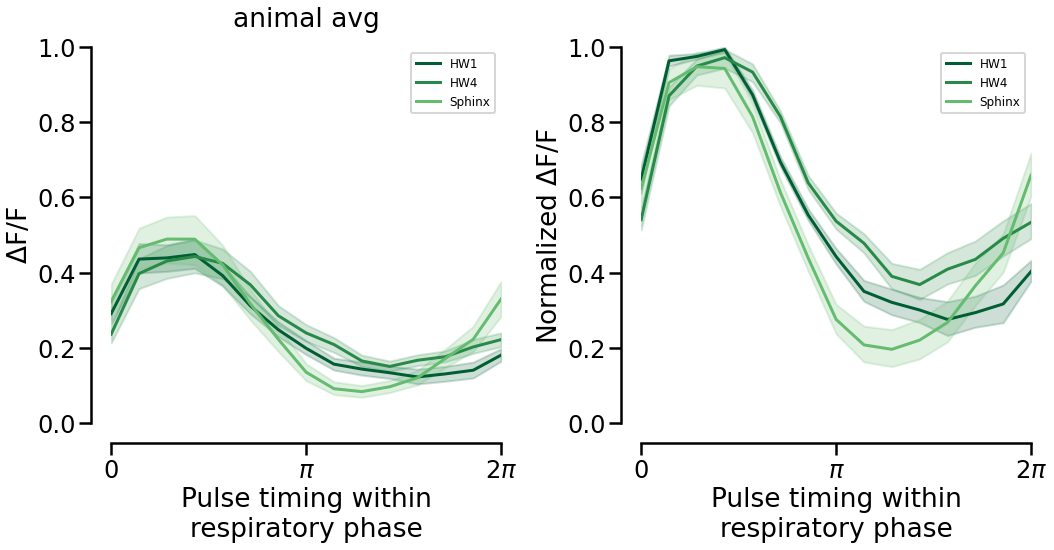

In [13]:
calcium_data_combined = pd.concat([table_hw1, table_hw4, table_sphinx], axis=0).reset_index(drop=True)
calcium_normalized = pd.concat([table_hw1_norm, table_hw4_norm, table_sphinx_norm], axis=0).reset_index(drop=True)

fig_avg, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1 = sns.lineplot(x=calcium_data_combined['Breathing phase'], 
             y=calcium_data_combined['dF_F'], 
             hue=calcium_data_combined['Animal'],
             palette=cmap_7[-1::-2], ax=ax1)

handles, labels = ax1.get_legend_handles_labels()

handlex = [h for h, l in zip(handles, labels) if 'Animal' in l]
labelx = ['HW1', 'HW4', 'Sphinx']

ax1.legend(handles=handles, labels=labelx, fontsize='large')
ax1.set_xticks([0,np.pi,2*np.pi])
ax1.set_xticklabels(['0','$\pi$','$2\pi$'])
ax1.set_xlim(0,2*np.pi)
ax1.set_ylim(0,1)
ax1.set_ylabel('$\Delta $F/F',)
ax1.set_xlabel('Pulse timing within\nrespiratory phase')
ax1.set_title('animal avg', pad=20)


sns.despine(offset=20)


ax2 = sns.lineplot(x=calcium_normalized['Breathing phase'], 
             y=calcium_normalized['dF_F'], 
             hue=calcium_normalized['Animal'],
             palette=cmap_7[-1::-2], ax=ax2, legend=False)

ax2.legend(handles=handles, labels=labelx, fontsize='large')

ax2.set_xticks([0,np.pi,2*np.pi])
ax2.set_xticklabels(['0','$\pi$','$2\pi$'])
ax2.set_xlim(0,2*np.pi)
ax2.set_ylim(0,1)
ax2.set_ylabel('Normalized $\Delta $F/F',)
ax2.set_xlabel('Pulse timing within\nrespiratory phase')
sns.despine(offset=20)
plt.tight_layout(pad=2)

fig_avg.savefig(savepath_svg + 'avg_glomerular_weights_all_animals_peak.svg', transparent=True, format='svg', bbox_inches='tight')
fig_avg.savefig(savepath_png + 'avg_glomerular_weights_all_animals_peak.png', transparent=True, format='png', bbox_inches='tight')
fig_avg.savefig(savepath_pdf + 'avg_glomerular_weights_all_animals_peak.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

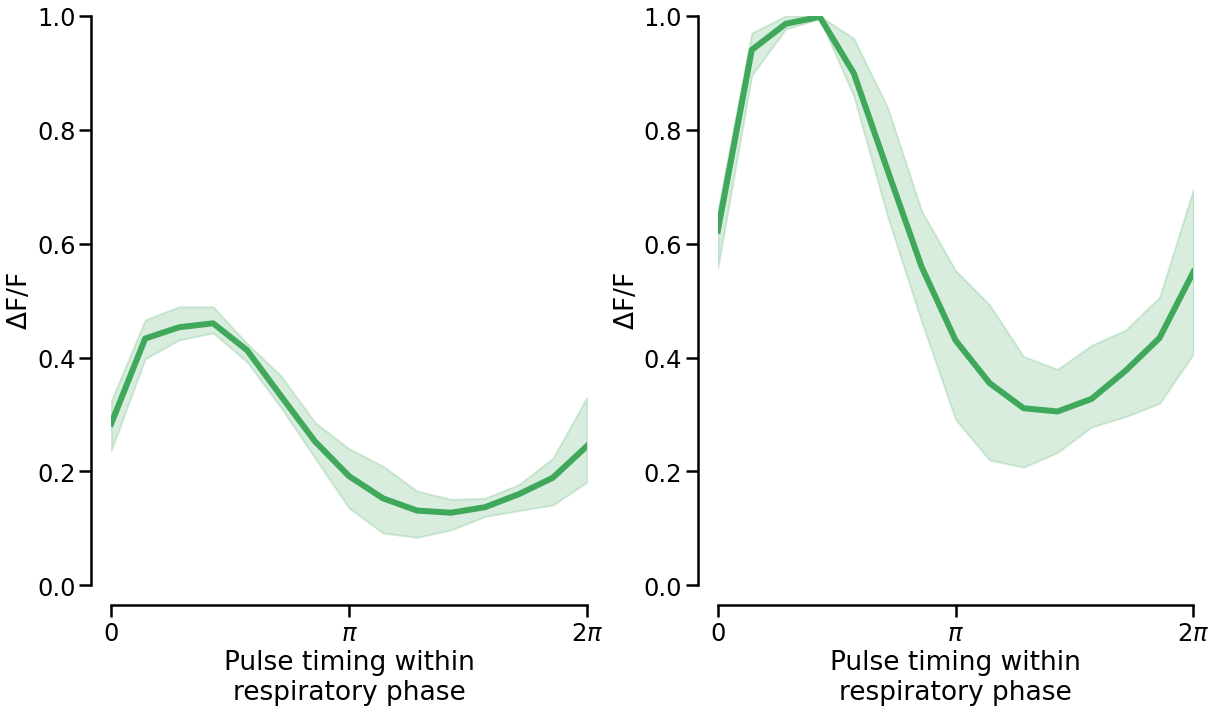

In [14]:
#Not really using it, just in case Venki asks. 

grouped_dfnorm = calcium_normalized.groupby(['Breathing phase', 'Animal'])['dF_F'].mean().reset_index()
grouped_dfnorm_2 = grouped_dfnorm.groupby('Animal')['dF_F'].max().reset_index()
final_df_2 = grouped_dfnorm.merge(grouped_dfnorm_2, on='Animal', how='left')
final_df_2['Norm dF_F'] = final_df_2['dF_F_x']/final_df_2['dF_F_y']
#final_df_2

grouped_df = calcium_data_combined.groupby(['Breathing phase', 'Animal'])['dF_F'].mean().reset_index()
grouped_df_2 = grouped_df.groupby('Animal')['dF_F'].max().reset_index()
final_df = grouped_df.merge(grouped_df_2, on='Animal', how='left')
final_df['Norm dF_F'] = final_df['dF_F_x']/final_df['dF_F_y']
#final_df

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,10))

plot1 = sns.lineplot(x=final_df['Breathing phase'], 
             y=final_df['dF_F_x'], linewidth=6, ax=ax1, color=cmap_7[6])

plot2 = sns.lineplot(x=final_df_2['Breathing phase'], 
             y=final_df_2['Norm dF_F'], linewidth=6, ax=ax2, color=cmap_7[6])

plot1.set_xticks([0,np.pi,2*np.pi])
plot1.set_xticklabels(['0','$\pi$','$2\pi$'])
plot1.set_xlim(0,2*np.pi)
plot1.set_ylim(0,1)
plot1.set_ylabel('$\Delta $F/F',)
plot1.set_xlabel('Pulse timing within\nrespiratory phase')
sns.despine(offset=20)

plot2.set_xticks([0,np.pi,2*np.pi])
plot2.set_xticklabels(['0','$\pi$','$2\pi$'])
plot2.set_xlim(0,2*np.pi)
plot2.set_ylim(0,1)
plot2.set_ylabel('$\Delta $F/F',)
plot2.set_xlabel('Pulse timing within\nrespiratory phase')

plt.tight_layout()
plt.show()

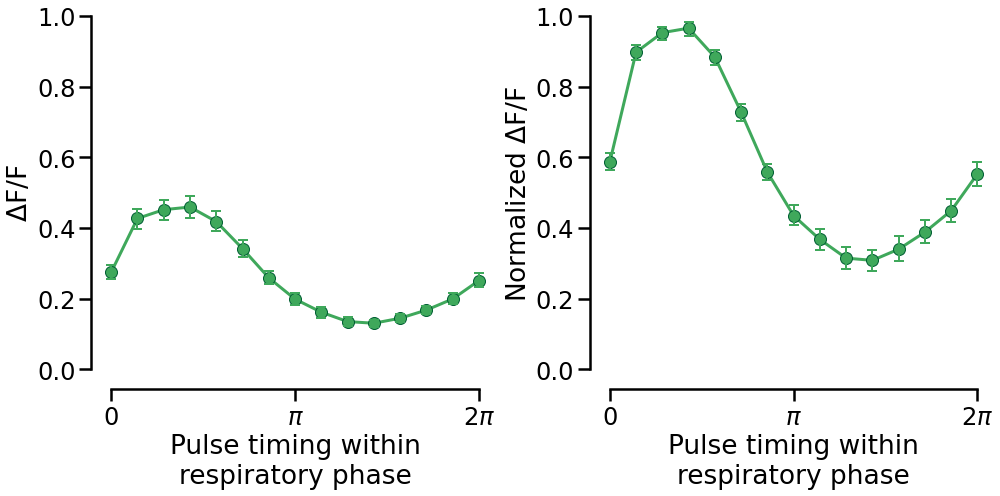

In [15]:
fig_kernel, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

plot1 = sns.lineplot(x=calcium_data_combined['Breathing phase'], 
             y=calcium_data_combined['dF_F'], ax=ax1, marker="o", dashes=False, markersize=12, 
             err_style='bars', legend=False, err_kws={'capsize':5,'capthick':2,'elinewidth':2,'clip_on':False},
             color=cmap_7[6], markeredgewidth=1, markerfacecolor=cmap_7[6],markeredgecolor=cmap_7[9], clip_on=False)

plot2 = sns.lineplot(x=calcium_normalized['Breathing phase'], 
             y=calcium_normalized['dF_F'], ax=ax2, marker="o", dashes=False, markersize=12, 
             err_style='bars', legend=False, err_kws={'capsize':5,'capthick':2,'elinewidth':2, 'clip_on':False},
             color=cmap_7[6], markeredgewidth=1, markerfacecolor=cmap_7[6],markeredgecolor=cmap_7[9], clip_on=False)

plot1.set_xticks([0,np.pi,2*np.pi])
plot1.set_xticklabels(['0','$\pi$','$2\pi$'])
plot1.set_xlim(0,2*np.pi)
plot1.set_ylim(0,1)
plot1.set_ylabel('$\Delta $F/F',)
plot1.set_xlabel('Pulse timing within\nrespiratory phase')
sns.despine(offset=20)

plot2.set_xticks([0,np.pi,2*np.pi])
plot2.set_xticklabels(['0','$\pi$','$2\pi$'])
plot2.set_xlim(0,2*np.pi)
plot2.set_ylim(0,1)
plot2.set_ylabel('Normalized $\Delta $F/F' ,)
plot2.set_xlabel('Pulse timing within\nrespiratory phase')

plt.tight_layout()

# fig_kernel.savefig(savepath_svg + 'calcium_kernel_average_peak.svg', transparent=True, format='svg', bbox_inches='tight')
# fig_kernel.savefig(savepath_png + 'calcium_kernel_average_peak.png', transparent=True, format='png', bbox_inches='tight')
# fig_kernel.savefig(savepath_pdf + 'calcium_kernel_average_peak.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

In [1]:
calcium_normalized

NameError: name 'calcium_normalized' is not defined

In [16]:
avg_calcium_array = calcium_normalized.groupby('Breathing phase')['dF_F'].mean().reset_index()
print((avg_calcium_array['dF_F'][2]))

0.9525877411251332


In [80]:
phase_codes_df = pd.read_csv('phase_normalized_to_max.csv')

In [67]:
len(phase_codes_df['phase_rad'].unique())

15

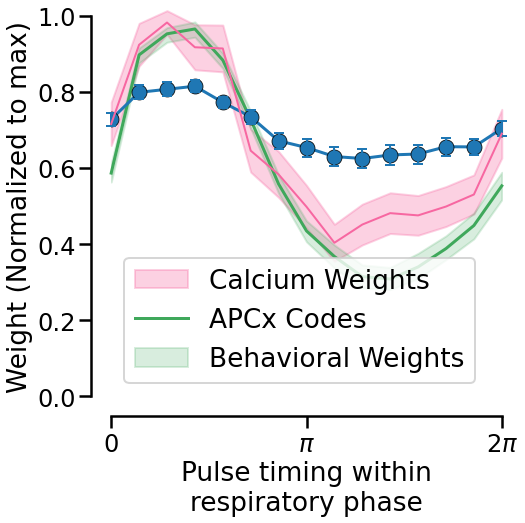

In [260]:
# sns.set_style('ticks')
# sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 2, "legend.fontsize":14})
# sns.despine()

phase = np.linspace(0,2*np.pi,15)
plt.figure(figsize=(7,7))
#uplims = np.ones(15)
#plt.plot(phase,sniff_rolled,color='g')


# plt.errorbar(phase,weights_mean_2,yerr=weights_std_2, marker='o', capsize=5,capthick=2, linewidth=2,
#              color = c_2(0.5), markerfacecolor=c_2(0.3),markeredgecolor=c_2(0.9), ecolor=c_2(0.4), clip_on=False)
plt.errorbar(phase,weights_mean_2,ls='-', linewidth=2, color = c_2(0.5), clip_on=False)


plt.fill_between(phase,weights_mean_2-weights_std_2, weights_mean_2+weights_std_2, linewidth=2,
             color = c_2(0.5), alpha=0.3, clip_on=False)

# plt.errorbar(phase,weights_shuffled_mean,yerr=weights_shuffled_std, marker='o', capsize=5,capthick=2, linewidth=2,
#              color = greys[6], ecolor=greys[6], markerfacecolor=greys[3],markeredgecolor=greys[8], clip_on=False)
#sns.lineplot(data=calcium_normalized.loc[calcium_normalized['Animal']=='HW4_mid'], x='Breathing phase', y='dF_F', legend=False, color='green')
sns.lineplot(data=calcium_normalized, x='Breathing phase', y='dF_F', dashes=False, 
             err_style='band', errorbar=('ci',95), legend=False, 
             color=cmap_7[6], markeredgewidth=1, markerfacecolor=cmap_7[6],markeredgecolor=cmap_7[9], clip_on=False) #
            #err_kws={'capsize':5,'capthick':2,'elinewidth':2, 'clip_on':False} marker="o", markersize=12, 
sns.lineplot(data=phase_codes_df, x='phase_rad', y='mean_norm', err_style='bars', errorbar=('ci',95), marker='o', markersize=15, markeredgecolor='k', 
             legend=False, err_kws={'capsize':5,'capthick':2,'elinewidth':2, 'clip_on':False})

# plt.plot(phase, weights_norm)

plt.legend(['Calcium Weights','APCx Codes','Behavioral Weights'], loc='best', fontsize='medium')

plt.xlabel('Pulse timing within\nrespiratory phase')
plt.ylabel('Weight (Normalized to max)')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)
ax = plt.gca()
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_xticklabels(['0','$\pi$','$2\pi$'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(right=True, top=True, offset=20)
plt.savefig(savepath_svg + 'apcx_codes_beh_weights_and_calcium_newver.svg', transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'apcx_codes_beh_weights_and_calcium_newver.png', transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'apcx_codes_beh_weights_and_calcium_newver.pdf', transparent=True, format='pdf', bbox_inches='tight')
plt.show()


In [58]:
#np.save(np_savepath+'resx_pool_lin_sub.npy',resx_pool_lin_sub)
weights_mean_2.shape
weights_std_2.shape
beh_weights = np.vstack([weights_mean_2, weights_error_2]).T
print(beh_weights.shape, beh_weights)

np.save('beh_weights_dependence_mean_CI.npy', beh_weights)


(15, 2) [[0.71577505 0.00352399]
 [0.92381705 0.00348817]
 [0.9822921  0.00192864]
 [0.91725779 0.00366733]
 [0.91407813 0.00380928]
 [0.64554462 0.00349051]
 [0.58304552 0.00373943]
 [0.4981262  0.00348235]
 [0.403492   0.00300495]
 [0.45134086 0.00332146]
 [0.48133579 0.00331509]
 [0.47541976 0.00323138]
 [0.49868856 0.00324944]
 [0.53033529 0.0031831 ]
 [0.69026188 0.00396002]]


In [57]:
from scipy.stats import sem, t

def ci95(series):
    n = len(series)
    if n < 2:
        return np.nan  # Avoid division errors for small groups
    mean = series.mean()
    std_err = sem(series)  # Standard Error of Mean (SEM)
    ci_range = t.ppf(0.975, df=n-1) * std_err  # 1.96 for large samples
    return (mean - ci_range, mean + ci_range)

agg_calcium_normalized = calcium_normalized.groupby(['Breathing phase'])['dF_F'].agg(['mean', ('CI_lower', lambda x: ci95(x)[0]), ('CI_upper', lambda x: ci95(x)[1])])
calcium_vector_mean_CI = agg_calcium_normalized[['mean', 'CI_lower', 'CI_upper']].to_numpy()
np.save('calcium_phase_dependence_mean_CI.npy', calcium_vector_mean_CI)


ValueError: Unrecognized marker style ['o']

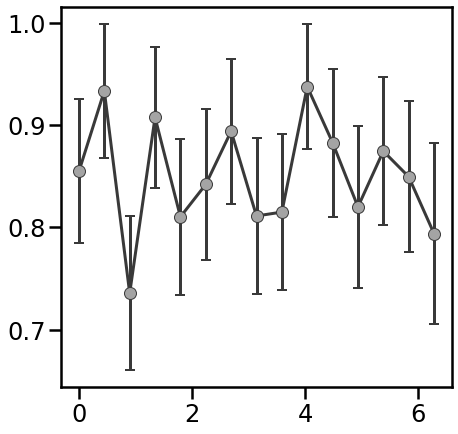

In [227]:
# sns.set_style('ticks')
# sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 2, "legend.fontsize":14})
# sns.despine()

phase = np.linspace(0,2*np.pi,15)
plt.figure(figsize=(7,7))
#uplims = np.ones(15)
#plt.plot(phase,sniff_rolled,color='g')

plt.errorbar(phase,weights_shuffled_mean,yerr=weights_shuffled_std, color = greys[8], ecolor=greys[8],
             capsize=5,capthick=2, marker='o',markerfacecolor=greys[4],markeredgecolor=greys[8], 
             clip_on=False)
plt.errorbar(phase,weights_mean_2,yerr=weights_std_2,color = c_2(0.5), linewidth=2,
             capsize=5, capthick=2, marker=['o'],markerfacecolor=c_2(0.3),markeredgecolor=c_2(0.9),
             ecolor=c_2(0.4), clip_on=False)

plt.legend(['Shuffled Weights','Weights'], loc='best')
sns.lineplot(x=table_hw1_norm['Breathing phase'], 
             y=table_hw1_norm['dF_F'], legend=False, color='green')

plt.xlabel('Sniff phase')
plt.ylabel('Weight')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)
ax = plt.gca()
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_xticklabels(['0','$\pi$','$2\pi$'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(right=True, top=True, offset=20)
# plt.savefig(savepath_svg + 'sniffing_weights_behavior.svg', transparent=True, format='svg', bbox_inches='tight')
# plt.savefig(savepath_png + 'sniffing_weights_behavior.png', transparent=True, format='png', bbox_inches='tight')
# plt.savefig(savepath_pdf + 'sniffing_weights_behavior.pdf', transparent=True, format='pdf', bbox_inches='tight')
plt.show()

(15, 18)
[[0.37203362 0.40175986 0.33880444 0.35814715 0.33570439 0.35952119
  0.41096669 0.35014971 0.35126133 0.35620225 0.32800071 0.35577609
  0.4625032  0.30780422 0.44423014 0.36809982 0.41752971 0.28157182]
 [0.82916279 0.91006524 0.89864272 0.88469729 0.89372137 0.89328711
  0.93770446 0.85091307 0.85394947 0.87607708 0.8453177  0.87387922
  0.96041867 0.80875464 0.93296677 0.86133261 0.96020902 0.78133057]
 [0.82916279 0.91006524 0.94632267 0.93038615 0.94135406 0.90048605
  0.93770446 0.86215072 0.91127096 0.95854882 0.93367715 0.93451459
  0.96041867 0.91041236 0.94291296 0.91622489 0.96020902 0.93507037]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.        ]
 [0.72036063 0.86677325 0.82664611 0.87728586 0.8253201  0.83295421
  0.87213061 0.860624   0.90589468 0.91879917 0.89904318 0.89830832
  0.89273575 0.90851154 0.94291296 0.91622489 0.866

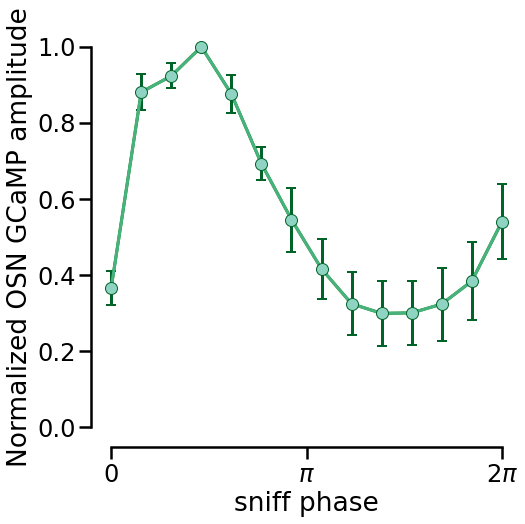

In [503]:
with h5py.File(os.getcwd() + '/HW_Data/pack_data_new/Sphinx_sniff_kernel.mat', 'r') as file:
    dset = file['Sphinx_sniff_kernel']
    kernels = dset[:]
    print(kernels.shape)
    sniff_kernel = kernels.mean(axis=1).squeeze()
    sniff_kernel_std = kernels.std(axis=1).squeeze()
    print(kernels)
    
sniff_rolled = sniff_kernel
sniff_rolled = sniff_rolled/sniff_rolled.max()

phase = np.linspace(0,2*np.pi,14)
plt.figure(figsize=(7,7))
plt.plot(phase,sniff_rolled[0:14],color='g')

#plt.plot(phase,weights_shuffled_mean,'gray')
plt.errorbar(phase,sniff_rolled[0:14],color=colors[2],yerr=sniff_kernel_std[0:14],ecolor=colors[5],
             capsize=5,marker='o',markerfacecolor=colors[0],markeredgecolor=colors[5], capthick=2, clip_on=False)
plt.xlabel('sniff phase')
plt.ylabel('Normalized OSN GCaMP amplitude')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)
ax = plt.gca()
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_xticklabels(['0','$\pi$','$2\pi$'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(right=True, top=True, offset=20)

# plt.savefig(savepath_svg + 'sniff_kernel_ORN.svg', transparent=True, format='svg', bbox_inches='tight')
# plt.savefig(savepath_png + 'sniff_kernel_ORN.png', transparent=True, format='png', bbox_inches='tight')
# plt.savefig(savepath_pdf + 'sniff_kernel_ORN.pdf', transparent=True, format='pdf', bbox_inches='tight')
# #plt.savefig(savepath+'sniff_kernel_ORN.svg', bbox_inches='tight')
# plt.show()
plt.show()
    

In [108]:
plt.figure(figsize=(7,7))


plt.errorbar(phase,sniff_rolled[0:14],color=colors[2],yerr=sniff_kernel_std[0:14],ecolor=colors[5],
             capsize=5,marker='o',markerfacecolor=colors[0],markeredgecolor=colors[5], capthick=2, clip_on=False)
plt.errorbar(phase,weights_mean,yerr=weights_std, color = c_2(0.5), capsize=5, capthick=2, marker='o',
             markerfacecolor=c_2(0.3),markeredgecolor=c_2(0.9),ecolor=c_2(0.4),clip_on=False)
plt.errorbar(phase,weights_shuffled_mean,yerr=weights_shuffled_std, color = greys[8], ecolor=greys[8],
             capsize=5,capthick=2, marker='o',markerfacecolor=greys[4],markeredgecolor=greys[8], clip_on=False)

plt.xlabel('Sniff phase')
plt.ylabel('Weight')

plt.ylim(0,1)
plt.xlim(0,2*np.pi)
plt.legend(['OSN Activity', 'Behavior', 'Beh shuffled'], loc='lower left', fontsize=18)

ax = plt.gca()
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_xticklabels(['0','$\pi$','$2\pi$'])
sns.despine(right=True, top=True, offset=20)

plt.savefig(savepath_svg + 'behavior_vs_calcium_weights.svg', transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'behavior_vs_calcium_weights.png', transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'behavior_vs_calcium_weights.pdf', transparent=True, format='pdf', bbox_inches='tight')


NameError: name 'sniff_rolled' is not defined

<Figure size 504x504 with 0 Axes>

6.5094580063805e-09
0.9647444950297303


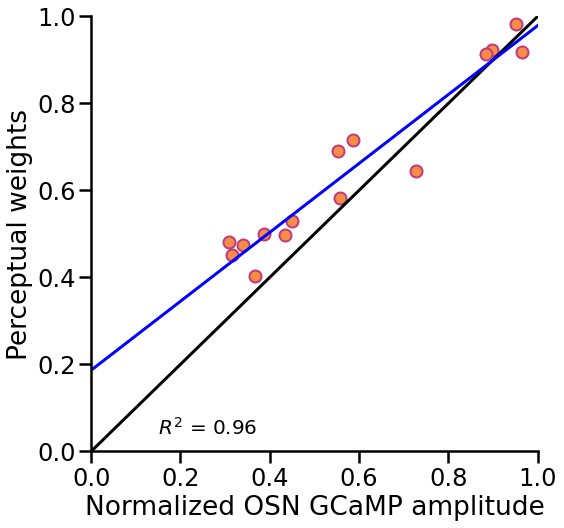

[1.        0.9647445]


In [18]:
xsk = avg_calcium_array['dF_F']
ysk = weights_mean_2
slope, intercept, r_value, p_value, std_err = linregress(xsk,ysk)
print(p_value)
xid = np.linspace(-1,2,20)
yid = np.linspace(-1,2,20)
new_x = np.linspace(0,1,100)
new_y = new_x*slope+intercept

plt.figure(figsize=(8,8))
plt.scatter(avg_calcium_array['dF_F'],weights_mean_2, color=cmap_11[7], edgecolors=cmap_11[4], clip_on=False)
plt.plot(xid,yid,'k')
plt.plot(new_x, new_y, 'b')
#plt.plot(np.linspace(0,1,20),np.linspace(0,1,20)*slope+intercept,'k')

plt.xlabel('Normalized OSN GCaMP amplitude')
plt.ylabel('Perceptual weights')
plt.xlim(0,1)
plt.ylim(0,1)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.savefig('figures/ca_vs_weights.svg')
ax.text(0.15, 0.03, '$R^2$ = %.2f'%r_value,
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='k', fontsize=20)

print(r_value)

rho = np.corrcoef(avg_calcium_array['dF_F'],weights_mean_2)
plt.savefig(savepath_svg + 'behavior_vs_calcium_weights_regression_peak.svg', transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'behavior_vs_calcium_weights_regression_peak.png', transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'behavior_vs_calcium_weights_regression_peak.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

print(rho[0])

In [19]:
p_value

6.5094580063805e-09

In [ ]:
#Here is only analyzing the close to boundary trials (7-9 pulses) trials

num_processes = 16
N_bootstrap = 16000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,14))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    norm_given_odor = all_cum_odor_hist_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>6,norm_given_odor<10)
    norm_given_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_hist_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_hist_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_h_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_h_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    weights = clf3.coef_[0][0:14]/clf3.coef_[0][0:14].max() #15
    weights = weights/weights.max()
    trial_history = clf3.coef_[0][35:14:-1]/clf3.coef_[0][0:14].max() #[35:15:-1] [0:15]
    return accuracy,weights,trial_history

output_low = list()
    
for i in tnrange(num_iter):
    output_low.append(worker(0))

accuracy_list = list()
weights_list = list()
weights_shuffled_list = list()
trial_history_list = list()

for i in range(num_iter):
    accuracy_list.append(output_low[i][0])
    weights_list.append(output_low[i][1])
    trial_history_list.append(output_low[i][2])
    
accuracy_mat_low = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean_low = accuracy_mat_low.mean(axis=0)
accuracy_std_low = accuracy_mat_low.std(axis=0)
accuracy_error_low = 1.96*accuracy_std_low/np.sqrt(num_iter)

weights_mat_low = np.concatenate(weights_list).reshape(-1,14)
weights_mean_low = weights_mat_low.mean(axis=0)
weights_std_low = weights_mat_low.std(axis=0)
weights_error_low = 1.96*weights_std_low/np.sqrt(num_iter)

trial_history_mat_low = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean_low = trial_history_mat_low.mean(axis=0)
trial_history_std_low = trial_history_mat_low.std(axis=0)
trial_history_error_low = 1.96*trial_history_std_low/np.sqrt(num_iter)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
#Here is only analyzing the correct trials

num_processes = 16
N_bootstrap = 16000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,14))
all_sniff_hist_shuffled_all = np.zeros((0,14))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    all_correct_trials = all_correct_trials_hist_list[animal_ind].astype(np.int).astype(np.bool)
    selected_trials = all_correct_trials
    norm_given_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    
    all_high_choices = all_high_choices_hist_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_h_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_h_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
    
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    X5 = all_sniff_hist_shuffled_all[ind_bootstrap]
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    clf5 = LogisticRegression().fit(X5, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    weights = clf3.coef_[0][0:14]/clf3.coef_[0][0:14].max()
    weights = weights/weights.max()
    weights_shuffled = clf5.coef_[0][0:14]/clf5.coef_[0][0:14].max()
    weights_shuffled = weights_shuffled/weights_shuffled.max()
    trial_history = clf3.coef_[0][35:14:-1]/clf3.coef_[0][0:14].max()
    return accuracy,weights,trial_history,weights_shuffled

output_correct = list()
    
for i in tnrange(num_iter):
    output_correct.append(worker(0))
    
accuracy_list = list()
weights_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output_correct[i][0])
    weights_list.append(output_correct[i][1])
    trial_history_list.append(output_correct[i][2])

accuracy_mat_correct = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean_correct = accuracy_mat_correct.mean(axis=0)
accuracy_std_correct = accuracy_mat_correct.std(axis=0)
accuracy_error_correct = 1.96*accuracy_std_correct/np.sqrt(num_iter)    
    
weights_mat_correct = np.concatenate(weights_list).reshape(-1,14)
weights_mean_correct= weights_mat_correct.mean(axis=0)
weights_std_correct  = weights_mat_correct .std(axis=0)
weights_error_correct  = 1.96*weights_std_correct /np.sqrt(num_iter)

trial_history_mat_correct  = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean_correct = trial_history_mat_correct.mean(axis=0)
trial_history_std_correct = trial_history_mat_correct.std(axis=0)
trial_history_error_correct = 1.96*trial_history_std_correct/np.sqrt(num_iter)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
#Here is only analyzing the wrong trials.

num_processes = 16
N_bootstrap = 16000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,14))
all_sniff_hist_shuffled_all = np.zeros((0,14))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    all_correct_trials = all_correct_trials_hist_list[animal_ind].astype(np.int).astype(np.bool)
    selected_trials = np.invert(all_correct_trials)
    norm_given_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    
    all_high_choices = all_high_choices_hist_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_h_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_h_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    X5 = all_sniff_hist_shuffled_all[ind_bootstrap]
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    clf5 = LogisticRegression().fit(X5, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    weights = clf3.coef_[0][0:14]/clf3.coef_[0][0:14].max()
    weights = weights/weights.max()
    weights_shuffled = clf5.coef_[0][0:14]/clf5.coef_[0][0:14].max()
    weights_shuffled = weights_shuffled/weights_shuffled.max()
    trial_history = clf3.coef_[0][35:14:-1]/clf3.coef_[0][0:14].max()
    return accuracy,weights,trial_history,weights_shuffled

output_wrong = list()
    
for i in tnrange(num_iter):
    output_wrong.append(worker(0))

accuracy_list = list()
weights_list = list()
trial_history_list = list()

for i in range(num_iter):
    accuracy_list.append(output_wrong[i][0])
    weights_list.append(output_wrong[i][1])
    trial_history_list.append(output_wrong[i][2])

accuracy_mat_wrong = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean_wrong = accuracy_mat_wrong.mean(axis=0)
accuracy_std_wrong = accuracy_mat_wrong.std(axis=0)
accuracy_error_wrong = 1.96*accuracy_std_wrong/np.sqrt(num_iter)
    
weights_mat_wrong = np.concatenate(weights_list).reshape(-1,14)
weights_mean_wrong = weights_mat_wrong.mean(axis=0)
weights_std_wrong = weights_mat_wrong.std(axis=0)
weights_error_wrong = 1.96*weights_std_wrong/np.sqrt(num_iter)

trial_history_mat_wrong = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean_wrong = trial_history_mat_wrong.mean(axis=0)
trial_history_std_wrong = trial_history_mat_wrong.std(axis=0)
trial_history_error_wrong = 1.96*trial_history_std_wrong/np.sqrt(num_iter)

  0%|          | 0/1000 [00:00<?, ?it/s]

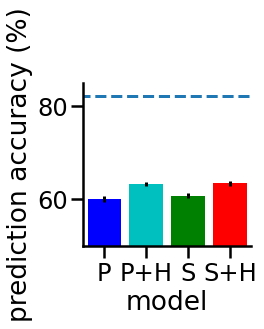

In [ ]:
labels = ['P', 'P+H', 'S', 'S+H']
positions = [1,2,3,4]
plt.figure(figsize=(3,3))
plt.bar(positions[0],accuracy_mean_low[0],yerr=accuracy_std_low[0],color='b')
plt.bar(positions[1],accuracy_mean_low[1],yerr=accuracy_std_low[1],color='c')
plt.bar(positions[2],accuracy_mean_low[2],yerr=accuracy_std_low[2],color='g')
plt.bar(positions[3],accuracy_mean_low[3],yerr=accuracy_std_low[3],color='r')
plt.hlines(accuracy_mean.mean(),0,5,linestyle='--')
plt.xlim(0.5,4.5)
plt.ylim(50,85)
ax = plt.gca()
ax.set_xticks(positions)
ax.set_xticklabels(labels)
plt.xlabel('model')
plt.ylabel('prediction accuracy (%)')
#plt.legend(['all trials','boundary trials','correct_trial','wrong_trial'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 50})
#plt.savefig(savepath + 'logistic_model_comparison_boundary_trials.svg', bbox_inches='tight')
plt.show()

In [ ]:
accuracy_mean_low

array([60.00033333, 63.29516667, 60.76241667, 63.41706667])

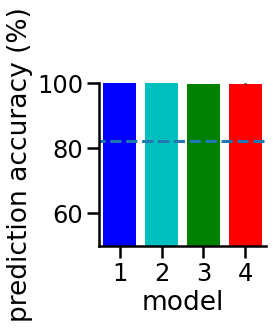

In [ ]:
positions = [1,2,3,4]
plt.figure(figsize=(3,3))
plt.bar(positions[0],accuracy_mean_correct[0],yerr=accuracy_std_correct[0],color='b')
plt.bar(positions[1],accuracy_mean_correct[1],yerr=accuracy_std_correct[1],color='c')
plt.bar(positions[2],accuracy_mean_correct[2],yerr=accuracy_std_correct[2],color='g')
plt.bar(positions[3],accuracy_mean_correct[3],yerr=accuracy_std_correct[3],color='r')
plt.hlines(accuracy_mean.mean(),0,5,linestyle='--')
plt.xlim(0.5,4.5)
plt.ylim(50,100)
ax = plt.gca()
ax.set_xticks(positions)
#ax.set_xticklabels(labels)
plt.xlabel('model')
plt.ylabel('prediction accuracy (%)')
#plt.legend(['all trials','boundary trials','correct_trial','wrong_trial'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 50})
#plt.savefig('figures/logistic_model_comparison.svg')
plt.show()

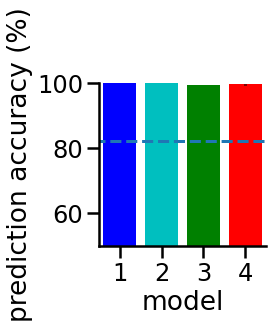

In [ ]:
positions = [1,2,3,4]
plt.figure(figsize=(3,3))
plt.bar(positions[0],accuracy_mean_wrong[0],yerr=accuracy_std_wrong[0],color='b')
plt.bar(positions[1],accuracy_mean_wrong[1],yerr=accuracy_std_wrong[1],color='c')
plt.bar(positions[2],accuracy_mean_wrong[2],yerr=accuracy_std_wrong[2],color='g')
plt.bar(positions[3],accuracy_mean_wrong[3],yerr=accuracy_std_wrong[3],color='r')
plt.hlines(accuracy_mean.mean(),0,5,linestyle='--')
plt.xlim(0.5,4.5)
plt.ylim(50,100)
ax = plt.gca()
ax.set_xticks(positions)
#ax.set_xticklabels(labels)
plt.xlabel('model')
plt.ylabel('prediction accuracy (%)')
#plt.legend(['all trials','boundary trials','correct_trial','wrong_trial'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 50})
#plt.savefig('figures/logistic_model_comparison.svg')
plt.show()

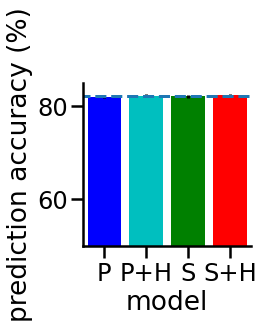

In [ ]:
labels = ['P', 'P+H', 'S', 'S+H']


positions = [1,2,3,4]
plt.figure(figsize=(3,3))
plt.bar(positions[0],accuracy_mean[0],yerr=accuracy_std[0],color='b')
plt.bar(positions[1],accuracy_mean[1],yerr=accuracy_std[1],color='c')
plt.bar(positions[2],accuracy_mean[2],yerr=accuracy_std[2],color='g')
plt.bar(positions[3],accuracy_mean[3],yerr=accuracy_std[3],color='r')
plt.hlines(accuracy_mean.mean(),0,5,linestyle='--')
plt.xlim(0.5,4.5)
plt.ylim(50,85)
ax = plt.gca()
ax.set_xticks(positions)
ax.set_xticklabels(labels)
plt.xlabel('model')
plt.ylabel('prediction accuracy (%)')
#plt.legend(['all trials','boundary trials','correct_trial','wrong_trial'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 50})
#plt.savefig(savepath + 'logistic_model_comparison_alltrials.svg', bbox_inches='tight')
plt.show()

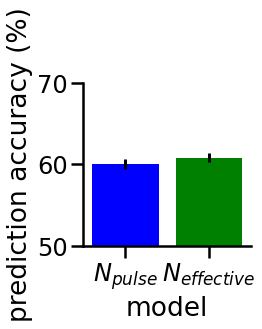

In [ ]:
positions = [1,2]
plt.figure(figsize=(3,3))
plt.bar(positions[0],accuracy_mean_low[0],yerr=accuracy_std_low[0],color='b')
plt.bar(positions[1],accuracy_mean_low[2],yerr=accuracy_std_low[2],color='g')
plt.hlines(accuracy_mean.mean(),0,5,linestyle='--')
plt.xlim(0.5,2.5)
plt.ylim(50,70)
ax = plt.gca()
ax.set_xticks(positions)
ax.set_xticklabels(['$N_{pulse}$','$N_{effective}$'])
plt.xlabel('model')
plt.ylabel('prediction accuracy (%)')
#plt.legend(['all trials','boundary trials','correct_trial','wrong_trial'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 50})
#plt.savefig('figures/logistic_model_comparison.svg')
plt.show()

In [99]:
num_processes = 16
N_bootstrap =20042
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,15))
all_sniff_hist_shuffled_all = np.zeros((0,15))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))

for animal_ind in range(len(all_correct_trials_list)):
    norm_given_odor = all_cum_odor_hist_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<20)
    norm_given_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_hist_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_hist_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_hist_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_h_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_h_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]    
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    X5 = all_sniff_hist_shuffled_all[ind_bootstrap]
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    clf5 = LogisticRegression().fit(X5, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    weights = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max()
    weights = weights/weights.max()
    weights_shuffled = clf5.coef_[0][0:15]/clf5.coef_[0][0:15].max()
    weights_shuffled = weights_shuffled/weights_shuffled.max()
    trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
    return accuracy,weights,trial_history,weights_shuffled

output = list()
    
for i in tnrange(num_iter):
    output.append(worker(0))

accuracy_list = list()
weights_list = list()
weights_shuffled_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output[i][0])
    weights_list.append(output[i][1])
    trial_history_list.append(output[i][2])
    weights_shuffled_list.append(output[i][3])

accuracy_mat = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean = accuracy_mat.mean(axis=0)
accuracy_std = accuracy_mat.std(axis=0)
accuracy_error = 1.96*accuracy_std/np.sqrt(num_iter)

weights_mat = np.concatenate(weights_list).reshape(-1,15)
weights_mean = weights_mat.mean(axis=0)
weights_std = weights_mat.std(axis=0)
weights_var = weights_mat.var(axis=0)
weights_error = 1.96*weights_std/np.sqrt(num_iter)

trial_history_mat = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean = trial_history_mat.mean(axis=0)
trial_history_std = trial_history_mat.std(axis=0)
trial_history_error = 1.96*trial_history_std/np.sqrt(num_iter)

weights_shuffled_mat = np.concatenate(weights_shuffled_list).reshape(-1,15)
weights_shuffled_mean = weights_shuffled_mat.mean(axis=0)
weights_shuffled_std = weights_shuffled_mat.std(axis=0)
weights_shuffled_error = 1.96*weights_shuffled_std/np.sqrt(num_iter)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(ind_bootstrap)
print(all_sniff_hist_all[10568])

[10188 14194  3904 ... 15048  7970 19151]
[1. 0. 0. 0. 1. 2. 1. 1. 0. 2. 0. 1. 0. 0.]


In [100]:
import pandas as pd
N_bootstrap = 20000
ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))
X2 = all_sniff_hist_all[ind_bootstrap]
X = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
y = all_high_choices_all[ind_bootstrap]
lm = LogisticRegression().fit(X,y)
params = np.append(lm.intercept_,lm.coef_)
weights = lm.coef_[0][0:15]
print(weights)
trial_history = lm.coef_[0][35:15:-1]/lm.coef_[0][0:15].max()

weights_norm = weights/weights.max()
predictions = lm.predict(X)

newX = np.append(np.ones((len(X),1)), X, axis=1)
a=np.ones((len(X),1))
print(a.shape)
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-scipy.stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

#sd_b = np.round(sd_b,3)
#ts_b = np.round(ts_b,3)
#p_values = np.round(p_values,3)
#params = np.round(params,4)
myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
myDF3

[0.42428071 0.56903837 0.63451329 0.60347108 0.5641656  0.40719645
 0.32939693 0.33859427 0.24767852 0.23977004 0.28569274 0.31632993
 0.3110826  0.33280031 0.45552714]
(20000, 1)


Coefficients  Standard Errors    t values  Probabilities
0      -4.401034         0.008602 -511.649550            0.0
1       0.424281         0.003232  131.260428            0.0
2       0.569038         0.003786  150.314699            0.0
3       0.634513         0.003771  168.259364            0.0
4       0.603471         0.003905  154.544381            0.0
5       0.564166         0.004086  138.058447            0.0
6       0.407196         0.003892  104.637194            0.0
7       0.329397         0.003905   84.358562            0.0
8       0.338594         0.004005   84.542669            0.0
9       0.247679         0.003870   63.998746            0.0
10      0.239770         0.003931   60.996517            0.0
11      0.285693         0.003844   74.321014            0.0
12      0.316330         0.003947   80.144358            0.0
13      0.311083         0.003757   82.806170            0.0
14      0.332800         0.003584   92.865743            0.0
15      0.455527         0.004428  102.881464            0.0
16      0.267330         0.005991   44.623500            0.0
17      0.215916         0.006009   35.932868            0.0
18      0.204328         0.006017   33.956719            0.0
19      0.229551         0.006024   38.107185            0.0
20      0.462874         0.006006   77.066047            0.0
21      0.612338         0.005992  102.186621            0.0

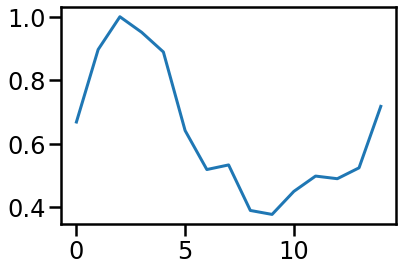

In [148]:
plt.plot(weights_norm)

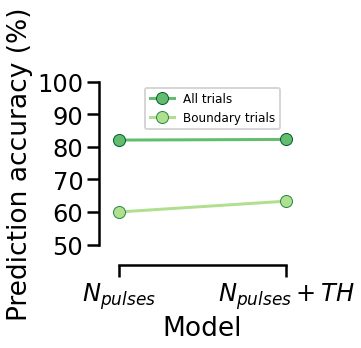

In [ ]:
plt.figure(figsize=(3,3))


plt.errorbar(np.arange(1,3),accuracy_mean[0:2], yerr= accuracy_std[0:2], marker='o',ls='-',
             color=cmap_7[5], markeredgecolor=cmap_7[9],clip_on=False)
plt.errorbar(np.arange(1,3),accuracy_mean_low[0:2], yerr= accuracy_std_low[0:2], marker='o', ls='-',
             color=cmap_7[3], markeredgecolor=cmap_7[7], clip_on=False)
positions=[1,2]
labels=['$N_{pulses}$','$N_{pulses}+TH$']
plt.ylim(50,100)
plt.xlim(1,2)
ax = plt.gca()
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ytickslist = list(np.arange(50, 110, 10))
ax.set_yticks(ytickslist)
plt.xlabel('Model')
plt.ylabel('Prediction accuracy (%)')
plt.legend(['All trials','Boundary trials'], loc='best', fontsize=12)
sns.despine(right=True, top=True, offset=20)

plt.savefig(savepath_svg + 'logreg_model_comparison_th.svg', transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'logreg_model_comparison_th.png', transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'logreg_model_comparison_th.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

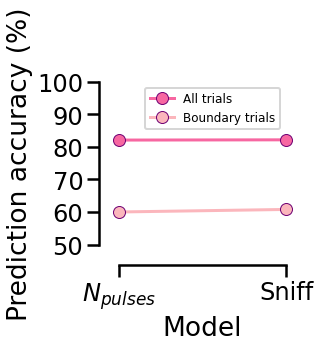

In [ ]:
plt.figure(figsize=(3,3))

plt.errorbar(np.arange(1,3),accuracy_mean[0:3:2], yerr= accuracy_std[0:3:2], marker='o',ls='-',
             color=c_2(0.5), markeredgecolor=c_2(0.9),clip_on=False)
plt.errorbar(np.arange(1,3),accuracy_mean_low[0:3:2], yerr= accuracy_std_low[0:3:2], marker='o', ls='-',
             color=c_2(0.3), markeredgecolor=c_2(0.9), clip_on=False)
positions=[1,2]
labels=['$N_{pulses}$','Sniff']
plt.ylim(50,100)
plt.xlim(1,2)
ax = plt.gca()
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ytickslist = list(np.arange(50, 110, 10))
ax.set_yticks(ytickslist)
plt.xlabel('Model')
plt.ylabel('Prediction accuracy (%)')
plt.legend(['All trials','Boundary trials'], loc='best', fontsize=12)
sns.despine(right=True, top=True, offset=20)

plt.savefig(savepath_svg + 'logreg_model_comparison_sniff_pulses.svg', transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'logreg_model_comparison_sniff_pulses.png', transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'logreg_model_comparison_sniff_pulses.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

(1000, 6)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

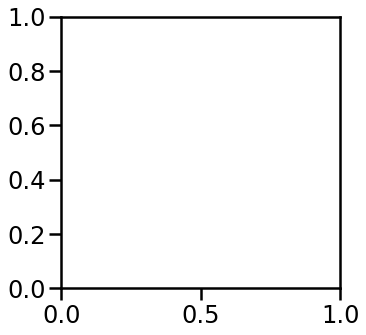

In [169]:
print(trial_history_mat.shape)
plt.figure(figsize=(5,5))
plt.bar(np.arange(1,num_hist),trial_history_mean, yerr=trial_history_error, color=cmap_6, 
        edgecolor = 'black', width = 0.75, clip_on=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Previous trial')
plt.ylabel('Bias (Number of pulse)')
ax.set_xticks(np.arange(1,num_hist))
sns.despine(right=True, top=True, offset=[60,20])
# plt.errorbar(np.arange(1,num_hist),autocorr_mat.mean(axis=0)[0:5],yerr=autocorr_mat.std(axis=0)[0:5],
#              clip_on=False, ecolor='k',capsize=5,marker='.',markerfacecolor='k',markeredgecolor='k',linestyle='')
plt.ylim(0,1)
plt.xlim(1,5)

#plt.legend(['trial weights','autocorrelation'])
# plt.savefig(savepath_svg + 'trial_history_bias.svg', transparent=True, format='svg', bbox_inches='tight')
# plt.savefig(savepath_png + 'trial_history_bias.png', transparent=True, format='png', bbox_inches='tight')
# plt.savefig(savepath_pdf + 'trial_history_bias.pdf', transparent=True, format='pdf', bbox_inches='tight')
plt.show()

In [704]:
for i in range(7):

    print(len(all_cum_odor_list[i]))


4381
5327
4078
2607
1049
1309
1291


In [702]:
4381+5327+4078+2607+1049+1309+1291

20042

In [712]:
np.unique(all_cum_odor_list[7])

IndexError: list index out of range

In [226]:
norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,15)) #15
all_sniff_hist_shuffled_all = np.zeros((0,15)) #15
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    norm_given_odor = all_cum_odor_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<21)
    norm_given_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_list[animal_ind][selected_trials]
    print(all_sniff_hist.shape)
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_list[animal_ind][selected_trials]
    #all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    #all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    print(all_sniff_hist_all.shape)
    print(norm_given_odor_all.shape)
    print(all_high_choices_all.shape)


(4331, 15)
(4331, 15)
(4331,)
(4331,)
(5274, 15)
(9605, 15)
(9605,)
(9605,)
(4035, 15)
(13640, 15)
(13640,)
(13640,)
(2607, 15)
(16247, 15)
(16247,)
(16247,)
(1049, 15)
(17296, 15)
(17296,)
(17296,)
(1309, 15)
(18605, 15)
(18605,)
(18605,)
(1291, 15)
(19896, 15)
(19896,)
(19896,)


In [118]:
N = np.arange(1,21)
Nis = df_test_2['Total Pulse'].values
Nis_weighted = (all_sniff_hist_all*weights_norm).sum(axis=1)
yis = df_test_2['High Choice'].values

print(Nis[:10],Nis_weighted[:10],yis[:10])

def compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_Np,Nmin=1): #sig_dN,
    sig_Nps = sig_Np[Nps-Nmin]
    sig = np.sqrt(sig_Nps**2)#+sig_dN**2)
    phigh = norm.cdf((weighted_odor-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

[14 14 11  5  2  3 12  3  5 16] [ 8.77355271  6.81878488  5.50579383  2.8299426   1.5654819   2.04655136
  8.45587689  1.23094314  3.29021564 10.88881436] [1 1 1 0 0 0 1 0 0 0]


In [119]:
bin_edges = np.linspace(weighted_odor.min(), weighted_odor.max(),20)
# Use digitize to find the bin index for each value in data
bin_indices = np.digitize(weighted_odor, bin_edges, right=True)

# Replace each value in data with the closest bin edge
binned_data = bin_edges[bin_indices - 1]

print(binned_data[:30], df_test_2['Total Pulse'].values[:30])

[ 8.68868936  6.31904681  4.73928511  2.36964255  0.78988085  1.5797617
  7.89880851  0.78988085  3.1595234  10.26845107  2.36964255  0.78988085
  2.36964255  2.36964255 11.05833192  6.31904681  7.10892766  7.10892766
  0.78988085  0.78988085  8.68868936  2.36964255  7.10892766  6.31904681
  2.36964255  0.78988085  7.89880851  0.78988085  4.73928511  8.68868936] [14 14 11  5  2  3 12  3  5 16  3  2  5  4 18 13 16 12  2  3 14  4 12 10
  3  2 12  2  8 14]


In [122]:
print(bin_edges[:20])

[ 0.          0.78988085  1.5797617   2.36964255  3.1595234   3.94940426
  4.73928511  5.52916596  6.31904681  7.10892766  7.89880851  8.68868936
  9.47857021 10.26845107 11.05833192 11.84821277 12.63809362 13.42797447
 14.21785532 15.00773617]


In [687]:
np.save ('effective_odor.npy', weighted_odor)

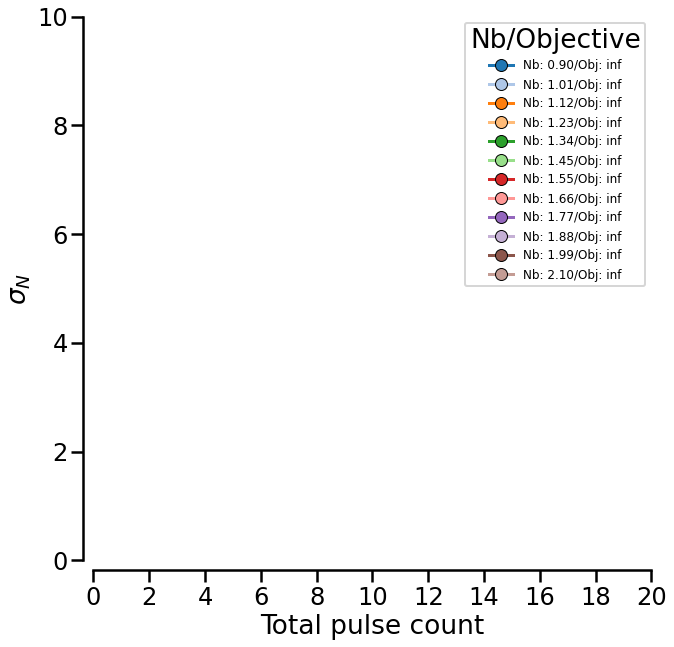

In [121]:
N = np.arange(1,21)
Nis = binned_data
#Nis_weighted = (all_sniff_hist_all*weights_norm).sum(axis=1)
yis = df_test_2['High Choice'].values
Nisorig = Nis.copy()
yisorig = yis.copy()
Nis_w_orig = Nis_weighted.copy()

F = lambda x, N: 0.5 * (1 + scipy.special.erf((N - x[20]) / np.sqrt(2 * (x[N.astype(int) - 1] ** 2 + x[21] ** 2))))

# Bootstrapping
k = np.arange(1, 21)
xall_data_theory = []
lks = []
Nboot = 0
numNbs = 12

for i in range(Nboot + 1):
    if i == 0:
        idxboot = np.arange(len(yisorig))
    else:
        idxboot = np.random.choice(len(yisorig), len(yis), replace=True)

    Nis = Nisorig[idxboot]
    #Nis_weighted = Nis_w_orig[idxboot]
    yis = yisorig[idxboot]

    # Find average psychometric for this:
    yboot = []
    for ni in range(1, 21):
        yboot.append(np.mean(yis[Nis == ni]))

    nsq = np.arange(1, 20.01, 0.01)
    yq = np.interp(nsq, np.arange(1, 21), yboot)
    Nzerocrossing = nsq[np.argmin(np.abs(yq - 0.5))]
    Nb = Nzerocrossing

    if numNbs > 1:
        Nbs = np.linspace(np.floor(Nb) -0.1, np.floor(Nb) + 1.1, numNbs)
        #Nbs = np.linspace(np.floor(Nb), np.floor(Nb) + 1, numNbs)
    else:
        Nbs = [Nb]
    
    for j in range(numNbs):
        Nb = Nbs[j]
        sigmab = 0
        sigmaNs = np.sqrt(((k - Nb) / scipy.special.erfinv(2 * np.array(yboot)[k - 1] - 1)) ** 2 / 2 - sigmab ** 2)
        sigmaNs[np.where(np.arange(1, 21) == Nb)] = np.nan

        x = np.concatenate([sigmaNs, [Nb], [sigmab]])
        loglikelihood = -np.nanmean(np.log(F(x, Nis)) * yis + np.log(1 - F(x, Nis)) * (1 - yis))
        lks.append(loglikelihood * 1000)
        xall_data_theory.append(x)

# Plotting
xall_data_theory = np.array(xall_data_theory)
plt.figure(figsize=(10,10))
for i in range(xall_data_theory.shape[0]):
    plt.plot(np.arange(1, 21), xall_data_theory[i, :20], '-o', linewidth=3, color=cmap_9[i], markeredgecolor='k', clip_on=False)

#plt.title('Data - theory fit')
#plt.grid(which='both', linestyle='--')
plt.ylabel(r'$\sigma_N$')
plt.xlabel('Total pulse count')
#plt.text(1, 6.5, r'$\sigma_b=' + f'{np.mean(xall_data_theory[:, 21]):.2f} \pm {np.std(xall_data_theory[:, 21]):.2f}$', fontsize=18)
leg = plt.legend([f'Nb: {xall_data_theory[i, 20]:.2f}/Obj: {lks[i]:.2f}' for i in range(len(lks))], loc='best', fontsize=12)
leg.set_title('Nb/Objective')
sns.despine(offset=10)
plt.xlim(0,20)
plt.ylim(0,10)
plt.xticks(np.linspace(0,20,11))

# plt.savefig(savepath_svg + 'sigma_estimation_multiple_Nbs.svg',transparent = True, format='svg', bbox_inches='tight')
# plt.savefig(savepath_png + 'sigma_estimation_multiple_Nbs.png',transparent = True, format='png', bbox_inches='tight')
# plt.savefig(savepath_pdf + 'sigma_estimation_multiple_Nbs.pdf',transparent = True, format='pdf', bbox_inches='tight')

plt.show()

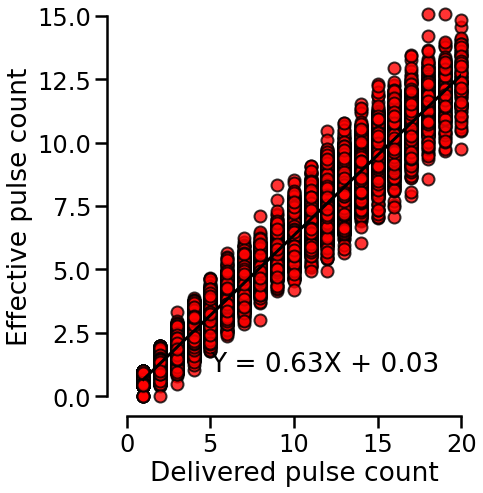

In [166]:
#weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)

weighted_odor = (all_sniff_hist_all*weights_mean_2).sum(axis=1)
slope, intercept, r_value, p_value, std_err  =  linregress(norm_given_odor_all, weighted_odor)
#x_fit = np.linspace(0,20,21)
X_new = resx_pool_w1[0,0]
Y_pred_new = X_new * slope + intercept

x_fit = np.linspace(1,20,20)
y_fit = x_fit * slope + intercept
plt.figure(figsize=(6,7))
plt.scatter(norm_given_odor_all, weighted_odor, marker='o', color='r', edgecolors='k', alpha=.8, clip_on=False)#, vert=False)
plt.plot(x_fit, y_fit, c='k')
equation_text = f'Y = {slope:.2f}X + {intercept:.2f}'

plt.text(5,1,equation_text)

plt.xlabel('Delivered pulse count')
plt.ylabel('Effective pulse count')
plt.ylim(0,15)
plt.xlim(0,20)
sns.despine(offset=20)

plt.savefig(savepath_svg + 'regression_delivered_effective.svg', transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'regression_delivered_effective.png', transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'regression_delivered_effective.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

In [106]:
slope, intercept, r_value, p_value, std_err  =  linregress(weighted_odor, norm_given_odor_all)
#x_fit = np.linspace(0,20,21)
X_new = resx_pool_w1[0,0]
Y_pred_new = X_new * slope + intercept

# Calculate the residual standard error
n = len(weighted_odor)
residuals = norm_given_odor_all - (slope * weighted_odor + intercept)
s_e = np.sqrt(np.sum(residuals**2) / (n - 2))

# Confidence interval calculation
t_value = scipy.stats.t.ppf(1 - 0.025, n - 2)  # 95% confidence, two-tailed t-test
X_mean = np.mean(weighted_odor)
sum_squared_X_diff = np.sum((weighted_odor - X_mean) ** 2)

# Variance of the prediction for X = 1.5
var_pred = s_e**2 * (1 + 1/n + (X_new - X_mean)**2 / sum_squared_X_diff)

# Calculate confidence interval
conf_interval = t_value * np.sqrt(var_pred)

print(f"Predicted Y for X=1.5: {Y_pred_new:.2f}")
print(f"95% Confidence Interval: [{Y_pred_new - conf_interval:.2f}, {Y_pred_new + conf_interval:.2f}]")
print(f"Error of the estimation: {conf_interval:.2f}")

reconstructed_boundary = np.array([Y_pred_new, conf_interval])
print(reconstructed_boundary[0])


Predicted Y for X=1.5: 8.27
95% Confidence Interval: [6.30, 10.25]
Error of the estimation: 1.97
8.274100571720364


In [168]:
def compute_logp_correct_weighted(choices,weighted_odor,Nps,Nb,sig_Np): #sig_dN
    pcorrect = compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_Np,Nmin=1): #sig_dN,
    sig_Nps = sig_Np[Nps-Nmin]
    sig = np.sqrt(sig_Nps**2)#+sig_dN**2)
    phigh = norm.cdf((weighted_odor-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

num_processes = 16
N_bootstrap = len(all_high_choices_all)
num_iter = 1000
batch_iter = 100
bound = (0,30)


bounds = list()
for i in range(21):
    bounds.append(bound)
num_batch = num_iter//batch_iter
weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)
#weighted_odor = np.ceil((all_sniff_hist_all*weights_norm).sum(axis=1)).astype(np.int)
res_array = np.zeros((21,num_iter))
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    #new_cum_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #new_cum_odor

    def loss(x):
        Nb = 5.01#x[0]
        #sig_dN = x[1]
        sig_Np = x[1:]
        return -compute_logp_correct_weighted(choices,new_weighted_odor,Nps,Nb,sig_Np) #Nps, sig_dN,

    x0 = 6+np.random.rand(21)*5
    x0[0] = 5.01
    #x0[1] = 0
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,21).transpose()

resx_pool_w1 =np.zeros((21,3))
resx_pool_w1[:,0] = res_array.mean(1)
resx_pool_w1[:,1] = res_array.std(1)
resx_pool_w1[:,2] = 1.69*res_array.std(1)/np.sqrt(num_iter)


  0%|          | 0/10 [00:00<?, ?it/s]

In [169]:
resx_pool_w1

array([[5.01000000e+00, 1.26121336e-13, 6.74023853e-15],
       [2.33056404e+00, 1.25078357e-01, 6.68449913e-03],
       [2.27253665e+00, 8.68968185e-02, 4.64398257e-03],
       [2.28676158e+00, 7.42585923e-02, 3.96856426e-03],
       [2.26573933e+00, 7.13002969e-02, 3.81046558e-03],
       [2.39881360e+00, 1.03635099e-01, 5.53851798e-03],
       [2.30833224e+00, 1.38490550e-01, 7.40128017e-03],
       [2.25856725e+00, 3.18739856e-01, 1.70342524e-02],
       [8.58143524e+00, 7.49573883e+00, 4.00590966e-01],
       [2.91414299e+00, 6.48751798e-01, 3.46709131e-02],
       [2.79340294e+00, 2.33170267e-01, 1.24612003e-02],
       [2.67981488e+00, 1.46054161e-01, 7.80549841e-03],
       [2.92338982e+00, 1.22215095e-01, 6.53147928e-03],
       [3.13690258e+00, 1.34192949e-01, 7.17160564e-03],
       [3.35629850e+00, 1.62923415e-01, 8.70703339e-03],
       [3.58712078e+00, 1.83189211e-01, 9.79008803e-03],
       [3.87470863e+00, 1.84887039e-01, 9.88082418e-03],
       [3.61749079e+00, 2.46004

8.0


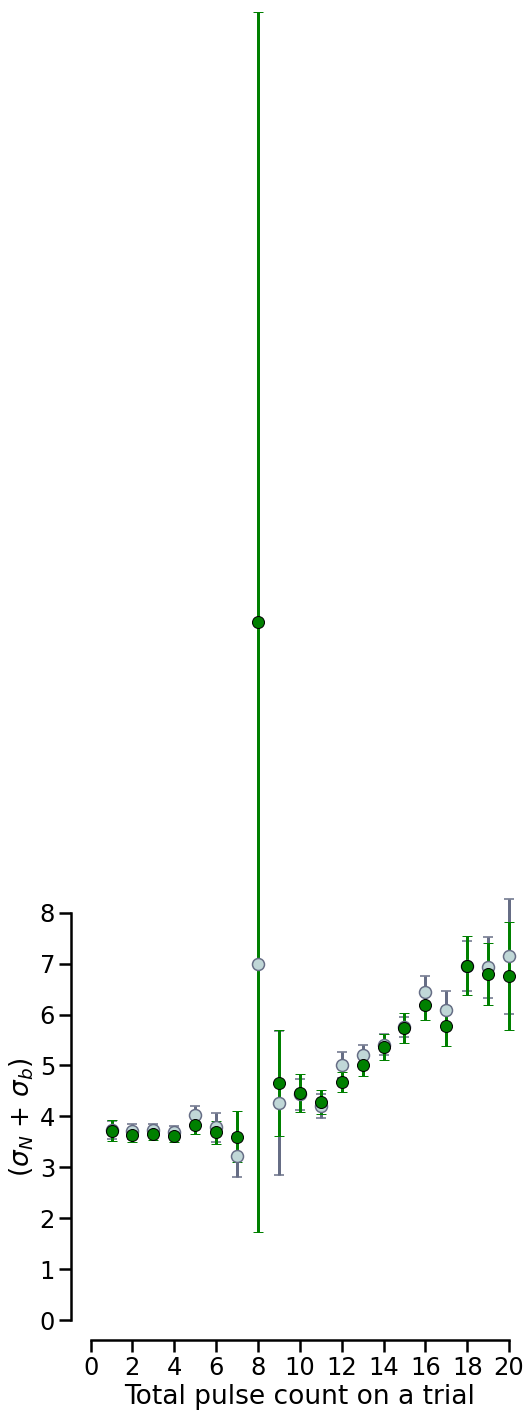

In [182]:
fig = plt.figure(figsize=(7.5,7.5))
x = np.arange(1,21)
y1 = resx_pool_newfun_7[1:,0]
print(resx_pool_newfun_7[0,0])
#print(resx_pool_w1[2,0])
scaling_factor = resx_pool_newfun_7[0,0]/resx_pool_w1[0,0]

y2 = resx_pool_w1[1:,0]
y3 = resx_pool_w1[1:,0]*scaling_factor
y3_err = resx_pool_w1[1:,1]*scaling_factor

plt.errorbar(x=np.arange(1,21),y=y1,yerr=resx_pool_newfun_7[1:,1],marker='o',
             color=cmap_8[1], markeredgecolor=cmap_8[5], markeredgewidth=1.5, linestyle = '', clip_on=False, 
             ecolor=cmap_8[5], capsize=5)
plt.errorbar(x=np.arange(1,21),y=y3,yerr=y3_err,marker='o',color='green',markeredgecolor='k',linestyle = '', clip_on=False, capsize=5)
plt.xticks(np.linspace(0,20,11))
plt.xlabel('Total pulse count on a trial')
plt.ylim(0,8)
plt.xlim(0,20)
plt.ylabel('($\sigma_{N}$ + $\sigma_{b}$)')
sns.despine(right=True, top=True, offset=20)
plt.savefig('new_noise_scaling_with_sniff_weights.svg')
plt.show()

In [666]:
bin_edges = np.linspace(weighted_odor.min(), weighted_odor.max(),21)
# Use digitize to find the bin index for each value in data
bin_indices = np.digitize(weighted_odor, bin_edges, right=True)

# Replace each value in data with the closest bin edge
binned_data = bin_edges[bin_indices - 1]

print(binned_data[:30])

[ 8.48205507  6.93986324  5.39767141  3.08438366  1.54219183  1.54219183
  8.48205507  0.77109592  3.08438366 10.79534282  2.31328775  0.77109592
  2.31328775  2.31328775 10.79534282  6.93986324  7.71095915  6.93986324
  0.77109592  1.54219183  8.48205507  2.31328775  7.71095915  6.16876732
  2.31328775  0.77109592  7.71095915  0.77109592  4.62657549  9.25315098]


In [612]:
def compute_pcorrect_weighted_og(choices,weighted_odor,Nps,Nb,sig_dN,sig_Np,Nmin=1): #sig_dN,
    sig_Nps = sig_Np[Nps-Nmin]
    sig = np.sqrt(sig_Nps**2+sig_dN**2)
    phigh = norm.cdf((weighted_odor-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

def compute_logp_correct_weighted_og(choices,weighted_odor,Nps,Nb,sig_dN,sig_Np): #sig_dN
    pcorrect = compute_pcorrect_weighted_og(choices,weighted_odor,Nps,Nb,sig_dN,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

num_processes = 16
N_bootstrap = len(all_high_choices_all)
num_iter = 1000
batch_iter = 100
bound = (0,30)


bounds = list()
for i in range(22):
    bounds.append(bound)
num_batch = num_iter//batch_iter
weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)
#weighted_odor = np.ceil((all_sniff_hist_all*weights_norm).sum(axis=1)).astype(np.int)
res_array = np.zeros((22,num_iter))
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    #new_cum_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #new_cum_odor

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        sig_Np = x[2:]
        return -compute_logp_correct_weighted_og(choices,new_weighted_odor,Nps,Nb,sig_dN,sig_Np) #Nps, sig_dN,

    x0 = 6+np.random.rand(22)*5
    #x0[1] = 0
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,22).transpose()

resx_pool_w2 =np.zeros((22,3))
resx_pool_w2[:,0] = res_array.mean(1)
resx_pool_w2[:,1] = res_array.std(1)
resx_pool_w2[:,2] = 1.69*res_array.std(1)/np.sqrt(num_iter)

  0%|          | 0/10 [00:00<?, ?it/s]

In [613]:
resx_pool_w2

array([[5.10054471e+00, 6.78194293e-02, 3.62443934e-03],
       [1.68047076e+00, 6.32248480e-01, 3.37889346e-02],
       [1.33663396e+00, 6.35742648e-01, 3.39756717e-02],
       [1.43727614e+00, 5.58886582e-01, 2.98682919e-02],
       [1.38199176e+00, 5.74410937e-01, 3.06979522e-02],
       [1.19343901e+00, 6.66942515e-01, 3.56430703e-02],
       [1.56901898e+00, 5.76739052e-01, 3.08223724e-02],
       [1.21546977e+00, 7.13293223e-01, 3.81201677e-02],
       [8.79919891e-01, 8.24337020e-01, 4.40546250e-02],
       [7.00008685e+00, 6.96681595e+00, 3.72324009e-01],
       [2.73032546e+00, 1.24473119e+00, 6.65215371e-02],
       [2.44515161e+00, 5.01480343e-01, 2.68003595e-02],
       [2.24379629e+00, 4.20673486e-01, 2.24818396e-02],
       [2.66804104e+00, 3.95860416e-01, 2.11557673e-02],
       [2.83826236e+00, 3.73802688e-01, 1.99769474e-02],
       [3.06571024e+00, 3.49326127e-01, 1.86688589e-02],
       [3.34398840e+00, 3.35470100e-01, 1.79283583e-02],
       [3.70958779e+00, 3.35386

[[7.99000000e+00 1.59872116e-13 9.90897638e-15]]


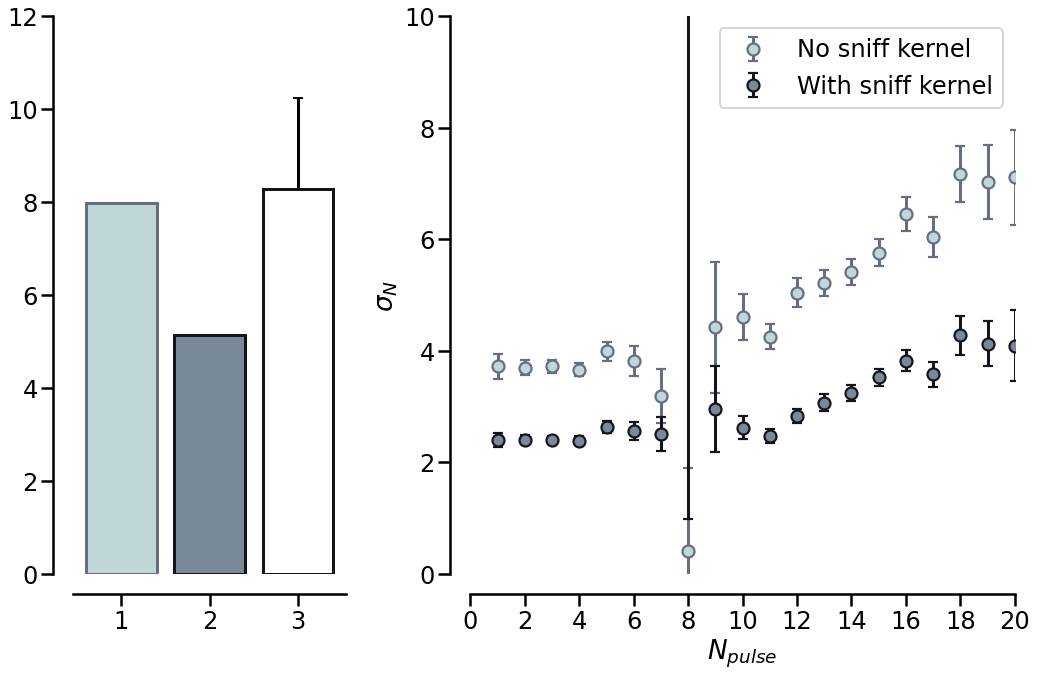

In [111]:
#fig = plt.figure(figsize=(25,10))

Nb_array_wo_sniffing = np.zeros((1,3))
#sig_dN_array_wo_sniffing = np.zeros((1,2))
Nb_array_with_sniffing = np.zeros((1,3))
#sig_dN_array_with_sniffing = np.zeros((1,2))
for i in range(1):
    Nb_array_wo_sniffing[i,:] = resx_pool_newfun_7[0,:3]
    #sig_dN_array_wo_sniffing[i,:] = resx_pool[1,:2]
    Nb_array_with_sniffing[i,:] = resx_pool_w1[0,:3]
    #sig_dN_array_with_sniffing[i,:] = resx_pool_w1[1,:]

f, (a0,a1) = plt.subplots(1,2, gridspec_kw={'width_ratios': [1,2]}, figsize=(15,10))

print(Nb_array_wo_sniffing)
#plt.subplot(1,2,1)
for i in range(1):
    a0.bar(x=i+1,height=Nb_array_wo_sniffing[i,0],
            yerr=Nb_array_wo_sniffing[i,1],color=cmap_8[1], ec=cmap_8[5], lw=3,
            error_kw=dict(zorder=0, capsize=5, capthick=2))
    a0.bar(x=i+2,height=Nb_array_with_sniffing[i,0],
            yerr=Nb_array_with_sniffing[i,1],color=cmap_8[4], ec=cmap_8[9], lw=3,
            error_kw=dict(zorder=0, capsize=5, capthick=2))
    a0.bar(x=i+3,height=reconstructed_boundary[i],
            yerr=reconstructed_boundary[i+1],color='white', ec=cmap_8[9], lw=3,
            error_kw=dict(zorder=0, capsize=5, capthick=2))
#     a0.bar(x=i+3,height=sig_dN_array_wo_sniffing[i,0],
#             yerr=sig_dN_array_wo_sniffing[i,1],color=cmap_8[1], ec=cmap_8[5], lw=3,
#             error_kw=dict(zorder=0, capsize=5, capthick=2))
#     a0.bar(x=i+4,height=sig_dN_array_with_sniffing[i,0],
#             yerr=sig_dN_array_with_sniffing[i,1],color=cmap_8[4], ec=cmap_8[9], lw=3,
#             error_kw=dict(zorder=0, capsize=5, capthick=2))
#a0.set_xticks(np.arange(1.5,5,2),('$N_{boundary}$','$\sigma_{boundary}$'))
#a0.set_xlim(0.5,4.5)
a0.set_ylim(0,12)

# a1.errorbar(x=np.arange(1,21),y=resx_pool[2:,0],yerr=resx_pool[2:,1],marker='o',
#                 color=cmap_8[1], markeredgecolor=cmap_8[5], mew=2.2, ecolor=cmap_8[5], 
#                 capsize=5, linestyle = '', clip_on=False)

a1.errorbar(x=np.arange(1,21),y=resx_pool_newfun_7[1:,0],yerr=resx_pool_newfun_7[1:,1],marker='o',
                color=cmap_8[1], markeredgecolor=cmap_8[5], mew=2.2, ecolor=cmap_8[5],
                capsize=5, linestyle = '', clip_on=True)

# a1.errorbar(x=np.arange(1,21),y=resx_pool_w2[2:,0],yerr=resx_pool_w2[2:,1],marker='o',
#                 color=cmap_8[1], markeredgecolor=cmap_8[5], mew=2.2, ecolor=cmap_8[5], 
#                 capsize=5, linestyle = '', clip_on=False)
a1.errorbar(x=np.arange(1,21),y=resx_pool_w1[1:21,0],yerr=resx_pool_w1[1:21,1],marker='o',
                color=cmap_8[4], markeredgecolor=cmap_8[9], mew=2.2, ecolor=cmap_8[9], 
                capsize=5, linestyle = '', clip_on=True)

# sigma_fsub_sq = np.concatenate([np.ones(limit)*resx_pool_sq_fakesub[2,0],
#             np.sqrt(resx_pool_sq_fakesub[1,0]*(np.arange(limit,21,1)))])
# #a1.plot(pulse_bins[:20],sigma_fsub_sq[:20],color=cmap_11[8],linewidth=3)

# sigma_fsub_sq_w = np.concatenate([np.ones(limit)*resx_pool_sq_fakesub_w[2,0],
#             np.sqrt(resx_pool_sq_fakesub_w[1,0]*(np.arange(limit,21,1)))])


#a1.set_yticks(np.arange(14))
a1.set_ylim(0,10)
a1.set_xlim(0,20)

a1.set_xticks(np.linspace(0,20,11))
a1.set_xlabel('$N_{pulse}$')
a1.set_ylabel('$\sigma_{N}$')



sns.despine(offset=20)
plt.legend(['No sniff kernel', 'With sniff kernel'])
# a1.plot(pulse_bins[:20],sigma_fsub_sq[:20],color=cmap_11[8],linewidth=3)
# a1.plot(pulse_bins[:20],sigma_fsub_sq_w[:20],color=cmap_11[9],linewidth=3)


f.tight_layout()

# plt.savefig(savepath_svg + 'model_w_and_wo_sniff_weights.svg', transparent=True, format='svg', bbox_inches='tight')
# plt.savefig(savepath_png + 'model_w_and_wo_sniff_weights.png', transparent=True, format='png', bbox_inches='tight')
# plt.savefig(savepath_pdf + 'model_w_and_wo_sniff_weights.pdf', transparent=True, format='pdf', bbox_inches='tight')

plt.show()

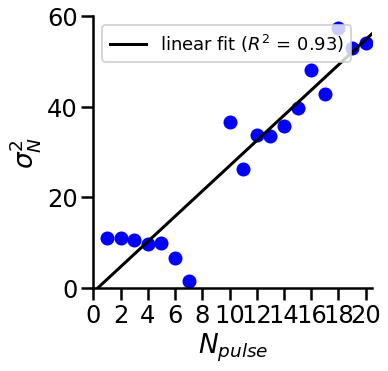

In [ ]:
fig = plt.figure(figsize=(5,5))

x_selected = np.concatenate([np.arange(7),np.arange(9,20)])
x = x_selected + 1
y = y1[x_selected]**2
slope, intercept, r_value, p_value, std_err = linregress(x,y)
x_pred = np.arange(22)
y_pred = x_pred * slope + intercept
plt.plot(x_pred,y_pred,'k')
y2
plt.scatter(x,y,color='b')
plt.xlim(0,20.5)
plt.ylim(0,60)
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_N^2$')
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(np.linspace(0,20,11))
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value], fontsize = 18)
plt.show()
#fig.savefig(savepath + 'linreg_noise_sniff.png',format='png', bbox_inches='tight', dpi=300)


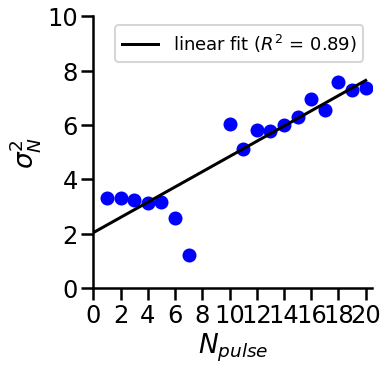

In [ ]:
fig = plt.figure(figsize=(5,5))

x_selected = np.concatenate([np.arange(7),np.arange(9,20)])
x = x_selected + 1
y = y1[x_selected]
slope, intercept, r_value, p_value, std_err = linregress(x,y)
x_pred = np.arange(21)
y_pred = x_pred * slope + intercept
plt.plot(x_pred,y_pred,'k')
y2
plt.scatter(x,y,color='b')
plt.xlim(0,20.5)
plt.ylim(0,10)
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_N^2$')  #^2
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(np.linspace(0,20,11))
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value], fontsize = 18)
plt.show()
#fig.savefig(savepath + 'linreg_noise_sniff.png',format='png', bbox_inches='tight', dpi=300)


Text(0, 0.5, '$\\sigma_N^2$')

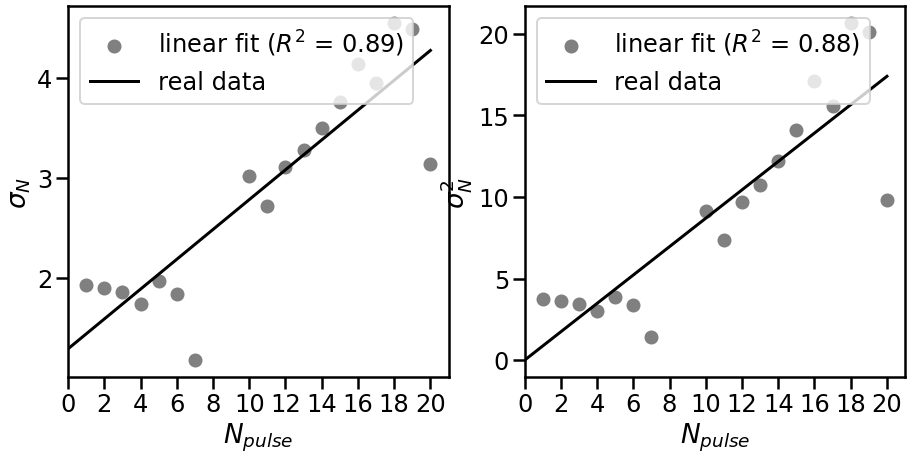

In [ ]:
fig = plt.figure(figsize=(15,15))

w_x_reg = np.concatenate([np.arange(1,8),np.arange(10,21)])
w_y_reg = resx_pool_w1[2:,0][w_x_reg-1]
slope, intercept, r_value, p_value, std_err = linregress(w_x_reg,w_y_reg)
x_fit = np.linspace(0,20,21)
y_fit = x_fit * slope + intercept

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(w_x_reg,w_y_reg**2)
y_fit2 = x_fit * slope2 #+ intercept2

plt.subplot(2,2,1)
plt.scatter(w_x_reg,w_y_reg,color='gray')
plt.plot(x_fit,y_fit,color='black')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,21)
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value,'real data'])
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_N$')

plt.subplot(2,2,2)
plt.scatter(w_x_reg,w_y_reg**2,color='gray')
plt.plot(x_fit,y_fit2,color='black')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,21)
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value2,'real data'])
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_N^2$')


In [265]:
len(all_high_choices_all)

19896

In [274]:
num_processes = 16
N_bootstrap = len(all_high_choices_all)
num_iter = 1000
batch_iter = 100
bound = (0,50)


bounds = list()
for i in range(2):
    bounds.append(bound)
num_batch = num_iter//batch_iter

weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)
#weighted_odor = np.ceil((all_sniff_hist_all*weights_norm).sum(axis=1)).astype(np.int)

res_array = np.zeros((2,num_iter))

    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    #new_cum_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        #sig_dN = x[1]
        ksig = x[1]
        return -compute_logp_correct_sq_weighted(choices,new_weighted_odor,Nps,Nb,ksig,Nmax=20) #sig_dN,

    x0 = 6+np.random.rand(2)*5
    
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,2).transpose()

resx_pool_sq_w =np.zeros((2,2))
resx_pool_sq_w[:,0] = res_array.mean(1)
resx_pool_sq_w[:,1] = res_array.std(1)
phigh_est_sq_w = compute_phigh_sq(np.arange(1,21),resx_pool_sq_w[0,0],resx_pool_sq_w[1,0],Nmax=20)

resx_pool_sq_w
# resx_pool_sq

  0%|          | 0/10 [00:00<?, ?it/s]

array([[4.75316566, 0.02633519],
       [1.32145133, 0.03542412]])

In [227]:
num_processes = 16
N_bootstrap = len(all_high_choices_all)
num_iter = 1000
batch_iter = 100

def compute_logp_correct_lin_weighted(choices,weighted_odor,Nps,Nb,ksig,sig_0,Nmin=1,Nmax=20): #sig_dN,
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    pcorrect = compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()
#bound = (0.01,50)

bounds = [(0,30), (0, 30), (0,30)]

# bounds = list()
# for i in range(3):
#     bounds.append(bound)
num_batch = num_iter//batch_iter

weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)
#weighted_odor = np.ceil((all_sniff_hist_all*weights_norm).sum(axis=1)).astype(np.int)

res_array = np.zeros((3,num_iter))

    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    #new_cum_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        #sig_dN = x[1]
        ksig = x[1]
        sig_0 = x[2]
        return -compute_logp_correct_lin_weighted(choices,new_weighted_odor,Nps,Nb,ksig,sig_0,Nmin=1,Nmax=20) #sig_dN,

    x0 = 6+np.random.rand(3)*5
    
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

with mp.Pool(processes=16) as pool:
        for i in tnrange(num_batch):
            batch_output = pool.map(worker,range(batch_iter))
            output.extend(batch_output)
        pool.close()

res_array = np.concatenate(output).reshape(-1,3).transpose()

resx_pool_lin_w =np.zeros((3,2))
resx_pool_lin_w[:,0] = res_array.mean(1)
resx_pool_lin_w[:,1] = res_array.std(1)
phigh_est_lin_w = compute_phigh_lin(np.arange(1,21),resx_pool_lin_w[0,0],resx_pool_lin_w[1,0],
                                  resx_pool_lin_w[2,0],Nmax=20)

resx_pool_lin_w

  0%|          | 0/10 [00:00<?, ?it/s]

array([[4.96565254, 0.03610407],
       [0.10414672, 0.00709984],
       [1.96446435, 0.06177773]])

In [ ]:
#Checking subitizing hypothesis with sniff kernel

def compute_logp_correct_lin_sub_weighted(choices,weighted_odor,Nps,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18):
    sig_Np = np.concatenate([np.zeros(6),ksig*(np.arange(7,Nmax+1,1))+sig_0])
    pcorrect = compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_dN,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

num_processes = 16
N_bootstrap = 15000
num_iter = 1000
batch_iter = 100
bounds = [(0,30), (0, 30), (0, 30), (-30, 5)]
num_batch = num_iter//batch_iter

weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)

res_array = np.zeros((4,num_iter))
    
def worker(x):
    np.random.seed(404)
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    #new_cum_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)
    
    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        sig_0 = x[3]
        return -compute_logp_correct_lin_sub_weighted(choices,new_weighted_odor,Nps,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=20)  #Nmax=26

    x0 = 9.5+np.random.rand(4)*5 
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,4).transpose() #.reshape(-1,3)

resx_pool_lin_sub_w =np.zeros((4,3)) #np.zeros((3,2))
resx_pool_lin_sub_w[:,0] = res_array.mean(1)
resx_pool_lin_sub_w[:,1] = res_array.std(1)
resx_pool_lin_sub_w[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)

#np.save(np_savepath+'resx_pool_lin_sub_w.npy',resx_pool_lin_sub_w)
phigh_est_lin_sub_w = compute_phigh_lin_sub(np.arange(1,15),resx_pool_lin_sub_w[0,0],resx_pool_lin_sub_w[1,0],
                                  resx_pool_lin_sub_w[2,0],resx_pool_lin_sub_w[3,0],Nmax=14)

resx_pool_lin_sub_w

  0%|          | 0/10 [00:00<?, ?it/s]

array([[ 5.19762179e+00,  4.88498131e-14,  3.02774278e-15],
       [ 2.36048823e+00,  4.35207426e-14,  2.69744357e-15],
       [ 2.40824679e-01,  3.85802501e-15,  2.39122868e-16],
       [-4.63120948e-01,  1.08246745e-14,  6.70920276e-16]])

In [ ]:
resx_pool_lin_sub

array([[7.92682313e+00, 8.70414851e-14, 5.39488714e-15],
       [3.62766136e+00, 6.21724894e-14, 3.85349082e-15],
       [3.03675855e-01, 2.44249065e-15, 1.51387139e-16],
       [2.17901685e-15, 1.22273440e-29, 7.57858635e-31]])

In [205]:
len(all_high_choices_all)

19302

In [ ]:
#Babylon

In [285]:
#Checking subitizing hypothesis with sniff kernel with basal noise

limit=5

def compute_logp_correct_lin_fakesub_w(choices,weighted_odor,Nps,Nb,ksig,sig_1,sig_0,Nmin=1,Nmax=20): #ksig,sig_0,sub sig_dN,
    sig_Np = np.concatenate([np.ones(limit)*sig_1,ksig*(np.arange(limit+1,Nmax+1,1))+sig_0]) # + sig_0
    pcorrect = compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

num_processes = 16
N_bootstrap = len(all_high_choices_all)
num_iter = 1000
batch_iter = 100

bounds = [(0,30), (0, 10), (0, 10), (-10,10)]

num_batch = num_iter//batch_iter
weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)


res_array = np.zeros((4,num_iter)) 
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26
    
    def loss(x):
        Nb = x[0]
        ksig = x[1]
        sig_1 = x[2]
        sig_0 = x[3]

        return -compute_logp_correct_lin_fakesub_w(choices,new_weighted_odor,Nps,Nb,ksig,sig_1,sig_0,Nmin=1,Nmax=20)  #Nmax=26

    x0 = 5+np.random.rand(4)*5 
    x0[1] = 0.27
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000, 'ftol':'1e-9'})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,4).transpose() #.reshape(-1,3)

resx_pool_lin_fakesub_w =np.zeros((4,3)) #np.zeros((3,2))
resx_pool_lin_fakesub_w[:,0] = res_array.mean(1)
resx_pool_lin_fakesub_w[:,1] = res_array.std(1)
resx_pool_lin_fakesub_w[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)

#np.save(np_savepath+'resx_pool_lin_fakesub_w.npy',resx_pool_lin_fakesub)


phigh_est_lin_fakesub_w = compute_phigh_lin_fakesub(np.arange(1,21),resx_pool_lin_fakesub_w[0,0],
                        resx_pool_lin_fakesub_w[1,0], resx_pool_lin_fakesub_w[2,0],
                        resx_pool_lin_fakesub_w[3,0],Nmax=20)

resx_pool_lin_fakesub_w

  0%|          | 0/10 [00:00<?, ?it/s]

array([[4.89408834e+00, 5.39144103e-02, 3.34164977e-03],
       [1.41150250e-01, 6.70203829e-02, 4.15396637e-03],
       [2.22656890e+00, 6.43201997e-02, 3.98660728e-03],
       [3.08229422e-01, 1.74416388e+00, 1.08104397e-01]])

In [286]:
ttt = res_array[1]
print(ttt)

[1.62209377e-01 1.81838458e-01 1.62209377e-01 1.81838458e-01
 1.62209377e-01 1.81838458e-01 1.62209377e-01 1.81838458e-01
 1.62209377e-01 1.81838458e-01 1.62209377e-01 1.81838458e-01
 1.62209377e-01 1.81838458e-01 1.62209377e-01 1.81838458e-01
 1.62209377e-01 1.81838458e-01 1.62209377e-01 1.81838458e-01
 1.62209377e-01 1.81838458e-01 1.62209377e-01 1.81838458e-01
 1.62209377e-01 1.81838458e-01 1.62209377e-01 1.81838458e-01
 1.62209377e-01 1.81838458e-01 1.62209377e-01 1.81838458e-01
 1.68257738e-01 1.61137453e-01 1.68257738e-01 1.61137453e-01
 1.68257738e-01 1.61137453e-01 1.68257738e-01 1.61137453e-01
 1.68257738e-01 1.61137453e-01 1.68257738e-01 1.61137453e-01
 1.68257738e-01 1.61137453e-01 1.68257738e-01 1.61137453e-01
 1.68257738e-01 1.61137453e-01 1.68257738e-01 1.61137453e-01
 1.68257738e-01 1.61137453e-01 1.68257738e-01 1.61137453e-01
 1.68257738e-01 1.61137453e-01 1.68257738e-01 1.61137453e-01
 1.68257738e-01 1.61137453e-01 1.68257738e-01 1.61137453e-01
 1.71154433e-01 1.773886

In [185]:
#Checking subitizing hypothesis with sniff kernel with basal noise

def compute_logp_correct_sq_fakesub_w(choices,weighted_odor,Nps,Nb,ksig,sig_1,Nmin=1,Nmax=20): #ksig,sig_0,sub sig_dN,
    sig_Np = np.concatenate([np.ones(5)*sig_1,np.sqrt(ksig*(np.arange(6,Nmax+1,1)))]) # + sig_0
    pcorrect = compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_Np,Nmin)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

# def compute_phigh_sq_fakesub(Np,Nb,ksig,sig_1,Nmin=1,Nmax=18): #ksig,sig_0,sub sig_dN,
#     sig_Np = np.concatenate([np.ones(limit)*sig_1,np.sqrt(ksig*(np.arange(limit+1,Nmax+1,1)))]) # + sig_0
#     sig = np.sqrt(sig_Np**2)   #Why this is not multiplied by 2 +sig_dN**2
#     phigh = norm.cdf((Np-Nb)/sig)
#     return phigh


num_processes = 16
N_bootstrap = len(all_high_choices_all)
num_iter = 1000
batch_iter = 100

bounds = [(0,30), (0, 10), (0,5)]

num_batch = num_iter//batch_iter
weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)


res_array = np.zeros((3,num_iter)) 
    
def worker(x):
    np.random.seed(404)
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #26
    
    def loss(x):
        Nb = x[0]
        ksig = x[1]
        sig_1 = x[2]
        
        return -compute_logp_correct_sq_fakesub_w(choices,new_weighted_odor,Nps,Nb,ksig,sig_1,Nmin=1,Nmax=20)  #Nmax=26

    x0 = 9.5+np.random.rand(3)*5
    x0[1] = 2
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000, 'ftol':'1e-9'})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,3).transpose() #.reshape(-1,3)

resx_pool_sq_fakesub_w =np.zeros((3,3)) #np.zeros((3,2))
resx_pool_sq_fakesub_w[:,0] = res_array.mean(1)
resx_pool_sq_fakesub_w[:,1] = res_array.std(1)
resx_pool_sq_fakesub_w[:,2] = 1.96*res_array.std(1)/np.sqrt(num_iter)

#np.save(np_savepath+'resx_pool_lin_fakesub_w.npy',resx_pool_lin_fakesub)

phigh_est_sq_fakesub_w = compute_phigh_sq_fakesub(np.arange(1,21),resx_pool_sq_fakesub_w[0,0],
                        resx_pool_sq_fakesub_w[1,0], resx_pool_sq_fakesub_w[2,0], Nmax=20)

resx_pool_sq_fakesub_w

  0%|          | 0/10 [00:00<?, ?it/s]

array([[4.86009900e+00, 8.61533067e-14, 5.33983727e-15],
       [8.97165833e-01, 8.21565038e-15, 5.09211286e-16],
       [2.22540185e+00, 1.02140518e-14, 6.33073491e-16]])

In [306]:
#Pooling data for posterior analysis

#print(all_sniff_hist_list)
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_weighted_odor = np.zeros((0,))
for i in range(len(all_correct_trials_list)):
    #print(all_correct_trials_list[i].shape)
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list[i])
    cuky = np.sum(all_sniff_hist_list[i]*weights_norm, axis=1)
    pool_weighted_odor = np.append(pool_weighted_odor,cuky)
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list[i])

phigh_weighted = np.zeros((num_bins,2))
performance_weighted = np.zeros((num_bins,2))
bin_counts_weighted = np.zeros((num_bins,))
pulse_bin_ind_weighted = np.round_(pool_weighted_odor).astype(np.int)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind_weighted==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind_weighted==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts_weighted[i] = num_selected
    phigh_weighted[i,0] = selected.mean()
    phigh_weighted[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
    performance_weighted[i,0] = selected_correct.mean()
    performance_weighted[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)
    
# print(phigh_weighted)
# print(performance_weighted)
# print(pulse_bin_ind_weighted)


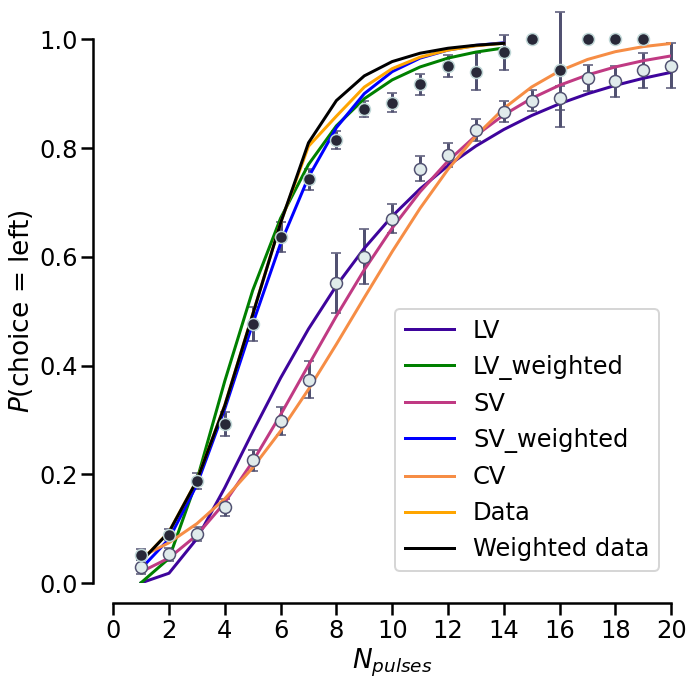

In [360]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.errorbar(x=pulse_bins[:20],y=phigh[:20,0],yerr=phigh[:20,1],marker='o',
             color=cmap_8[0], markeredgecolor=cmap_8[6], markeredgewidth=1.5,
             linestyle = '', clip_on=False, ecolor=cmap_8[6], capsize=5)

ax1.errorbar(x=pulse_bins[:20],y=phigh_weighted[:20,0],yerr=phigh_weighted[:20,1],marker='o',
             color=cmap_8[8], markeredgecolor=cmap_8[1], markeredgewidth=1.5,
             linestyle = '', clip_on=False, ecolor=cmap_8[6], capsize=5)
ax1.plot(pulse_bins[:20],phigh_est_sq2[:20],color=cmap_11[0],linewidth=3)
plt.plot(pulse_bins[:14],phigh_est_sq_w[:14],'green',linewidth=3)
ax1.plot(pulse_bins[:20],phigh_est_lin_MLE[:20],color=cmap_11[4],linewidth=3)
plt.plot(pulse_bins[:14],phigh_est_lin_w[:14],color='blue',linewidth=3)
ax1.plot(pulse_bins[:20],phigh_est_const[:20],color=cmap_11[7],linewidth=3)
plt.plot(pulse_bins[:14],phigh_est_sq_fakesub_w[:14],'orange',linewidth=3)
plt.plot(pulse_bins[:14],phigh_est_lin_fakesub_w[:14],'black',linewidth=3)


#plt.plot(pulse_bins[:14],phigh_est_lin_fakesub_w[:14],'black',linewidth=3)
plt.ylim(0,1)
plt.xlim(0,20)
plt.xticks(np.linspace(0,20,11))
plt.xlabel('$N_{pulses}$')
plt.ylabel('$P$(choice = left)')
plt.legend(['LV', 'LV_weighted','SV', 'SV_weighted','CV', 'Data', 'Weighted data'])
sns.despine(right=True, top=True, offset=20)


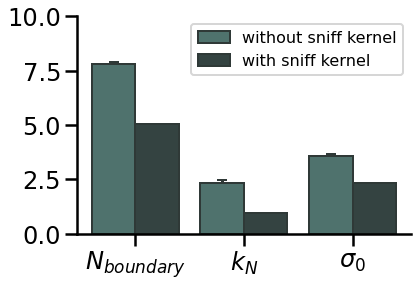

In [647]:
x = np.arange(3)
w = 0.4
fig, ax = plt.subplots()
ax.bar(x -w/2,resx_pool_sq_fakesub[:3,0],yerr=resx_pool_sq_fakesub[:3,1],width=w,color=cmap_12[8], ec=cmap_12[2], alpha=1, lw=2, error_kw=dict(zorder=0, capsize=5, ecolor=cmap_12[2], capthick=2)) #resx_sq_high
ax.bar(x+w/2,resx_pool_sq_fakesub_w[:3,0],yerr=resx_pool_sq_fakesub_w[:3,1],width=w,color=cmap_12[3], ec=cmap_12[2], alpha=1, lw=2, error_kw=dict(zorder=0, capsize=5, ecolor=cmap_12[2], capthick=2))
plt.xticks(np.arange(3),('$N_{boundary}$','$k_{N}$','$\sigma_{0}$'))
plt.legend(['without sniff kernel','with sniff kernel'],prop={'size': 16})
plt.ylim(0,10)
sns.despine()
plt.savefig(savepath_svg + 'fn_plus_lv_w_and_wo_sniff_weights.svg', transparent=True, format='svg', bbox_inches='tight')
plt.savefig(savepath_png + 'fn_plus_lv_w_and_wo_sniff_weights.png', transparent=True, format='png', bbox_inches='tight')
plt.savefig(savepath_pdf + 'fn_plus_lv_w_and_wo_sniff_weights.pdf', transparent=True, format='pdf', bbox_inches='tight')
plt.show()

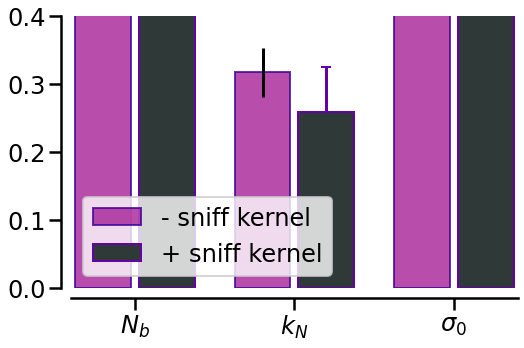

In [242]:
x = np.arange(3)
w = 0.4
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x -w/2,resx_pool_lin_fakesub[0:3,0],yerr=resx_pool_lin_fakesub[0:3,1],
        width=w-0.05,color=cmap_11[3], ec=cmap_11[0], alpha=0.8, lw=2)
ax.bar(x+w/2,resx_pool_lin_fakesub_w[0:3,0]*(1/0.64),yerr=resx_pool_lin_fakesub_w[0:3,1]*(1/0.64),width=w-0.05, color=cmap_12[2], 
        edgecolor=cmap_11[1], lw=2, error_kw=dict(zorder=0, capsize=5, ecolor=cmap_11[1], capthick=2))
plt.xticks(np.arange(3),('$N_{b}$','$k_{N}$','$\sigma_{0}$',)) #, '$sig_0$'))
plt.legend(['- sniff kernel','+ sniff kernel'])

# plt.savefig(savepath_svg + 'sv_model_w_and_wo_sniff_weights.svg', transparent=True, format='svg', bbox_inches='tight')
# plt.savefig(savepath_png + 'sv_model_w_and_wo_sniff_weights.png', transparent=True, format='png', bbox_inches='tight')
# plt.savefig(savepath_pdf + 'sv_model_w_and_wo_sniff_weights.pdf', transparent=True, format='pdf', bbox_inches='tight')
plt.ylim(0,0.4)
plt.xlim(-0.40,2.4)
sns.despine(offset=10)
plt.show()

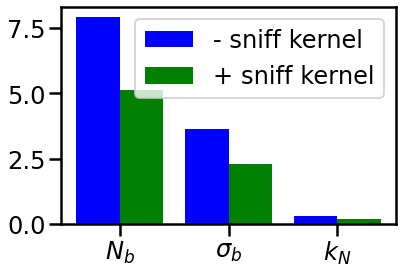

In [ ]:
x = np.arange(3)
w = 0.4
fig, ax = plt.subplots()
ax.bar(x -w/2,resx_pool_lin_sub[0:3,0],yerr=resx_pool_lin_sub[0:3,1],width=w,color='blue')
ax.bar(x+w/2,resx_pool_lin_sub_w[0:3,0],yerr=resx_pool_lin_sub_w[0:3,1],width=w,color='green')
plt.xticks(np.arange(3),('$N_{b}$','$\sigma_{b}$','$k_{N}$')) #, '$sig_0$'))
plt.legend(['- sniff kernel','+ sniff kernel'])
#fig.savefig(savepath + 'three_parameter_comparison.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

<BarContainer object of 1 artists>

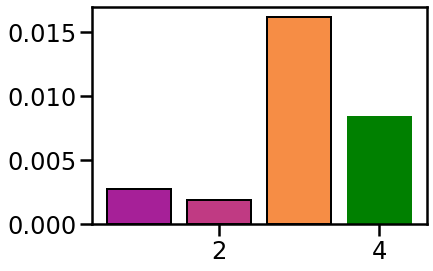

In [ ]:

kl_sq_w = entropy(phigh_est_sq_w[0:19]*bin_counts_weighted[0:19],phigh_weighted[0:19,0]*bin_counts_weighted[0:19])
kl_lin_w = entropy(phigh_est_lin_w[0:19]*bin_counts_weighted[0:19],phigh_weighted[0:19,0]*bin_counts_weighted[0:19])
kl_lin_sub_w = entropy(phigh_est_lin_sub_w[0:19]*bin_counts_weighted[0:19],phigh_weighted[0:19,0]*bin_counts_weighted[0:19])
kl_lin_fakesub_w = entropy(phigh_est_lin_fakesub_w[0:19]*bin_counts_weighted[0:19],phigh_weighted[0:19,0]*bin_counts_weighted[0:19])
kl_const = entropy(phigh_est_const[0:19]*bin_counts_weighted[0:19],phigh_weighted[0:19,0]*bin_counts_weighted[0:19])

plt.bar(1,kl_sq_w, color=cmap_11[3], edgecolor='k')
plt.bar(2,kl_lin_w, color=cmap_11[4], edgecolor='k')
plt.bar(3,kl_lin_sub_w,color=cmap_11[3])
plt.bar(4,kl_lin_fakesub_w,color='green')
plt.bar(3,kl_const,color=cmap_11[7], edgecolor='k')
#plt.bar(6,kl_pow,color='gray')
#plt.bar(7,kl1, color='black')
#plt.bar(8,kl2, color='cyan')


# plt.ylim(0, 0.000005)
# plt.xlim(0, 4)



In [224]:
res_array[1].std()#*(1/0.63)

0.047216617840333514

In [221]:
res_array_lf[1]

array([0.34830709, 0.29075721, 0.34830709, 0.29075721, 0.34830709,
       0.29075721, 0.34830709, 0.29075721, 0.34830709, 0.29075721,
       0.34830709, 0.29075721, 0.34830709, 0.29075721, 0.34830709,
       0.29075721, 0.34830709, 0.29075721, 0.34830709, 0.29075721,
       0.34830709, 0.29075721, 0.34830709, 0.29075721, 0.34830709,
       0.29075721, 0.34830709, 0.29075721, 0.34830709, 0.29075721,
       0.34830709, 0.29075721, 0.3215399 , 0.285846  , 0.3215399 ,
       0.285846  , 0.3215399 , 0.285846  , 0.3215399 , 0.285846  ,
       0.3215399 , 0.285846  , 0.3215399 , 0.285846  , 0.3215399 ,
       0.285846  , 0.3215399 , 0.285846  , 0.3215399 , 0.285846  ,
       0.3215399 , 0.285846  , 0.3215399 , 0.285846  , 0.3215399 ,
       0.285846  , 0.3215399 , 0.285846  , 0.3215399 , 0.285846  ,
       0.3215399 , 0.285846  , 0.3215399 , 0.285846  , 0.3530199 ,
       0.32339969, 0.3530199 , 0.32339969, 0.3530199 , 0.32339969,
       0.3530199 , 0.32339969, 0.3530199 , 0.32339969, 0.35301

In [281]:
import numpy as np

# Example bootstrapped distributions
condition2 = res_array[1]*(1/0.63)
#condition2 = condition2[condition2>0.01]
condition1 = res_array_lf[1]

condition_2_mean, condition_2_std = condition2.mean(), condition2.std()
condition_1_mean, condition_1_std = condition1.mean(), condition1.std()

# Step 1: Compute the observed difference of means
observed_diff = condition_1_mean - condition_2_mean
print(f"Observed Difference of Means: {observed_diff}")

raw_condition1 = np.random.normal(condition_1_mean, condition_1_std, 7)
raw_condition2 = np.random.normal(condition_2_mean, condition_2_std, 7)

# Step 2: Permutation test for the difference of means
combined = np.concatenate([condition1, condition2])
print(len(combined))
n_condition1 = len(condition1)

n_permutations = 100
permuted_diffs = []

for _ in range(n_permutations):
    np.random.shuffle(combined)  # Shuffle the combined data
    perm_condition1 = combined[:n_condition1]
    perm_condition2 = combined[n_condition1:]
    perm_diff = np.median(perm_condition1) - np.median(perm_condition2)
    permuted_diffs.append(perm_diff)

# Convert to numpy array for easier computations
permuted_diffs = np.array(permuted_diffs)

# Step 3: Compute the p-value
p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
print(f"P-value for Difference of Means: {p_value}")

# Step 4: Compute Cohen's d for the observed data
std1, std2 = np.std(raw_condition1, ddof=1), np.std(raw_condition2, ddof=1)
pooled_std = np.sqrt(((len(raw_condition1) - 1) * std1**2 + (len(raw_condition2) - 1) * std2**2) / 
                     (len(raw_condition1) + len(raw_condition2) - 2))
print(pooled_std)
observed_d = (condition_1_mean - condition_2_mean) / pooled_std
print(f"Observed Cohen's d: {observed_d}")


Observed Difference of Means: 0.053493163361424845
2000
P-value for Difference of Means: 0.0
0.027530020471473658
Observed Cohen's d: 1.9430847651150114


In [241]:
from scipy import stats

t_stat, p_value = stats.ttest_ind(condition1, condition2, equal_var=False)  # Welch’s t-test
p_value

2.365975494663688e-95

In [267]:
import pingouin as pg

cohen_d_ci = pg.compute_bootci(condition1, condition2, func='cohen', method='norm', n_boot=100)
print(cohen_d_ci)


[1.1  1.31]


In [272]:
print(condition_2_std)

0.02896601240250691


<BarContainer object of 1 artists>

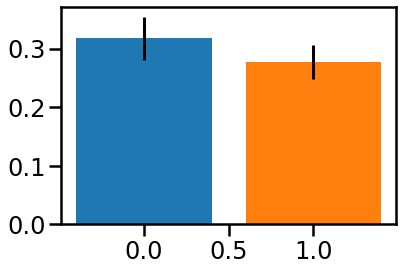

In [273]:
plt.bar(0, height=condition_1_mean, yerr=condition_1_std)
plt.bar(1, height=condition_2_mean, yerr=condition_2_std)

<AxesSubplot:>

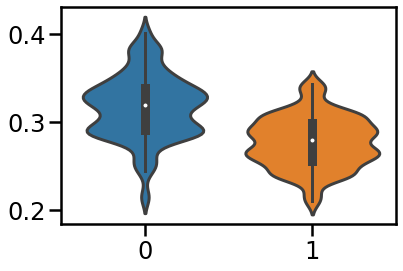

In [278]:
sns.violinplot([condition1, condition2])
#plt.boxplot(condition2)